In [27]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'

from matplotlib.dates import date2num
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from datetime import datetime
import xarray as xr
import netCDF4 as nc
import glob
import math
import subprocess
from matplotlib import colormaps
import plotly.graph_objs as go

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import seaborn as sns
import csv
import pandas as pd
from scipy.optimize import curve_fit
from math import prod

import numpy as np
import matplotlib.pyplot as plt
from metpy.plots import SkewT
from metpy.units import units
from metpy.calc import dewpoint_from_relative_humidity
#from metpy.io import get_test_data

import sys, os
import requests
import pyart

import warnings
warnings.simplefilter("ignore", RuntimeWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)

#%matplotlib notebook

plt.style.use('default')


#import dask
#from dask.distributed import Client, progress, wait
#dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
#client = Client()
#client

#dask.config.set(scheduler='threads', num_workers=2)

from dask.distributed import Client
import dask

# Dashboard config for JupyterHub (optional)
dask.config.config.get('distributed').get('dashboard').update({
    'link': '{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'
})

# Start Dask client with controlled resources
client = Client(n_workers=4, threads_per_worker=2, memory_limit='80GB') # This will use 4*2=8 CPU threads
#client


2025-11-19 11:12:00,325 - distributed.nanny - WARNING - Restarting worker


In [29]:

file_path='/work/bk1415/b382718/output/caipeex/nested_run/icon_output/continental_ccn/latent_heat/sull_ds'
ds_4sip = xr.open_mfdataset(f'{file_path}/4sip/caipeex_2mom/NWP_*.nc', chunks={'time': 4, 'height': 10}, parallel=True);
ds_nosip = xr.open_mfdataset(f'{file_path}/nosip/caipeex_2mom/NWP_*.nc', chunks={'time': 4, 'height': 10}, parallel=True);



In [3]:

grid_caipeex = xr.open_dataset(f'{file_path}/4sip/caipeex_2mom/domain4_DOM04.nc');

clon_deg = np.degrees(grid_caipeex.clon)
clat_deg = np.degrees(grid_caipeex.clat)

print(clon_deg.min().values); print(clon_deg.max().values);
print(clat_deg.min().values); print(clat_deg.max().values);

okla_x, okla_y = np.array([75.5, 17.5])
#print(okla_x), print(okla_y)
dx_deg = 1; dy_deg = 1
left_bound = okla_x - dx_deg
right_bound = okla_x + dx_deg
top_bound = okla_y + dy_deg
bottom_bound = okla_y - dy_deg

print(left_bound), print(right_bound)
print(top_bound), print(bottom_bound)

window_cell = (
    (grid_caipeex.clat >= np.deg2rad(bottom_bound))
    & (grid_caipeex.clat <= np.deg2rad(top_bound))
    & (grid_caipeex.clon >= np.deg2rad(left_bound))
    & (grid_caipeex.clon <= np.deg2rad(right_bound))
).values

(window_cell_indices,) = np.where(window_cell)

# select cells matching with the area of interest (windows_cell_indices:: matching to that with the area sampled by the aircraft)
window_vertex_indices = (np.unique(grid_caipeex.vertex_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_vertex_indices ::',window_vertex_indices)

# select edges matching with the area of interest (corresponding to the windows_cell_indices)
window_edge_indices = (np.unique(grid_caipeex.edge_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_edge_indices ::',window_edge_indices)

selected_indices = xr.Dataset(
    {
        "cell": ("cell", window_cell_indices),
        "vertex": ("vertex", window_vertex_indices),
        "edge": ("edge", window_edge_indices),
    }
)


vars_to_renumber = {
    "cell": [
        "adjacent_cell_of_edge",
        "cells_of_vertex",
        "neighbor_cell_index",
    ],
    "vertex": ["vertex_of_cell", "edge_vertices", "vertices_of_vertex"],
    "edge": ["edge_of_cell", "edges_of_vertex"],
}

def reindex_grid(grid, indices, vars_to_renumber):
    new_grid = grid.load().isel(
        cell=indices.cell, vertex=indices.vertex, edge=indices.edge
    )
    for dim, idx in indices.coords.items():
        renumbering = np.full(grid.dims[dim], -2, dtype="int")
        renumbering[idx] = np.arange(len(idx))
        for name in vars_to_renumber[dim]:
            new_grid[name].data = renumbering[new_grid[name].data - 1] + 1
    return new_grid

new_grid_caipeex = reindex_grid(grid_caipeex, selected_indices, vars_to_renumber)

mask=np.isin(ds_4sip['ncells'], selected_indices.cell)
mask_ncells_caipeex=mask

73.96231325070727
78.03733091737507
15.966592379850837
20.032768784756854
74.5
76.5
18.5
16.5
window_vertex_indices :: [ 3668  3670  3677 ... 34852 34853 34854]
window_edge_indices :: [ 11036  11037  11038 ... 103811 103812 103813]


In [30]:

ds_4sip['w_vel'] = -1.*ds_4sip.omega/(9.8*ds_4sip.rho)
ds_4sip['tempc'] = ds_4sip.temp-273.16;
ds_4sip['lwc_gperm3']  = ds_4sip.qc*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['tqi'] = ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh
ds_4sip['tq'] = ds_4sip.qc+ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh
ds_4sip['ciwc_gperm3'] = ds_4sip.qi*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['tiwc_gperm3'] = (ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh)*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['cdnc_percm3'] = ds_4sip.qnc*ds_4sip.rho*1.e-6  # perkg to percm3
ds_4sip['inc_perl'] = (ds_4sip.qni+ds_4sip.qns+ds_4sip.qng+ds_4sip.qnh)*ds_4sip.rho*1.e-3 # perkg to perl

ds_nosip['w_vel'] = -1.*ds_nosip.omega/(9.8*ds_nosip.rho)
ds_nosip['tempc'] = ds_nosip.temp-273.16;
ds_nosip['lwc_gperm3']  = ds_nosip.qc*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['tqi'] = ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh
ds_nosip['tq'] = ds_nosip.qc+ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh
ds_nosip['ciwc_gperm3'] = ds_nosip.qi*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['tiwc_gperm3'] = (ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh)*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['cdnc_percm3'] = ds_nosip.qnc*ds_nosip.rho*1.e-6  # perkg to percm3
ds_nosip['inc_perl'] = (ds_nosip.qni+ds_nosip.qns+ds_nosip.qng+ds_nosip.qnh)*ds_nosip.rho*1.e-3 # perkg to perl

ht_4sip_avg = 1.e-3*ds_4sip.z_mc.mean(dim=('time','ncells'))
tempc_4sip_avg = ds_4sip.tempc.mean(dim=('time','ncells'))

ht_nosip_avg = 1.e-3*ds_4sip.z_mc.mean(dim=('time','ncells'))
tempc_nosip_avg = ds_4sip.tempc.mean(dim=('time','ncells'))

In [31]:

aircraft_starttime='2019-09-30T07:00:00.000000000'
aircraft_endtime='2019-09-30T11:00:00.000000000'

ds_4sip_new = ds_4sip.sel(ncells=mask_ncells_caipeex,time=slice(aircraft_starttime, aircraft_endtime))
ds_nosip_new = ds_nosip.sel(ncells=mask_ncells_caipeex,time=slice(aircraft_starttime, aircraft_endtime))


In [9]:
ds_4sip.clon[1:10].values

array([1.30682264, 1.30662318, 1.30641508, 1.30621559, 1.30600753,
       1.305808  , 1.30559997, 1.30540041, 1.30519241])

In [7]:

print(np.rad2deg(grid_caipeex.clon.min().values), np.rad2deg(grid_caipeex.clon.max().values))
print(np.rad2deg(grid_caipeex.clat.min().values), np.rad2deg(grid_caipeex.clon.max().values))
print(np.rad2deg(ds_4sip_new.clon.min().values), np.rad2deg(ds_4sip_new.clon.max().values))
print(np.rad2deg(ds_4sip_new.clat.min().values), np.rad2deg(ds_4sip_new.clat.max().values))

73.96231325070727 78.03733091737507
15.966592379850837 78.03733091737507
74.50007813118492 76.49993737193526
16.500019080654198 18.499970289086082


## Radar

In [6]:


ds_refl_obs = xr.open_dataset('/work/bk1415/b382718/output/caipeex/observations/radar_data/Case20190930_RADAR_DBZc_4D.nc')


# the region corresponding to the B200 aircraft
lon_min, lon_max = 75, 76
lat_min, lat_max = 17, 18

# Apply the condition to select data within the desired region
ds_refl_obs = ds_refl_obs.where(
    (ds_refl_obs.lon >= lon_min) & (ds_refl_obs.lon <= lon_max) &
    (ds_refl_obs.lat >= lat_min) & (ds_refl_obs.lat <= lat_max), 
    drop=True  # Drop values outside the region
)

mask = (
    (np.rad2deg(ds_4sip.clon) >= lon_min) &
    (np.rad2deg(ds_4sip.clon) <= lon_max) &
    (np.rad2deg(ds_4sip.clat) >= lat_min) &
    (np.rad2deg(ds_4sip.clat) <= lat_max)
).compute()

ds_4sip_refl = ds_4sip.where(mask, drop=True)

#ds_refl_obs = ds_refl_obs.sel(lon=slice(75.25,76),lat=slice(16.5,17.75))

ds_refl_obs['lon'] = xr.where(ds_refl_obs.lon > 0., ds_refl_obs.lon, np.nan)
ds_refl_obs['lat'] = xr.where(ds_refl_obs.lat > 0., ds_refl_obs.lat, np.nan)

ht_obs = 1.e-3*ds_refl_obs.alt;
time_obs = ds_refl_obs.time;
zrefl_obs = ds_refl_obs.dbzc;

lon = ds_refl_obs.lon.mean(axis=1)
lat = ds_refl_obs.lat.mean(axis=0)

print(ds_refl_obs.lon.min().values,ds_refl_obs.lon.max().values)
print(ds_refl_obs.lat.min().values,ds_refl_obs.lat.max().values)

print(lon.min().values,lon.max().values)
print(lat.min().values,lat.max().values)

print(ds_refl_obs.lat[1,1:10].values)
print(ds_refl_obs.lat[1:10,1].values)
#plt.plot(ds_refl_obs.lat);

74.99989 75.99277
16.99984 17.999884
75.49633 75.49828
17.49895 17.500761
[17.008873 17.008911 17.008951 17.00899  17.009027 17.009064 17.009102
 17.009138 17.009174]
[17.008873 17.017866 17.026857 17.03585  17.044844 17.053837 17.06283
 17.071823 17.080816]


In [9]:

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Load the radar data
ds_refl_obs = xr.open_dataset('/work/bk1415/b382718/output/caipeex/observations/radar_data/Case20190930_RADAR_DBZc_4D.nc')

# Extract reflectivity data
dbzc = ds_refl_obs['dbzc']
alt = ds_refl_obs['alt']

# Define reflectivity bins
dbz_bins = np.arange(-10, 51, 1)  # 1 dB resolution from -10 to 50 dBZ
dbz_centers = (dbz_bins[:-1] + dbz_bins[1:]) / 2

# Initialize frequency array
n_alt = len(alt)
n_dbz = len(dbz_bins) - 1
frequency = np.zeros((n_alt, n_dbz))

# Calculate frequency distribution for each altitude level
for i, altitude in enumerate(alt):
    # Get all reflectivity values at this altitude (across time, lat, lon)
    dbz_at_alt = dbzc.isel(alt=i).values.flatten()
    
    # Remove NaN values
    dbz_at_alt = dbz_at_alt[~np.isnan(dbz_at_alt)]
    
    if len(dbz_at_alt) > 0:
        # Calculate histogram
        counts, _ = np.histogram(dbz_at_alt, bins=dbz_bins)
        # Normalize to get frequency (percentage)
        frequency[i, :] = (counts / len(dbz_at_alt)) * 100
        

CFAD plot saved as 'cfad_radar_reflectivity.png'


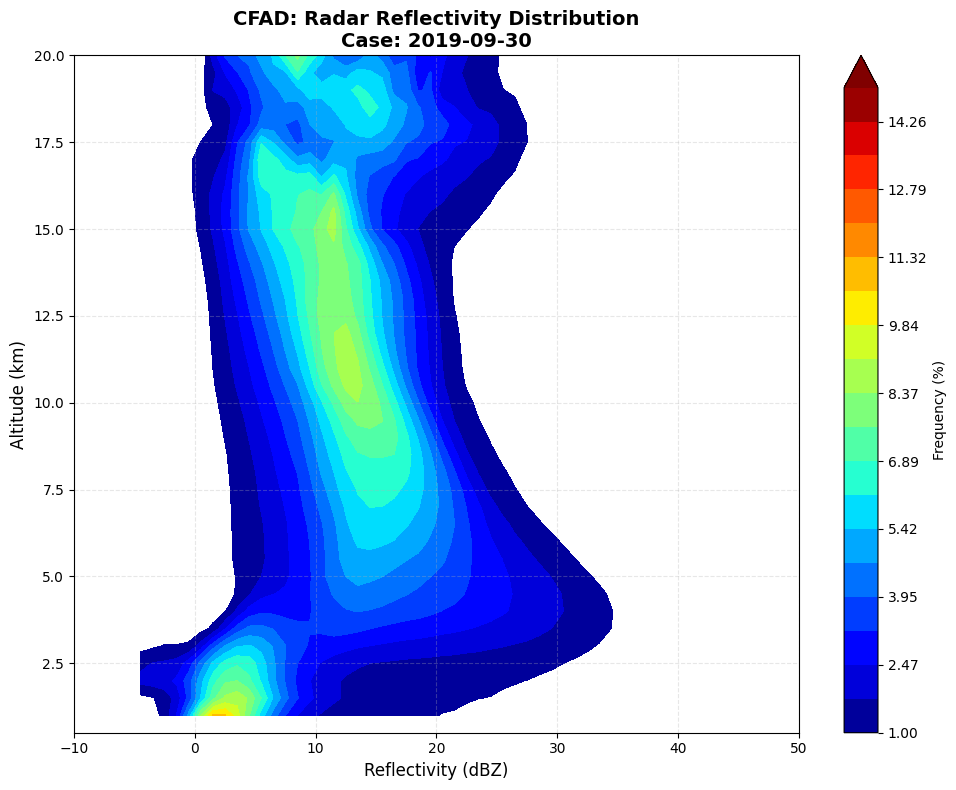

In [18]:


plt.style.use('default')
# Create the CFAD plot
fig, ax = plt.subplots(figsize=(10, 8))

# Use logarithmic normalization for better visualization
# Add small value to avoid log(0)
frequency_plot = np.where(frequency > 0, frequency, np.nan)

# Create contour plot
levels = [0.1, 0.5, 1, 2, 5, 10, 20, 30, 40, 50]
lev=np.linspace(1,15,20)
cf = ax.contourf(dbz_centers, alt/1000, frequency_plot, 
                 levels=lev, cmap='jet', extend='max')

# Add contour lines
#cs = ax.contour(dbz_centers, alt/1000, frequency_plot, 
#                levels=lev, colors='black', linewidths=0.5, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(cf, ax=ax, label='Frequency (%)')

# Labels and title
ax.set_xlabel('Reflectivity (dBZ)', fontsize=12)
ax.set_ylabel('Altitude (km)', fontsize=12)
ax.set_title('CFAD: Radar Reflectivity Distribution\nCase: 2019-09-30', fontsize=14, fontweight='bold')

# Set axis limits
ax.set_xlim(-10, 50)
ax.set_ylim(alt.min()/1000, alt.max()/1000)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig('cfad_radar_reflectivity.png', dpi=300, bbox_inches='tight')
print("CFAD plot saved as 'cfad_radar_reflectivity.png'")

plt.show()

# Print some statistics
#print(f"\nData statistics:")
#print(f"Total number of observations: {np.sum(~np.isnan(dbzc.values))}")
#print(f"Altitude range: {alt.min().values/1000:.2f} - {alt.max().values/1000:.2f} km")
#print(f"Reflectivity range: {np.nanmin(dbzc.values):.2f} - {np.nanmax(dbzc.values):.2f} dBZ")

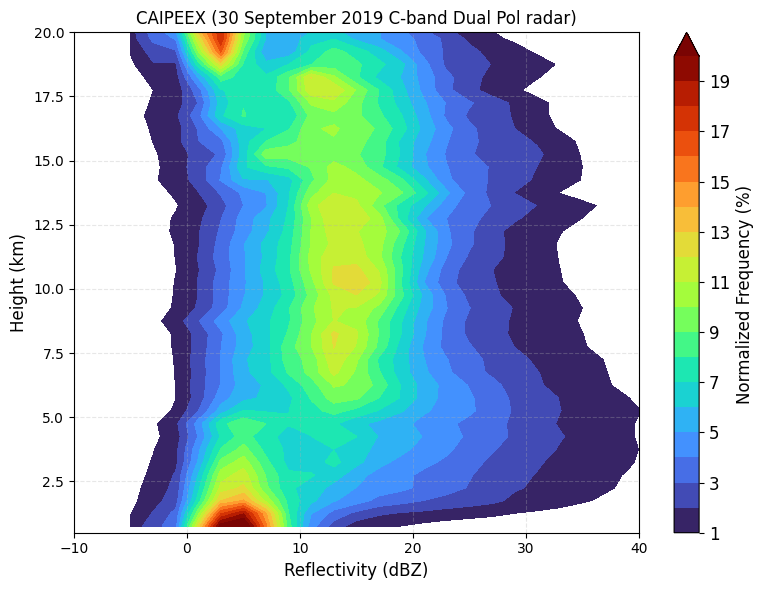

In [54]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load the radar data
ds_refl_obs = xr.open_dataset('/work/bk1415/b382718/output/caipeex/observations/radar_data/Case20190930_RADAR_DBZc_4D.nc')


stime='2019-09-30T06:00:00.000000000'
etime='2019-09-30T20:00:00.000000000'

#mask = ds_refl_obs.where(ds_refl_obs.dbzc > -10., drop=True)
ds_refl_obs = ds_refl_obs.sel(time=slice(stime, etime))

# Extract reflectivity data and altitude
refl_obs = ds_refl_obs['dbzc'].values  # shape: (time, alt, lat, lon)
alt = ds_refl_obs['alt'].values        # altitude in meters

# Convert altitude to km
height_km = alt / 1000.0

# =====================================================
# Create CFAD (Contoured Frequency by Altitude Diagram)
# =====================================================

# Define bins
dbz_bins = np.arange(-10, 51, 2)      # 2 dBZ bins from -10 to 50
height_bins = np.arange(height_km.min(), height_km.max() + 1, 0.5)  # 0.5 km bins

# Flatten all dimensions
refl_obs_flat_1d = refl_obs.flatten()

# Create corresponding height array for each data point
# Each altitude level needs to be repeated for all time, lat, lon points
n_time, n_alt, n_lat, n_lon = refl_obs.shape
height_obs_flat_1d = np.repeat(height_km, n_time * n_lat * n_lon)

# Remove invalid data (NaN values)
valid_mask_obs = ~np.isnan(refl_obs_flat_1d) & ~np.isnan(height_obs_flat_1d)
refl_obs_valid = refl_obs_flat_1d[valid_mask_obs]
height_obs_valid = height_obs_flat_1d[valid_mask_obs]

# Create 2D histogram
hist_obs_2d, height_obs_edges, dbz_obs_edges = np.histogram2d(
    height_obs_valid, refl_obs_valid,
    bins=[height_bins, dbz_bins]
)

# Normalize by altitude (each height level sums to 1)
# This is the key feature of CFAD diagrams
hist_obs_normalized = np.zeros_like(hist_obs_2d)
for i in range(hist_obs_2d.shape[0]):
    row_obs_sum = hist_obs_2d[i, :].sum()
    if row_obs_sum > 0:
        hist_obs_normalized[i, :] = hist_obs_2d[i, :] / row_obs_sum

# Convert to percentage
freq_percent_obs = hist_obs_normalized * 100

# Mask zeros for better visualization
freq_percent_obs_masked = np.ma.masked_where(freq_percent_obs == 0, freq_percent_obs)

# Calculate median reflectivity at each height level
median_dbz_obs = []
median_heights_obs = []
for i in range(len(height_bins)-1):
    h_min_obs = height_bins[i]
    h_max_obs = height_bins[i+1]
    mask_obs = (height_obs_valid >= h_min_obs) & (height_obs_valid < h_max_obs)
    
    if mask_obs.sum() > 0:
        median_val_obs = np.median(refl_obs_valid[mask_obs])
        median_dbz_obs.append(median_val_obs)
        median_heights_obs.append((h_min_obs + h_max_obs) / 2.)

# =====================================================
# Plot CFAD
# =====================================================

fnt = 12
plt.style.use('default')
fig, ax = plt.subplots(figsize=(8, 6))

# Create meshgrid for plotting - use bin centers instead of edges
height_obs_centers = (height_obs_edges[:-1] + height_obs_edges[1:]) / 2
dbz_obs_centers = (dbz_obs_edges[:-1] + dbz_obs_edges[1:]) / 2
H_obs, D_obs = np.meshgrid(height_obs_centers, dbz_obs_centers)

# Filled contours
lev = np.linspace(1, 20, 20)  # Contour levels from 1 to 20%

contourf = ax.contourf(D_obs, H_obs, freq_percent_obs_masked.T, 
                       levels=lev, 
                       cmap='turbo', 
                       extend='max')

# Optional: Add contour lines for clarity
#contour_lines = ax.contour(D_obs, H_obs, freq_percent_obs_masked.T, 
#                           levels=[1, 2, 5, 10, 15, 20], 
#                           colors='black', 
#                           linewidths=0.5, 
#                           alpha=0.5)

# Colorbar
cbar = plt.colorbar(contourf, ax=ax, label='Normalized Frequency (%)')
cbar.ax.tick_params(labelsize=fnt)
cbar.set_label(label='Normalized Frequency (%)', size=fnt)

# Labels and title
ax.set_xlabel('Reflectivity (dBZ)', fontsize=fnt)
ax.set_ylabel('Height (km)', fontsize=fnt)
ax.set_title('CAIPEEX (30 September 2019 C-band Dual Pol radar)', fontsize=fnt)

# Set axis limits
ax.set_xlim([-10, 40])
ax.set_ylim([height_km.min(), height_km.max()])

# Grid
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()

# Save figure
#plt.savefig('cfad_radar_reflectivity_caipeex.png', dpi=300, bbox_inches='tight')
#print("CFAD plot saved as 'cfad_radar_reflectivity_caipeex.png'")

plt.show()

# =====================================================
# Print statistics
# =====================================================

#print("\nCFAD Statistics:")
#print(f"Total valid points: {len(refl_obs_valid):,}")
#print(f"Height range: {height_obs_valid.min():.2f} - {height_obs_valid.max():.2f} km")
#print(f"Reflectivity range: {refl_obs_valid.min():.2f} - {refl_obs_valid.max():.2f} dBZ")
#print(f"Max normalized frequency: {freq_percent_obs_masked.max():.2f}%")
#print(f"Number of time steps: {refl_obs.shape[0]}")
#print(f"Number of altitude levels: {refl_obs.shape[1]}")

In [39]:

stime='2019-09-30T06:00:00.000000000'
etime='2019-09-30T20:00:00.000000000'

#lon_min, lon_max = 75, 76
#lat_min, lat_max = 17, 18
#mask = (
#    (np.rad2deg(ds_4sip.clon) >= lon_min) &
#    (np.rad2deg(ds_4sip.clon) <= lon_max) &
#    (np.rad2deg(ds_4sip.clat) >= lat_min) &
#    (np.rad2deg(ds_4sip.clat) <= lat_max)
#).compute()

#ds_4sip_refl = ds_4sip.where(mask, drop=True)

#ds_4sip_refl = ds_4sip_refl.sel(time=slice(stime, etime))
ds_4sip_refl = ds_4sip.sel(time=slice(stime, etime))

#mask_refl = (ds_4sip.dbz > -10.) & (np.abs(ds_4sip.w_vel) < 6.) & (ds_4sip_filt.tq > 1.e-6)
filt_refl_4sip = xr.where((ds_4sip_refl.dbz > -10.), ds_4sip_refl.dbz, np.nan)

alt_4sip_km = 1.e-3*ds_4sip_refl.z_mc

# Extract reflectivity and height data
refl_4sip = filt_refl_4sip.values   # shape: (time, height, ncells)
height_4sip = alt_4sip_km.values    # shape: (time, height, ncells) or (height, ncells)

# Flatten all dimensions to 1D arrays
refl_4sip_flat = refl_4sip.flatten()
height_4sip_flat = height_4sip.flatten()


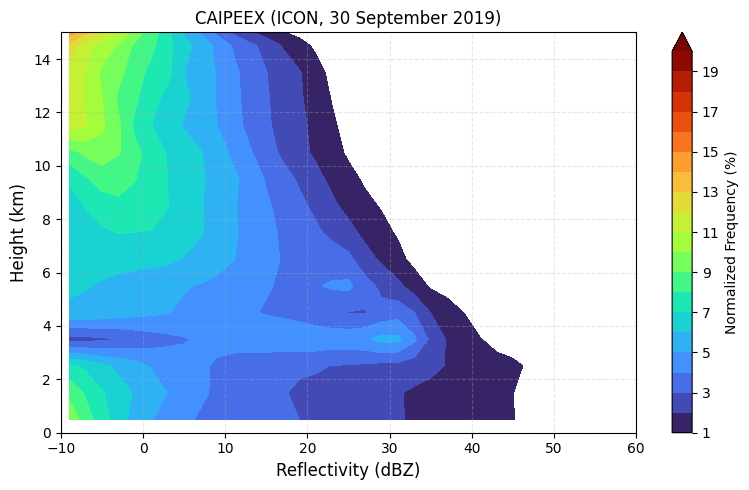

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr



# Remove invalid data (NaN values)
valid_4sip_mask = ~np.isnan(refl_4sip_flat) & ~np.isnan(height_4sip_flat)  
refl_4sip_valid = refl_4sip_flat[valid_4sip_mask]
height_4sip_valid = height_4sip_flat[valid_4sip_mask]

# =====================================================
# Create CFAD for ICON data
# =====================================================

# Define bins (same as radar CFAD for comparison)
dbz_bins = np.arange(-14, 50, 2)  # 2 dBZ bins
height_bins = np.arange(0, 20, 1.0)  # 400 m bins (0.4 km)

# Create 2D histogram
hist_4sip_2d, height_4sip_edges, dbz_4sip_edges = np.histogram2d(
    height_4sip_valid, refl_4sip_valid,
    bins=[height_bins, dbz_bins]
)

# Normalize by altitude (each height level sums to 1)
hist_4sip_normalized = np.zeros_like(hist_4sip_2d)
for i in range(hist_4sip_2d.shape[0]):
    row_sum_4sip = hist_4sip_2d[i, :].sum()
    if row_sum_4sip > 0:
        hist_4sip_normalized[i, :] = hist_4sip_2d[i, :] / row_sum_4sip

# Convert to percentage
freq_percent_4sip = hist_4sip_normalized * 100

# Mask zeros for better visualization
freq_percent_masked_4sip = np.ma.masked_where(freq_percent_4sip == 0, freq_percent_4sip)

# =====================================================
# Calculate median and mode
# =====================================================

# Calculate median reflectivity at each height bin
median_dbz_4sip = []
median_heights_4sip = []
for i in range(len(height_bins)-1):
    h_min_4sip = height_bins[i]
    h_max_4sip = height_bins[i+1]
    mask_4sip = (height_4sip_valid >= h_min_4sip) & (height_4sip_valid < h_max_4sip)
    
    if mask_4sip.sum() > 0:
        median_val_4sip = np.median(refl_4sip_valid[mask_4sip])
        median_dbz_4sip.append(median_val_4sip)
        median_heights_4sip.append((h_min_4sip + h_max_4sip) / 2.)

# Find mode (most frequent reflectivity) at each height
mode_dbz_4sip = []
mode_heights_4sip = []
for i in range(len(height_bins)-1):
    if hist_4sip_normalized[i, :].sum() > 0:
        max_idx_4sip = np.argmax(hist_4sip_normalized[i, :])
        mode_dbz_4sip.append((dbz_bins[max_idx_4sip] + dbz_bins[max_idx_4sip+1]) / 2)
        mode_heights_4sip.append((height_bins[i] + height_bins[i+1]) / 2)

# =====================================================
# Plot CFAD
# =====================================================
fnt=12
lev=np.linspace(1,20,20)

fig, ax = plt.subplots(figsize=(8, 5))

# Create meshgrid for plotting - use bin centers
height_4sip_centers = (height_4sip_edges[:-1] + height_4sip_edges[1:]) / 2
dbz_4sip_centers = (dbz_4sip_edges[:-1] + dbz_4sip_edges[1:]) / 2
H_4sip, D_4sip = np.meshgrid(height_4sip_centers, dbz_4sip_centers)

# Filled contours
levels = np.arange(0, freq_percent_masked_4sip.max() + 1, 1)  # 1% intervals
contourf = ax.contourf(D_4sip, H_4sip, freq_percent_masked_4sip.T, 
                       levels=lev, 
                       cmap='turbo', 
                       extend='max')

# Add contour lines for clarity
#contour_lines = ax.contour(D, H, freq_percent_masked.T, 
#                           levels=[1, 2, 5, 10, 15, 20], 
#                           colors='black', 
#                           linewidths=0.5, 
#                           alpha=0.5)
#ax.clabel(contour_lines, inline=True, fontsize=fnt, fmt='%d%%')

# Plot mode and median lines
#ax.plot(mode_dbz, mode_heights, 'k-', linewidth=2.5, label='Mode', zorder=10)
#ax.plot(median_dbz, median_heights, 'w-', linewidth=2.5, zorder=11)
#ax.plot(median_dbz, median_heights, 'r--', linewidth=2, label='Median', zorder=12)

# Colorbar
cbar = plt.colorbar(contourf, ax=ax, label='Normalized Frequency (%)')

# Labels and title
ax.set_xlabel('Reflectivity (dBZ)', fontsize=fnt)#, fontweight='bold')
ax.set_ylabel('Height (km)', fontsize=fnt)#, fontweight='bold')
ax.set_title('CAIPEEX (ICON, 30 September 2019)', fontsize=fnt)#, fontweight='bold')

# Set reasonable axis limits
ax.set_xlim([-10, 60])
ax.set_ylim([0, 15])

# Grid and legend
ax.grid(True, alpha=0.3, linestyle='--')
#ax.legend(loc='upper right', framealpha=0.9)

plt.tight_layout()
plt.show()


# =====================================================
# Print statistics
# =====================================================

#print("CFAD Statistics (ICON 4SIP):")
#print(f"Total valid points: {len(refl_valid):,}")
#print(f"Height range: {height_valid.min():.2f} - {height_valid.max():.2f} km")
#print(f"Reflectivity range: {refl_valid.min():.2f} - {refl_valid.max():.2f} dBZ")
#print(f"Max normalized frequency: {freq_percent_masked.max():.2f}%")
#print(f"Time steps: {refl_icon.shape[0]}")
#print(f"Height levels: {refl_icon.shape[1]}")
#print(f"Number of cells: {refl_icon.shape[2]}")

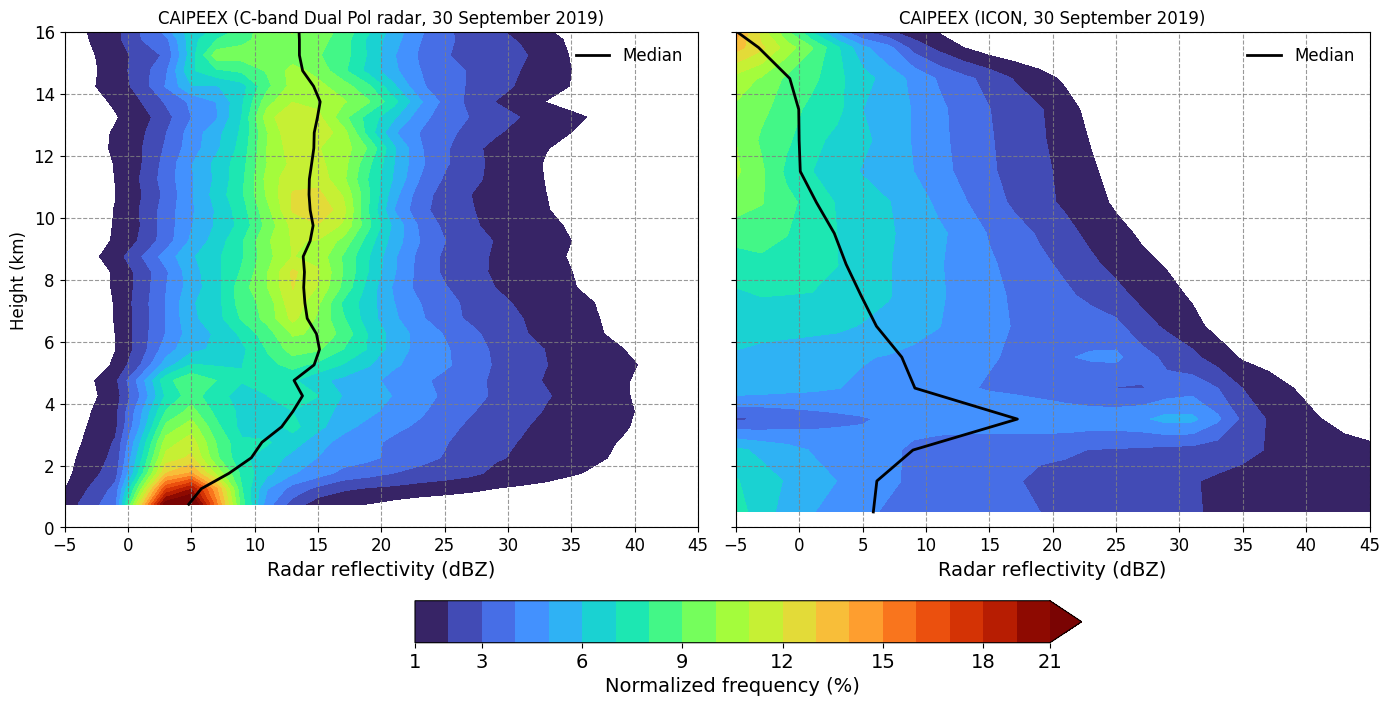

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Create data (make sure D_obs, H_obs, freq_percent_obs_masked, etc. are defined)
lev = np.linspace(1, 20, 20)

fnt = 12
ln=2;

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# First subplot (DCMEX Observations)
cnt1 = ax1.contourf(D_obs, H_obs, freq_percent_obs_masked.T, 
                        levels=lev, 
                        cmap='turbo', 
                        extend='max')

# Colorbar for first subplot
#cbar1 = plt.colorbar(contourf, ax=ax1, label='Normalized Frequency (%)')
#cbar1.ax.tick_params(labelsize=fnt)
#cbar1.set_label(label='Normalized Frequency (%)', size=fnt)

ax1.plot(median_dbz_obs, median_heights_obs, 'k-', linewidth=ln, zorder=11, label='Median')

# Labels and title for first subplot
ax1.set_xlabel('Radar reflectivity (dBZ)', fontsize=fnt+2)
ax1.set_ylabel('Height (km)', fontsize=fnt)   # ASL
ax1.set_title('CAIPEEX (C-band Dual Pol radar, 30 September 2019)', fontsize=fnt)

# Set reasonable axis limits for first subplot
ax1.set_xlim([-5, 45])
ax1.set_ylim([0, 16])
ax1.set_xticks([-5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45])
ax1.set_yticks([0, 2, 4, 6, 8, 10, 12, 14, 16])

ax1.tick_params(axis='x', labelsize=fnt)
ax1.tick_params(axis='y', labelsize=fnt)

# Grid for first subplot
ax1.grid(True, linestyle='--', color='grey', alpha=0.8)
ax1.legend(frameon=False, loc='best', fontsize=fnt)

# Second subplot (ICON Simulation)
cnt2 = ax2.contourf(D_4sip, H_4sip, freq_percent_masked_4sip.T, 
                        levels=lev, 
                        cmap='turbo', 
                        extend='max')


ax2.plot(median_dbz_4sip, median_heights_4sip, 'k-', linewidth=ln, zorder=11, label='Median')

# Colorbar for second subplot
#cbar2 = plt.colorbar(contourf, ax=ax2, label='Normalized Frequency (%)')

# Labels and title for second subplot
ax2.set_xlabel('Radar reflectivity (dBZ)', fontsize=fnt+2)
#ax2.set_ylabel('Height (km)', fontsize=fnt)
ax2.set_title('CAIPEEX (ICON, 30 September 2019)', fontsize=fnt)

# Set reasonable axis limits for second subplot
ax2.set_xlim([-5, 45])
ax2.set_ylim([0, 16])
ax2.set_xticks([-5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45])
ax2.set_yticks([0, 2, 4, 6, 8, 10, 12, 14, 16])

ax2.set_yticklabels([])

ax2.tick_params(axis='x', labelsize=fnt)

# Grid for second subplot
ax2.grid(True, linestyle='--', color='grey', alpha=0.8)
ax2.legend(frameon=False, loc='best', fontsize=fnt)

fig = plt.gcf()  # Get the current figure
#cbar_ax1 = fig.add_axes([0.25, 0.25, 0.5, 0.04])  # [left, bottom, width, height]
cbar_ax1 = fig.add_axes([0.3, -0.08, 0.5, 0.07])
cbar = fig.colorbar(cnt2, cax=cbar_ax1, ticks=[1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20], orientation='horizontal')
cbar = fig.colorbar(cnt2, cax=cbar_ax1, ticks=[1, 3, 6, 9, 12, 15, 18, 21], orientation='horizontal')
cbar.set_label('Normalized frequency (%)', fontsize=fnt+2)
cbar.ax.tick_params(labelsize=fnt+2)

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show plot
plt.show()


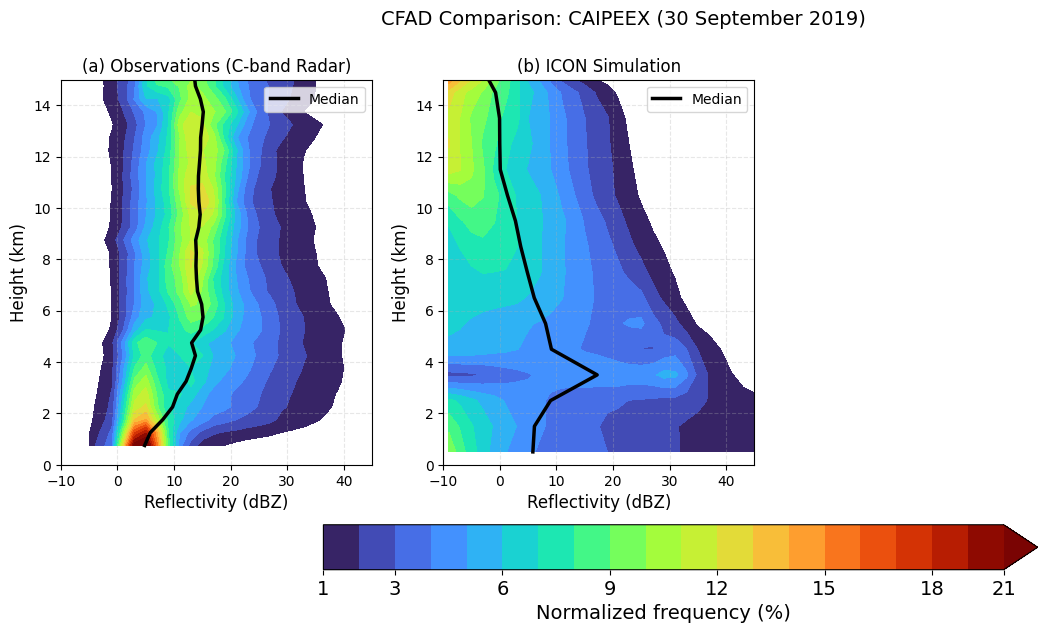

In [62]:
# =====================================================
# Option 1: Side-by-side with difference plot
# =====================================================

fnt = 12
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.3)

# Common settings for consistency
dbz_lim = [-10, 45]
height_lim = [0, 15]
lev = np.linspace(1, 20, 20)

# Panel 1: Observations
ax1 = fig.add_subplot(gs[0])
H_obs, D_obs = np.meshgrid(height_obs_centers, dbz_obs_centers)
cnt1 = ax1.contourf(D_obs, H_obs, freq_percent_obs_masked.T, 
                   levels=lev, cmap='turbo', extend='max')
ax1.plot(median_dbz_obs, median_heights_obs, 'k-', linewidth=2.5, label='Median')
ax1.set_xlabel('Reflectivity (dBZ)', fontsize=fnt)
ax1.set_ylabel('Height (km)', fontsize=fnt)
ax1.set_title('(a) Observations (C-band Radar)', fontsize=fnt)
ax1.set_xlim(dbz_lim)
ax1.set_ylim(height_lim)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(loc='upper right')

# Panel 2: ICON simulation
ax2 = fig.add_subplot(gs[1])
H_4sip, D_4sip = np.meshgrid(height_4sip_centers, dbz_4sip_centers)
cnt2 = ax2.contourf(D_4sip, H_4sip, freq_percent_masked_4sip.T, 
                   levels=lev, cmap='turbo', extend='max')
ax2.plot(median_dbz_4sip, median_heights_4sip, 'k-', linewidth=2.5, label='Median')
ax2.set_xlabel('Reflectivity (dBZ)', fontsize=fnt)
ax2.set_ylabel('Height (km)', fontsize=fnt)
ax2.set_title('(b) ICON Simulation', fontsize=fnt)
ax2.set_xlim(dbz_lim)
ax2.set_ylim(height_lim)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(loc='upper right')

# Panel 3: Difference (ICON - Observations)
#ax3 = fig.add_subplot(gs[2])
## Interpolate to common grid if needed, or ensure same bins
#diff = freq_percent_masked_4sip.T - freq_percent_obs_masked.T
#diff_levels = np.linspace(-10, 10, 21)
#cf3 = ax3.contourf(D_obs, H_obs, diff, 
#                   levels=diff_levels, cmap='RdBu_r', extend='both')
#ax3.contour(D_obs, H_obs, diff, levels=[0], colors='black', linewidths=2)
#ax3.set_xlabel('Reflectivity (dBZ)', fontsize=fnt)
#ax3.set_ylabel('Height (km)', fontsize=fnt)
#ax3.set_title('(c) Difference (ICON - Obs)', fontsize=fnt)
#ax3.set_xlim(dbz_lim)
#ax3.set_ylim(height_lim)
#ax3.grid(True, alpha=0.3, linestyle='--')

# Colorbars
#cax1 = fig.add_subplot(gs[2])
#cbar1 = plt.colorbar(cf2, cax=cax1, label='Frequency Difference (%)')
#cbar1.ax.tick_params(labelsize=fnt)

fig = plt.gcf()  # Get the current figure
#cbar_ax1 = fig.add_axes([0.25, 0.25, 0.5, 0.04])  # [left, bottom, width, height]
cbar_ax1 = fig.add_axes([0.3, -0.1, 0.5, 0.09])
cbar = fig.colorbar(cnt2, cax=cbar_ax1, ticks=[1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20], orientation='horizontal')
cbar = fig.colorbar(cnt2, cax=cbar_ax1, ticks=[1, 3, 6, 9, 12, 15, 18, 21], orientation='horizontal')
cbar.set_label('Normalized frequency (%)', fontsize=fnt+2)
cbar.ax.tick_params(labelsize=fnt+2)

plt.suptitle('CFAD Comparison: CAIPEEX (30 September 2019)', fontsize=fnt+2, y=1.02)
plt.tight_layout()
plt.savefig('cfad_comparison_with_difference.png', dpi=300, bbox_inches='tight')
plt.show()

ValueError: operands could not be broadcast together with shapes (31,19) (30,40) 

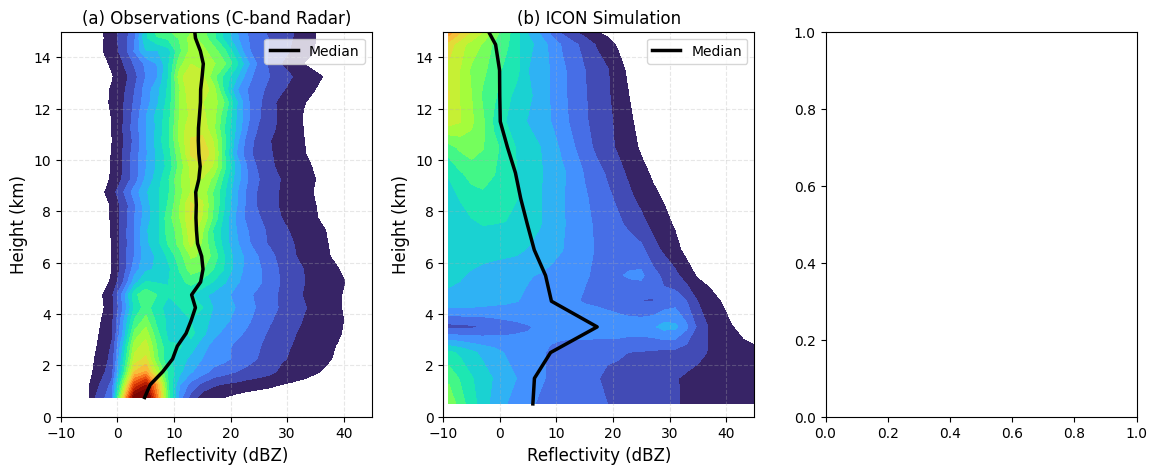

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Assuming you have already calculated:
# - freq_percent_obs_masked (from radar observations)
# - freq_percent_masked_4sip (from ICON simulations)
# - height_obs_centers, dbz_obs_centers (from observations)
# - height_4sip_centers, dbz_4sip_centers (from ICON)
# - median_dbz_obs, median_heights_obs
# - median_dbz_4sip, median_heights_4sip

# =====================================================
# Option 1: Side-by-side with difference plot
# =====================================================

fnt = 12
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.3)

# Common settings for consistency
dbz_lim = [-10, 45]
height_lim = [0, 15]
lev = np.linspace(1, 20, 20)

# Panel 1: Observations
ax1 = fig.add_subplot(gs[0])
H_obs, D_obs = np.meshgrid(height_obs_centers, dbz_obs_centers)
cf1 = ax1.contourf(D_obs, H_obs, freq_percent_obs_masked.T, 
                   levels=lev, cmap='turbo', extend='max')
ax1.plot(median_dbz_obs, median_heights_obs, 'k-', linewidth=2.5, label='Median')
ax1.set_xlabel('Reflectivity (dBZ)', fontsize=fnt)
ax1.set_ylabel('Height (km)', fontsize=fnt)
ax1.set_title('(a) Observations (C-band Radar)', fontsize=fnt)
ax1.set_xlim(dbz_lim)
ax1.set_ylim(height_lim)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(loc='upper right')

# Panel 2: ICON simulation
ax2 = fig.add_subplot(gs[1])
H_4sip, D_4sip = np.meshgrid(height_4sip_centers, dbz_4sip_centers)
cf2 = ax2.contourf(D_4sip, H_4sip, freq_percent_masked_4sip.T, 
                   levels=lev, cmap='turbo', extend='max')
ax2.plot(median_dbz_4sip, median_heights_4sip, 'k-', linewidth=2.5, label='Median')
ax2.set_xlabel('Reflectivity (dBZ)', fontsize=fnt)
ax2.set_ylabel('Height (km)', fontsize=fnt)
ax2.set_title('(b) ICON Simulation', fontsize=fnt)
ax2.set_xlim(dbz_lim)
ax2.set_ylim(height_lim)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(loc='upper right')

# Panel 3: Difference (ICON - Observations)
ax3 = fig.add_subplot(gs[2])
# Interpolate to common grid if needed, or ensure same bins
diff = freq_percent_masked_4sip.T - freq_percent_obs_masked.T
diff_levels = np.linspace(-10, 10, 21)
cf3 = ax3.contourf(D_obs, H_obs, diff, 
                   levels=diff_levels, cmap='RdBu_r', extend='both')
ax3.contour(D_obs, H_obs, diff, levels=[0], colors='black', linewidths=2)
ax3.set_xlabel('Reflectivity (dBZ)', fontsize=fnt)
ax3.set_ylabel('Height (km)', fontsize=fnt)
ax3.set_title('(c) Difference (ICON - Obs)', fontsize=fnt)
ax3.set_xlim(dbz_lim)
ax3.set_ylim(height_lim)
ax3.grid(True, alpha=0.3, linestyle='--')

# Colorbars
cax1 = fig.add_subplot(gs[3])
cbar1 = plt.colorbar(cf3, cax=cax1, label='Frequency Difference (%)')
cbar1.ax.tick_params(labelsize=fnt)

plt.suptitle('CFAD Comparison: CAIPEEX (30 September 2019)', fontsize=fnt+2, y=1.02)
plt.tight_layout()
plt.savefig('cfad_comparison_with_difference.png', dpi=300, bbox_inches='tight')
plt.show()

# =====================================================
# Option 2: Overlay comparison with transparency
# =====================================================

fig, ax = plt.subplots(figsize=(10, 6))

# Plot ICON with transparency
cf_icon = ax.contourf(D_4sip, H_4sip, freq_percent_masked_4sip.T, 
                      levels=lev, cmap='Reds', alpha=0.6, extend='max')
# Plot observations with transparency
cf_obs = ax.contourf(D_obs, H_obs, freq_percent_obs_masked.T, 
                     levels=lev, cmap='Blues', alpha=0.6, extend='max')

# Add median lines
ax.plot(median_dbz_obs, median_heights_obs, 'b-', linewidth=3, label='Obs Median')
ax.plot(median_dbz_4sip, median_heights_4sip, 'r-', linewidth=3, label='ICON Median')

ax.set_xlabel('Reflectivity (dBZ)', fontsize=fnt)
ax.set_ylabel('Height (km)', fontsize=fnt)
ax.set_title('CFAD Overlay Comparison (Blue: Obs, Red: ICON)', fontsize=fnt)
ax.set_xlim(dbz_lim)
ax.set_ylim(height_lim)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='upper right', fontsize=fnt)

plt.tight_layout()
plt.savefig('cfad_overlay_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# =====================================================
# Option 3: Quantitative comparison - vertical profiles
# =====================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Panel 1: Median profiles
axes[0].plot(median_dbz_obs, median_heights_obs, 'b-o', linewidth=2, label='Observations', markersize=4)
axes[0].plot(median_dbz_4sip, median_heights_4sip, 'r-s', linewidth=2, label='ICON', markersize=4)
axes[0].set_xlabel('Median Reflectivity (dBZ)', fontsize=fnt)
axes[0].set_ylabel('Height (km)', fontsize=fnt)
axes[0].set_title('(a) Median Profiles', fontsize=fnt)
axes[0].set_ylim(height_lim)
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=fnt)

# Panel 2: Frequency at specific heights
heights_to_compare = [2, 5, 8, 11, 14]  # km
for h in heights_to_compare:
    # Find closest height index
    h_idx_obs = np.argmin(np.abs(height_obs_centers - h))
    h_idx_icon = np.argmin(np.abs(height_4sip_centers - h))
    
    axes[1].plot(dbz_obs_centers, freq_percent_obs_masked[h_idx_obs, :], 
                 label=f'{h} km (Obs)', linestyle='-', alpha=0.7)
    axes[1].plot(dbz_4sip_centers, freq_percent_masked_4sip[h_idx_icon, :], 
                 label=f'{h} km (ICON)', linestyle='--', alpha=0.7)

axes[1].set_xlabel('Reflectivity (dBZ)', fontsize=fnt)
axes[1].set_ylabel('Normalized Frequency (%)', fontsize=fnt)
axes[1].set_title('(b) Frequency at Selected Heights', fontsize=fnt)
axes[1].set_xlim(dbz_lim)
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=fnt-2, ncol=2)

# Panel 3: Statistics comparison
stats_heights = np.arange(1, 15, 1)
max_freq_obs = []
max_freq_icon = []

for h in stats_heights:
    h_idx_obs = np.argmin(np.abs(height_obs_centers - h))
    h_idx_icon = np.argmin(np.abs(height_4sip_centers - h))
    
    max_freq_obs.append(np.max(freq_percent_obs_masked[h_idx_obs, :]))
    max_freq_icon.append(np.max(freq_percent_masked_4sip[h_idx_icon, :]))

axes[2].plot(max_freq_obs, stats_heights, 'b-o', linewidth=2, label='Observations', markersize=4)
axes[2].plot(max_freq_icon, stats_heights, 'r-s', linewidth=2, label='ICON', markersize=4)
axes[2].set_xlabel('Maximum Frequency (%)', fontsize=fnt)
axes[2].set_ylabel('Height (km)', fontsize=fnt)
axes[2].set_title('(c) Peak Frequency Profile', fontsize=fnt)
axes[2].set_ylim(height_lim)
axes[2].grid(True, alpha=0.3)
axes[2].legend(fontsize=fnt)

plt.tight_layout()
plt.savefig('cfad_quantitative_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# =====================================================
# Option 4: Statistical metrics
# =====================================================

print("\n" + "="*60)
print("CFAD COMPARISON STATISTICS")
print("="*60)

# Calculate bias in median reflectivity at each height
median_bias = []
for h in stats_heights:
    # Find closest median values at this height
    if h in median_heights_obs and h in median_heights_4sip:
        idx_obs = median_heights_obs.index(h)
        idx_icon = median_heights_4sip.index(h)
        bias = median_dbz_4sip[idx_icon] - median_dbz_obs[idx_obs]
        median_bias.append(bias)
        print(f"Height {h:2.0f} km: Median bias = {bias:+6.2f} dBZ")

print(f"\nOverall median bias: {np.mean(median_bias):+6.2f} dBZ")
print(f"RMSE of median: {np.sqrt(np.mean(np.array(median_bias)**2)):6.2f} dBZ")

# Identify key differences
print("\n" + "="*60)
print("KEY OBSERVATIONS:")
print("="*60)
print("1. Low-level reflectivity bias (0-3 km):")
print(f"   Mean difference: {np.mean(median_bias[:3]):+6.2f} dBZ")
print("\n2. Mid-level reflectivity bias (3-8 km):")
print(f"   Mean difference: {np.mean(median_bias[3:8]) if len(median_bias) > 8 else 'N/A'}")
print("\n3. Upper-level reflectivity bias (>8 km):")
print(f"   Mean difference: {np.mean(median_bias[8:]) if len(median_bias) > 8 else 'N/A'}")
print("="*60)

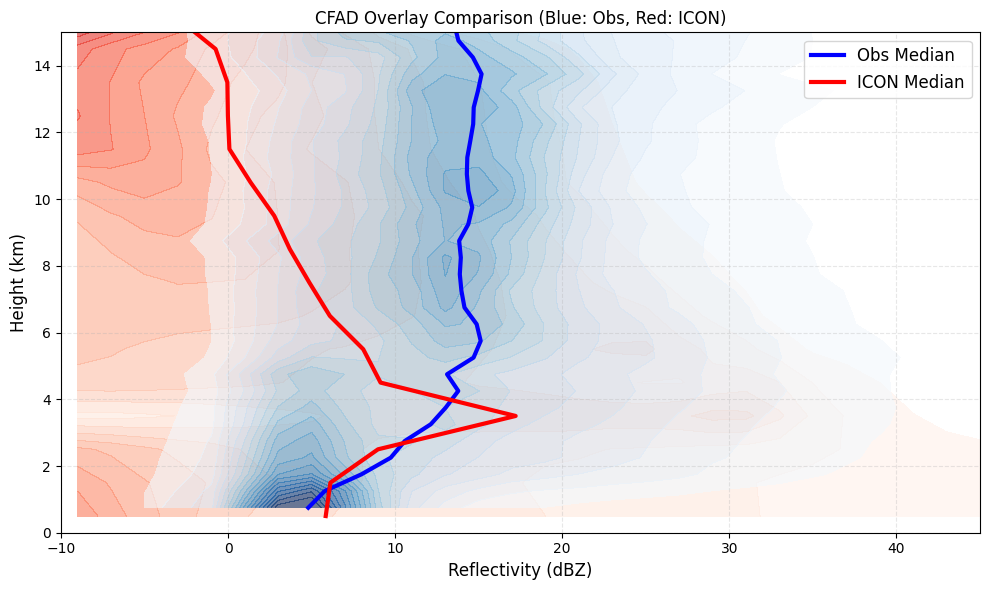

In [57]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot ICON with transparency
cf_icon = ax.contourf(D_4sip, H_4sip, freq_percent_masked_4sip.T, 
                      levels=lev, cmap='Reds', alpha=0.6, extend='max')
# Plot observations with transparency
cf_obs = ax.contourf(D_obs, H_obs, freq_percent_obs_masked.T, 
                     levels=lev, cmap='Blues', alpha=0.6, extend='max')

# Add median lines
ax.plot(median_dbz_obs, median_heights_obs, 'b-', linewidth=3, label='Obs Median')
ax.plot(median_dbz_4sip, median_heights_4sip, 'r-', linewidth=3, label='ICON Median')

ax.set_xlabel('Reflectivity (dBZ)', fontsize=fnt)
ax.set_ylabel('Height (km)', fontsize=fnt)
ax.set_title('CFAD Overlay Comparison (Blue: Obs, Red: ICON)', fontsize=fnt)
ax.set_xlim(dbz_lim)
ax.set_ylim(height_lim)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='upper right', fontsize=fnt)

plt.tight_layout()
plt.savefig('cfad_overlay_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

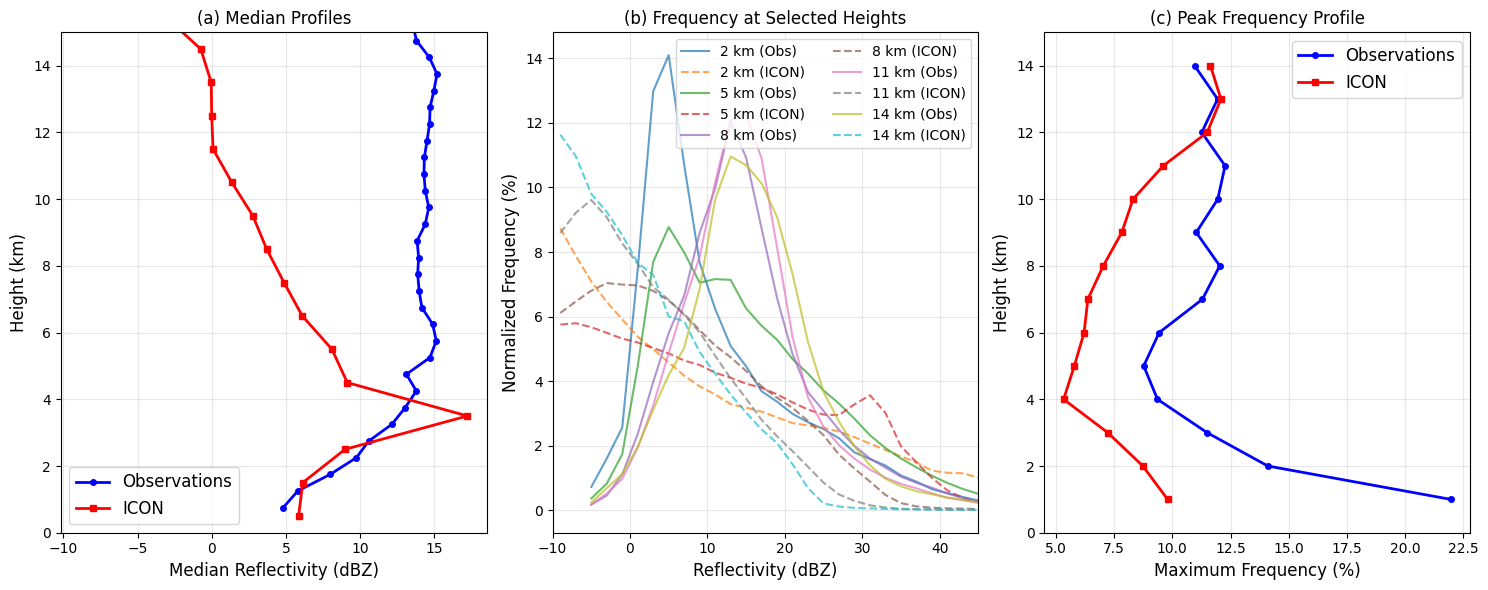

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Panel 1: Median profiles
axes[0].plot(median_dbz_obs, median_heights_obs, 'b-o', linewidth=2, label='Observations', markersize=4)
axes[0].plot(median_dbz_4sip, median_heights_4sip, 'r-s', linewidth=2, label='ICON', markersize=4)
axes[0].set_xlabel('Median Reflectivity (dBZ)', fontsize=fnt)
axes[0].set_ylabel('Height (km)', fontsize=fnt)
axes[0].set_title('(a) Median Profiles', fontsize=fnt)
axes[0].set_ylim(height_lim)
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=fnt)

# Panel 2: Frequency at specific heights
heights_to_compare = [2, 5, 8, 11, 14]  # km
for h in heights_to_compare:
    # Find closest height index
    h_idx_obs = np.argmin(np.abs(height_obs_centers - h))
    h_idx_icon = np.argmin(np.abs(height_4sip_centers - h))
    
    axes[1].plot(dbz_obs_centers, freq_percent_obs_masked[h_idx_obs, :], 
                 label=f'{h} km (Obs)', linestyle='-', alpha=0.7)
    axes[1].plot(dbz_4sip_centers, freq_percent_masked_4sip[h_idx_icon, :], 
                 label=f'{h} km (ICON)', linestyle='--', alpha=0.7)

axes[1].set_xlabel('Reflectivity (dBZ)', fontsize=fnt)
axes[1].set_ylabel('Normalized Frequency (%)', fontsize=fnt)
axes[1].set_title('(b) Frequency at Selected Heights', fontsize=fnt)
axes[1].set_xlim(dbz_lim)
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=fnt-2, ncol=2)

# Panel 3: Statistics comparison
stats_heights = np.arange(1, 15, 1)
max_freq_obs = []
max_freq_icon = []

for h in stats_heights:
    h_idx_obs = np.argmin(np.abs(height_obs_centers - h))
    h_idx_icon = np.argmin(np.abs(height_4sip_centers - h))
    
    max_freq_obs.append(np.max(freq_percent_obs_masked[h_idx_obs, :]))
    max_freq_icon.append(np.max(freq_percent_masked_4sip[h_idx_icon, :]))

axes[2].plot(max_freq_obs, stats_heights, 'b-o', linewidth=2, label='Observations', markersize=4)
axes[2].plot(max_freq_icon, stats_heights, 'r-s', linewidth=2, label='ICON', markersize=4)
axes[2].set_xlabel('Maximum Frequency (%)', fontsize=fnt)
axes[2].set_ylabel('Height (km)', fontsize=fnt)
axes[2].set_title('(c) Peak Frequency Profile', fontsize=fnt)
axes[2].set_ylim(height_lim)
axes[2].grid(True, alpha=0.3)
axes[2].legend(fontsize=fnt)

plt.tight_layout()
plt.savefig('cfad_quantitative_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [32]:

# Filter data
stime = '2019-09-30T06:00:00.000000000'
etime = '2019-09-30T20:00:00.000000000'
lon_min, lon_max = 75, 76
lat_min, lat_max = 17, 18

mask = (
    (np.rad2deg(ds_4sip.clon) >= lon_min) &
    (np.rad2deg(ds_4sip.clon) <= lon_max) &
    (np.rad2deg(ds_4sip.clat) >= lat_min) &
    (np.rad2deg(ds_4sip.clat) <= lat_max)
).compute()

ds_4sip_refl = ds_4sip.where(mask, drop=True)
ds_4sip_refl = ds_4sip_refl.sel(time=slice(stime, etime))

# Apply reflectivity filter
filt_refl_4sip = xr.where((ds_4sip_refl.dbz > -10.), ds_4sip_refl.dbz, np.nan)
alt_4sip_km = 1.e-3 * ds_4sip_refl.z_mc

Processing data in chunks...
Processing time steps 0-10/29
Histogram calculation complete!
Calculating median and mode...
Statistics calculation complete!


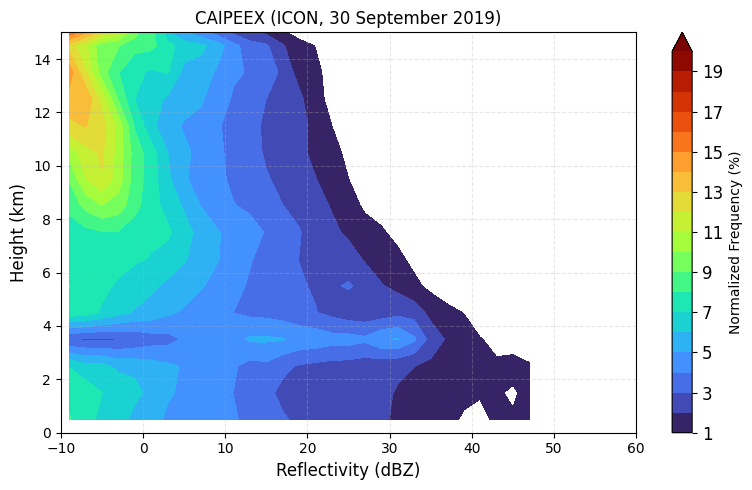

In [33]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


# =====================================================
# Create CFAD - Optimized approach
# =====================================================

# Define bins
dbz_bins = np.arange(-14, 50, 2)     # 2 dBZ bins
height_bins = np.arange(0, 20, 1.0)  # 1 km bins

# Initialize histogram
hist_4sip_2d = np.zeros((len(height_bins)-1, len(dbz_bins)-1))

print("Processing data in chunks...")
n_times = len(ds_4sip_refl.time)

# Process data in chunks by time to avoid memory overload
chunk_size = 10  # Process 10 time steps at a time
for start_idx in range(0, n_times, chunk_size):
    end_idx = min(start_idx + chunk_size, n_times)
    
    if start_idx % 50 == 0:
        print(f"Processing time steps {start_idx}-{end_idx}/{n_times}")
    
    # Load chunk of data
    refl_chunk = filt_refl_4sip.isel(time=slice(start_idx, end_idx)).values
    height_chunk = alt_4sip_km.isel(time=slice(start_idx, end_idx)).values
    
    # Flatten
    refl_flat = refl_chunk.flatten()
    height_flat = height_chunk.flatten()
    
    # Remove NaNs
    valid_mask = ~np.isnan(refl_flat) & ~np.isnan(height_flat)
    refl_valid = refl_flat[valid_mask]
    height_valid = height_flat[valid_mask]
    
    # Add to cumulative histogram
    if len(refl_valid) > 0:
        hist_chunk, _, _ = np.histogram2d(
            height_valid, refl_valid,
            bins=[height_bins, dbz_bins]
        )
        hist_4sip_2d += hist_chunk
    
    # Clear memory
    del refl_chunk, height_chunk, refl_flat, height_flat, valid_mask

print("Histogram calculation complete!")

# Normalize by altitude (each height level sums to 1)
hist_4sip_normalized = np.zeros_like(hist_4sip_2d)
for i in range(hist_4sip_2d.shape[0]):
    row_sum_4sip = hist_4sip_2d[i, :].sum()
    if row_sum_4sip > 0:
        hist_4sip_normalized[i, :] = hist_4sip_2d[i, :] / row_sum_4sip

# Convert to percentage
freq_percent_4sip = hist_4sip_normalized * 100

# Mask zeros for better visualization
freq_percent_masked_4sip = np.ma.masked_where(freq_percent_4sip == 0, freq_percent_4sip)

# =====================================================
# Calculate median and mode (using chunked approach)
# =====================================================

print("Calculating median and mode...")

# Store values by height bin for median/mode calculation
height_bin_data = {i: [] for i in range(len(height_bins)-1)}

for start_idx in range(0, n_times, chunk_size):
    end_idx = min(start_idx + chunk_size, n_times)
    
    refl_chunk = filt_refl_4sip.isel(time=slice(start_idx, end_idx)).values
    height_chunk = alt_4sip_km.isel(time=slice(start_idx, end_idx)).values
    
    refl_flat = refl_chunk.flatten()
    height_flat = height_chunk.flatten()
    
    valid_mask = ~np.isnan(refl_flat) & ~np.isnan(height_flat)
    refl_valid = refl_flat[valid_mask]
    height_valid = height_flat[valid_mask]
    
    # Assign to height bins
    for i in range(len(height_bins)-1):
        h_min = height_bins[i]
        h_max = height_bins[i+1]
        mask_h = (height_valid >= h_min) & (height_valid < h_max)
        if mask_h.sum() > 0:
            height_bin_data[i].extend(refl_valid[mask_h].tolist())
    
    del refl_chunk, height_chunk, refl_flat, height_flat, valid_mask

# Calculate median from collected data
median_dbz_4sip = []
median_heights_4sip = []
for i in range(len(height_bins)-1):
    if len(height_bin_data[i]) > 0:
        median_val_4sip = np.median(height_bin_data[i])
        median_dbz_4sip.append(median_val_4sip)
        median_heights_4sip.append((height_bins[i] + height_bins[i+1]) / 2.)

# Find mode (most frequent reflectivity) at each height
mode_dbz_4sip = []
mode_heights_4sip = []
for i in range(len(height_bins)-1):
    if hist_4sip_normalized[i, :].sum() > 0:
        max_idx_4sip = np.argmax(hist_4sip_normalized[i, :])
        mode_dbz_4sip.append((dbz_bins[max_idx_4sip] + dbz_bins[max_idx_4sip+1]) / 2)
        mode_heights_4sip.append((height_bins[i] + height_bins[i+1]) / 2)

print("Statistics calculation complete!")

# =====================================================
# Plot CFAD
# =====================================================

fnt = 12
lev = np.linspace(1, 20, 20)
fig, ax = plt.subplots(figsize=(8, 5))

# Create bin centers for plotting
height_4sip_centers = (height_bins[:-1] + height_bins[1:]) / 2
dbz_4sip_centers = (dbz_bins[:-1] + dbz_bins[1:]) / 2
H_4sip, D_4sip = np.meshgrid(height_4sip_centers, dbz_4sip_centers)

# Filled contours
contourf = ax.contourf(D_4sip, H_4sip, freq_percent_masked_4sip.T, 
                       levels=lev, 
                       cmap='turbo', 
                       extend='max')

# Colorbar
cbar = plt.colorbar(contourf, ax=ax, label='Normalized Frequency (%)')
cbar.ax.tick_params(labelsize=fnt)

# Labels and title
ax.set_xlabel('Reflectivity (dBZ)', fontsize=fnt)
ax.set_ylabel('Height (km)', fontsize=fnt)
ax.set_title('CAIPEEX (ICON, 30 September 2019)', fontsize=fnt)

# Set axis limits
ax.set_xlim([-10, 60])
ax.set_ylim([0, 15])

# Grid
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()

# Save figure
#plt.savefig('cfad_4sip_reflectivity.png', dpi=300, bbox_inches='tight')
#print("CFAD plot saved as 'cfad_4sip_reflectivity.png'")

plt.show()

# =====================================================
# Print statistics
# =====================================================

#total_points = hist_4sip_2d.sum()
#print("\nCFAD Statistics:")
#print(f"Total valid points: {int(total_points):,}")
#print(f"Max normalized frequency: {freq_percent_masked_4sip.max():.2f}%")
#print(f"Number of time steps processed: {n_times}")

In [9]:

print(ds_refl_obs.lon.min().values)
print(ds_refl_obs.lon.max().values)
print(ds_refl_obs.lat.min().values)
print(ds_refl_obs.lat.max().values)


74.99989
75.99277
16.99984
17.999884


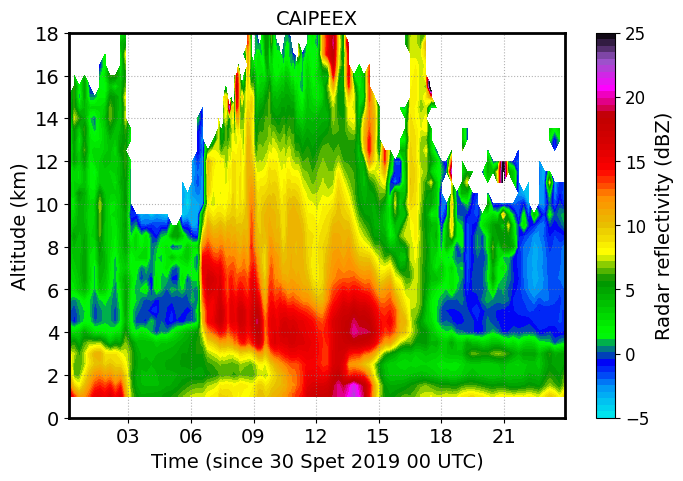

In [7]:

from matplotlib.colors import ListedColormap


ds_refl_obs = xr.open_dataset('/work/bk1415/b382718/output/caipeex/observations/radar_data/Case20190930_RADAR_DBZc_4D.nc')

# the region corresponding to the B200 aircraft
lon_min, lon_max = 75, 76
lat_min, lat_max = 17, 18

# Apply the condition to select data within the desired region
ds_refl_obs = ds_refl_obs.where(
    (ds_refl_obs.lon >= lon_min) & (ds_refl_obs.lon <= lon_max) &
    (ds_refl_obs.lat >= lat_min) & (ds_refl_obs.lat <= lat_max), 
    drop=True  # Drop values outside the region
)

#ds_refl_obs = ds_refl_obs.sel(lon=slice(75.25,76),lat=slice(16.5,17.75))

ds_refl_obs['lon'] = xr.where(ds_refl_obs.lon > 0., ds_refl_obs.lon, np.nan)
ds_refl_obs['lat'] = xr.where(ds_refl_obs.lat > 0., ds_refl_obs.lat, np.nan)

ht_obs = 1.e-3*ds_refl_obs.alt;
time_obs = ds_refl_obs.time;
zrefl_obs = ds_refl_obs.dbzc;


colors = ['cyan', 'deepskyblue', 'mediumblue', 'lawngreen', 'limegreen', 'green', 'yellow', 'gold', 'goldenrod', 
          'coral', 'orangered', 'red', 'lightcoral', 'magenta', 'darkorchid', 'pink']
cmap = ListedColormap(colors)

lnwdth = 3
fontsize = 14
lev = np.linspace(-5, 25, 60)

plt.figure(figsize=(8, 5))
plt.style.use('default')

contour = plt.contourf(time_obs, ht_obs, zrefl_obs.mean(dim=('lon','lat')).T, cmap='pyart_NWSRef', levels=lev)
colorbar = plt.colorbar(contour, ticks=[-5, 0, 5, 10, 15, 20, 25], label='Radar reflectivity (dBZ)')
colorbar.ax.tick_params(labelsize=12)
colorbar.set_label(label='Radar reflectivity (dBZ)', size=fontsize)
plt.xlabel('Time (since 30 Spet 2019 00 UTC)', fontsize=fontsize)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Format to show only hours
plt.xticks(fontsize=fontsize)
plt.ylim([0, 18])
plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18], fontsize=fontsize)
plt.ylabel('Altitude (km)', fontsize=fontsize)
plt.title('CAIPEEX', fontsize=fontsize)
plt.grid(True, linestyle=':', color='grey', alpha=0.6)

for spine in ['top', 'bottom', 'left', 'right']:
    plt.gca().spines[spine].set_visible(True)
    plt.gca().spines[spine].set_linewidth(2)
    plt.gca().spines[spine].set_color('black')

plt.show()

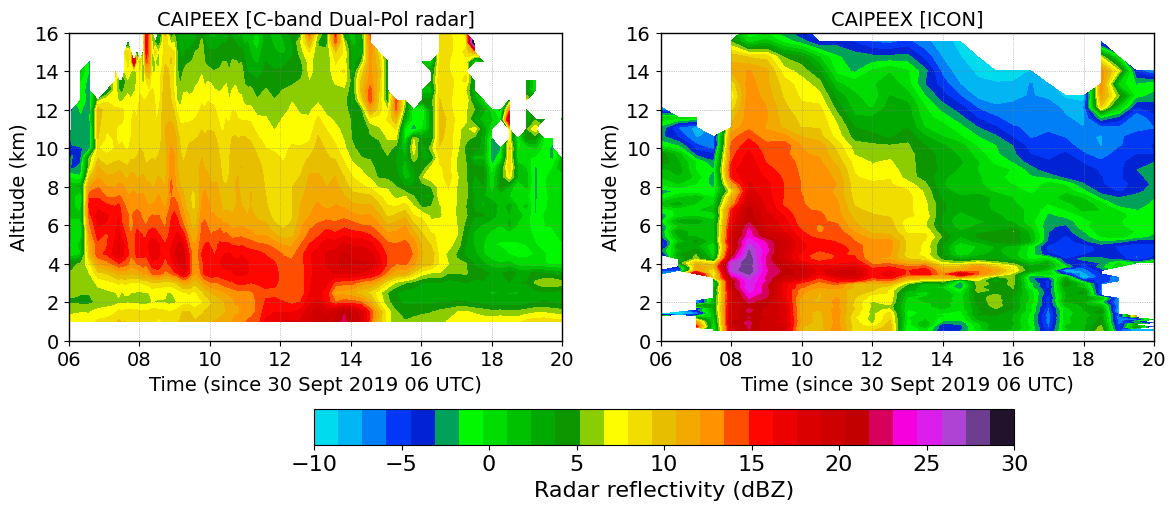

In [26]:

### Obs
ds_refl_obs = xr.open_dataset('/work/bk1415/b382718/output/caipeex/observations/radar_data/Case20190930_RADAR_DBZc_4D.nc')

# the region corresponding to the B200 aircraft
lon_min, lon_max = 75, 76
lat_min, lat_max = 17, 18

# Apply the condition to select data within the desired region
ds_refl_obs = ds_refl_obs.where(
    (ds_refl_obs.lon >= lon_min) & (ds_refl_obs.lon <= lon_max) &
    (ds_refl_obs.lat >= lat_min) & (ds_refl_obs.lat <= lat_max), 
    drop=True  # Drop values outside the region
)

#ds_refl_obs = ds_refl_obs.sel(lon=slice(75.25,76),lat=slice(16.5,17.75))

ds_refl_obs['lon'] = xr.where(ds_refl_obs.lon > 0., ds_refl_obs.lon, np.nan)
ds_refl_obs['lat'] = xr.where(ds_refl_obs.lat > 0., ds_refl_obs.lat, np.nan)

ht_obs = 1.e-3*ds_refl_obs.alt;
time_obs = ds_refl_obs.time;
zrefl_obs = ds_refl_obs.dbzc;


avg_refl_obs = ds_refl_obs.dbzc.where(ds_refl_obs.dbzc > -10).mean(dim=('lon','lat'))

##########################################################
#### ICON
lon_min, lon_max = 75, 76
lat_min, lat_max = 17, 18
mask = (
    (np.rad2deg(ds_4sip.clon) >= lon_min) &
    (np.rad2deg(ds_4sip.clon) <= lon_max) &
    (np.rad2deg(ds_4sip.clat) >= lat_min) &
    (np.rad2deg(ds_4sip.clat) <= lat_max)
).compute()

ds_4sip_refl = ds_4sip.where(mask, drop=True)

avg_ht = 1.e-3*ds_4sip_refl.z_mc.mean(dim=('time','ncells'))
avg_refl_4sip = ds_4sip_refl.dbz.where(ds_4sip_refl.dbz > -10).mean(dim=('ncells'))

####################################################

colors = ['cyan', 'deepskyblue', 'mediumblue', 'lawngreen', 'limegreen', 'green', 'yellow', 'gold', 'goldenrod', 
          'coral', 'orangered', 'red', 'lightcoral', 'magenta', 'darkorchid', 'pink']
cmap = ListedColormap(colors)

lnwdth = 3
fnt = 14
lev = np.linspace(-10, 30, 30)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
cnt1 = plt.contourf(time_obs, ht_obs, avg_refl_obs.T, cmap='pyart_NWSRef', levels=lev)
#colorbar = plt.colorbar(cnt1, ticks=[-10, -5, 0, 5, 10, 15, 20, 25, 30], label='Radar reflectivity (dBZ)')
#colorbar.ax.tick_params(labelsize=12)
#colorbar.set_label(label='Radar reflectivity (dBZ)', size=fontsize)

plt.xlabel('Time (since 30 Sept 2019 06 UTC)', fontsize=fnt)


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
start_date = datetime(2019, 9, 30, 6, 0) 
end_date = datetime(2019, 9, 30, 20, 0)

plt.xlim(start_date, end_date)

plt.ylim([0, 16])
plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16], fontsize=fnt)
plt.ylabel('Altitude (km)', fontsize=fnt)

plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)

plt.title('CAIPEEX [C-band Dual-Pol radar]', fontsize=fnt)

plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)

for spine in ['top', 'bottom', 'left', 'right']:
    plt.gca().spines[spine].set_visible(True)
    plt.gca().spines[spine].set_linewidth(1)
    plt.gca().spines[spine].set_color('black')
    

plt.subplot(1,2,2)
cnt2 = plt.contourf(ds_4sip_refl.time, avg_ht, avg_refl_4sip.T, cmap='pyart_NWSRef', levels=lev)
#colorbar = plt.colorbar(cnt2, ticks=[-10, -5, 0, 5, 10, 15, 20, 25, 30], label='Radar reflectivity (dBZ)')
#colorbar.ax.tick_params(labelsize=12)
#colorbar.set_label(label='Radar reflectivity (dBZ)', size=fontsize)

plt.xlabel('Time (since 30 Sept 2019 06 UTC)', fontsize=fnt)


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
start_date = datetime(2019, 9, 30, 6, 0) 
end_date = datetime(2019, 9, 30, 20, 0)

plt.xlim(start_date, end_date)

plt.ylim([0, 16])
plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16], fontsize=fnt)
plt.ylabel('Altitude (km)', fontsize=fnt)

plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)

plt.title('CAIPEEX [ICON]', fontsize=fnt)

plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)

for spine in ['top', 'bottom', 'left', 'right']:
    plt.gca().spines[spine].set_visible(True)
    plt.gca().spines[spine].set_linewidth(1.)
    plt.gca().spines[spine].set_color('black')
    

fig = plt.gcf()  # Get the current figure
#cbar_ax1 = fig.add_axes([0.25, 0.25, 0.5, 0.04])  # [left, bottom, width, height]
cbar_ax1 = fig.add_axes([0.3, -0.15, 0.5, 0.09])
cbar = fig.colorbar(cnt2, cax=cbar_ax1, ticks=[-10, -5, 0, 5, 10, 15, 20, 25, 30], orientation='horizontal')
#cbar = fig.colorbar(cnt2, cax=cbar_ax1, ticks=[0, 0.01, 0.02, 0.03, 0.04], orientation='horizontal')
cbar.set_label('Radar reflectivity (dBZ)', fontsize=fnt+2)
#cbar.set_label('LWC (g m$^{-3}$)', fontsize=fnt+2)
cbar.ax.tick_params(labelsize=fnt+2)

plt.show()




## Lat-Lon observed Radar

In [16]:
ds_refl_obs

<xarray.Dataset> Size: 238MB
Dimensions:  (time: 125, alt: 40, lat: 112, lon: 106)
Coordinates:
  * time     (time) datetime64[ns] 1kB 2019-09-30T00:09:32 ... 2019-09-30T23:...
  * alt      (alt) float32 160B 500.0 1e+03 1.5e+03 ... 1.9e+04 1.95e+04 2e+04
    lat      (lat, lon) float32 47kB 17.0 17.0 17.0 17.0 ... 18.0 18.0 18.0 18.0
    lon      (lat, lon) float32 47kB 75.0 75.01 75.02 ... 75.97 75.98 75.99
Data variables:
    dbzc     (time, alt, lat, lon) float32 237MB nan nan nan nan ... nan nan nan
Attributes:
    description:  Reflectivity (masked with mentioned thresholds) extracted f...
    creator:      Soumya Samanta

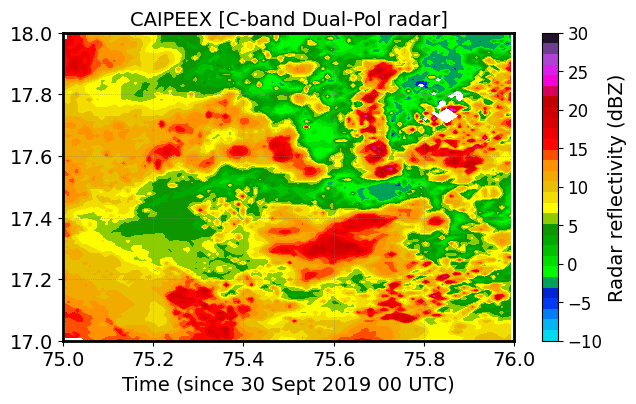

In [28]:

ds_refl_obs = xr.open_dataset('/work/bk1415/b382718/output/caipeex/observations/radar_data/Case20190930_RADAR_DBZc_4D.nc')

# the region corresponding to the B200 aircraft
lon_min, lon_max = 75, 76
lat_min, lat_max = 17, 18

# Apply the condition to select data within the desired region
ds_refl_obs = ds_refl_obs.where(
    (ds_refl_obs.lon >= lon_min) & (ds_refl_obs.lon <= lon_max) &
    (ds_refl_obs.lat >= lat_min) & (ds_refl_obs.lat <= lat_max), 
    drop=True  # Drop values outside the region
)


avg_refl_obs = xr.where(ds_refl_obs.dbzc > -10., ds_refl_obs.dbzc, np.nan) #.mean(dim=('ncells'))

#avg_refl_obs = avg_refl_obs.mean(dim=('time','alt'))



colors = ['cyan', 'deepskyblue', 'mediumblue', 'lawngreen', 'limegreen', 'green', 'yellow', 'gold', 'goldenrod', 
          'coral', 'orangered', 'red', 'lightcoral', 'magenta', 'darkorchid', 'pink']
cmap = ListedColormap(colors)

lnwdth = 3
fontsize = 14
lev = np.linspace(-10, 30, 30)

plt.figure(figsize=(16, 4))

plt.subplot(1,2,1)
contour = plt.contourf(ds_refl_obs.lon, ds_refl_obs.lat, avg_refl_obs.mean(dim=('time','alt')), cmap='pyart_NWSRef', levels=lev)
colorbar = plt.colorbar(contour, ticks=[-10, -5, 0, 5, 10, 15, 20, 25, 30], label='Radar reflectivity (dBZ)')
colorbar.ax.tick_params(labelsize=12)
colorbar.set_label(label='Radar reflectivity (dBZ)', size=fontsize)

plt.xlabel('Time (since 30 Sept 2019 00 UTC)', fontsize=fontsize)


plt.xlim(75, 76)
plt.ylim(17, 18)

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.title('CAIPEEX [C-band Dual-Pol radar]', fontsize=fontsize)

plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)

for spine in ['top', 'bottom', 'left', 'right']:
    plt.gca().spines[spine].set_visible(True)
    plt.gca().spines[spine].set_linewidth(2)
    plt.gca().spines[spine].set_color('black')

plt.show()

## CFAD of ICON and Obs RADAR

In [14]:
ds_refl_obs = xr.open_dataset('/work/bk1415/b382718/output/caipeex/observations/radar_data/Case20190930_RADAR_DBZc_4D.nc')

# the region corresponding to the B200 aircraft
lon_min, lon_max = 75, 76
lat_min, lat_max = 17, 18

# Apply the condition to select data within the desired region
ds_refl_obs = ds_refl_obs.where(
    (ds_refl_obs.lon >= lon_min) & (ds_refl_obs.lon <= lon_max) &
    (ds_refl_obs.lat >= lat_min) & (ds_refl_obs.lat <= lat_max), 
    drop=True  # Drop values outside the region
)

#ds_refl_obs = ds_refl_obs.sel(lon=slice(75.25,76),lat=slice(16.5,17.75))

ds_refl_obs['lon'] = xr.where(ds_refl_obs.lon > 0., ds_refl_obs.lon, np.nan)
ds_refl_obs['lat'] = xr.where(ds_refl_obs.lat > 0., ds_refl_obs.lat, np.nan)

ht_obs = 1.e-3*ds_refl_obs.alt;
time_obs = ds_refl_obs.time;
zrefl_obs = ds_refl_obs.dbzc;

lon = ds_refl_obs.lon.mean(axis=1)
lat = ds_refl_obs.lat.mean(axis=0)

refl_obs = xr.where(ds_refl_obs.dbzc > -10., ds_refl_obs.dbzc, np.nan)

############
filt_refl_obs = refl_obs.mean(dim=('lon','lat'))
alt_km = ht_obs


In [15]:

print(filt_refl_obs.min().values, filt_refl_obs.max().values)

-4.830891 34.56928


In [16]:
print(filt_refl_obs.shape, alt_km.shape)

(125, 40) (40,)


In [16]:

nbin=25;
################## C-band Dual-Pol radar in CAIPEEX  #################

# Altitude and refl_obs are not the same dimension, so,
alt_2d = np.broadcast_to(alt_km.values, filt_refl_obs.shape)

# 3. Flatten both arrays to 1D for histogramming
refl_obs_flat = filt_refl_obs.values.flatten()
alt_obs_flat = alt_2d.flatten()

# 4. Filter out NaNs and physically unrealistic values
mask = (~np.isnan(refl_obs_flat)) & (~np.isnan(alt_obs_flat)) & (refl_obs_flat > -10) & (alt_obs_flat >= 0)
refl_obs_flat = refl_obs_flat[mask]
alt_obs_flat = alt_obs_flat[mask]

# 5. Define bins
#dbz_bins = np.arange(-10, 81, 3)   # dBZ bins from -10 to 80 in 1 dBZ steps
#alt_bins = np.arange(0., 20.1, 1.0) # Altitude bins from 0 to 15 km in 0.1 km steps

dbz_obs_bins = np.linspace(-10, 31, nbin)   # dBZ bins from -10 to 80 in 1 dBZ steps
alt_obs_bins = np.linspace(0, 16.1, nbin)   # Altitude bins from 0 to 15 km in 0.1 km steps

#dbz_obs_bins = np.linspace(-10, 31, nbin)   # dBZ bins from -10 to 80 in 1 dBZ steps
#alt_obs_bins = np.linspace(0, 16.1, nbin)   # Altitude bins from 0 to 15 km in 0.1 km steps

dbz_sr1_bins = np.linspace(np.nanmin(refl_obs_flat), np.nanmax(refl_obs_flat), nbin)   # dBZ bins from -10 to 80 in 1 dBZ steps
alt_sr1_bins = np.linspace(np.nanmin(alt_obs_flat), np.nanmax(alt_obs_flat), nbin)     # Altitude bins from 0 to 15 km in 0.1 km steps

#dbz_bins = np.linspace(-10, 81, 25)   # dBZ bins from -10 to 80 in 1 dBZ steps
#alt_bins = np.linspace(0, 20.1, 25) # Altitude bins from 0 to 15 km in 0.1 km steps

# 2D Histogram (CFAD)
cfad_refl_obs, xedges, yedges = np.histogram2d(refl_obs_flat, alt_obs_flat, bins=[dbz_obs_bins, alt_obs_bins])

cfad_refl_obs_norm = cfad_refl_obs / np.sum(cfad_refl_obs, axis=0, keepdims=True) # normalized by height


# 6. 2D Histogram (CFAD)
cfad_obs, xedges, yedges = np.histogram2d(refl_obs_flat, alt_obs_flat, bins=[dbz_obs_bins, alt_obs_bins])

med_refl_obs = filt_refl_obs.median('time')
median_refl_obs = filt_refl_obs.median('time')
med_refl_obs = filt_refl_obs.median('time')
mean_alt_km_obs = alt_km.values

################## End C-band Dual-Pol radar CFAD #############

################## ICON #######################

ds_filt = ds_4sip.sel(ncells=mask_ncells_caipeex)#, time=slice('2022-08-02T19:00:00.000000000','2022-08-02T20:00:00.000000000'))
filt_refl_4sip = xr.where(ds_filt.dbz > -10., ds_filt.dbz, np.nan);
alt_4sip_km = 1.e-3*ds_filt.z_mc

# 3. Flatten both arrays to 1D for histogram
refl_4sip_flat = filt_refl_4sip.values.flatten()
alt_4sip_flat = alt_4sip_km.values.flatten()

# 4. Filter out NaNs and physically unrealistic values
mask_4sip = (~np.isnan(refl_4sip_flat)) & (~np.isnan(alt_4sip_flat)) & (refl_4sip_flat > -10) & (alt_4sip_flat >= 0)
refl_4sip_flat = refl_4sip_flat[mask_4sip]
alt_4sip_flat = alt_4sip_flat[mask_4sip]


dbz_4sip_bins = np.linspace(np.nanmin(refl_4sip_flat), np.nanmax(refl_4sip_flat), nbin)   # dBZ bins from -10 to 80 in 1 dBZ steps
alt_4sip_bins = np.linspace(np.nanmin(alt_4sip_flat), np.nanmax(alt_4sip_flat), nbin) # Altitude bins from 0 to 15 km in 0.1 km steps

# 2D Histogram (CFAD)
cfad_4sip, xedges_4sip, yedges_4sip = np.histogram2d(refl_4sip_flat, alt_4sip_flat, bins=[dbz_4sip_bins, alt_4sip_bins])

#cfad_4sip_norm = cfad_4sip / np.sum(cfad_4sip, axis=0, keepdims=True) # normalized by height
col_sum = np.sum(cfad_4sip, axis=0, keepdims=True)
cfad_4sip_norm = np.where(col_sum != 0, cfad_4sip / col_sum, np.nan)

med_refl_4sip = filt_refl_4sip.median(dim=('time','ncells'))
median_refl_4sip = filt_refl_4sip.median(dim=('time','ncells'))
mean_alt_4sip = alt_4sip_km.mean(dim=('time','ncells'))

med_refl_4sip = xr.where(mean_alt_4sip < 13.35, med_refl_4sip, np.nan)

median_refl_4sip = median_refl_4sip.values
mean_alt_4sip = mean_alt_4sip.values

################## End ICON #################


In [20]:

################## ICON #################
#ds_4sip2 = ds_4sip.copy(deep=True)
ds_filt = ds_4sip.sel(ncells=mask_ncells_caipeex)#, time=slice('2011-05-11T17:00:00.000000000','2011-05-12T00:00:00.000000000'))
filt_refl_4sip = xr.where(ds_filt.dbz > -10., ds_filt.dbz, np.nan);
alt_4sip_km = 1.e-3*ds_filt.z_mc

# 3. Flatten both arrays to 1D for histogramming
refl_4sip_flat = filt_refl_4sip.values.flatten()
alt_4sip_flat = alt_4sip_km.values.flatten()

# 4. Filter out NaNs and physically unrealistic values
mask_4sip = (~np.isnan(refl_4sip_flat)) & (~np.isnan(alt_4sip_flat)) & (refl_4sip_flat > -10) & (alt_4sip_flat >= 0)
refl_4sip_flat = refl_4sip_flat[mask_4sip]
alt_4sip_flat = alt_4sip_flat[mask_4sip]

# 5. Define bins
#refl_4sip_bins = np.arange(-10, 81, 3)   # dBZ bins from -10 to 80 in 1 dBZ steps
#alt_4sip_bins = np.arange(0.2, 20.1, 1) # Altitude bins from 0 to 15 km in 0.1 km steps

refl_4sip_bins = np.linspace(-10., 81, 25)   # dBZ bins from -10 to 80 in 1 dBZ steps
alt_4sip_bins = np.linspace(0., 16.1, 25) # Altitude bins from 0 to 15 km in 0.1 km steps

# 6. 2D Histogram (CFAD)
cfad_4sip, xedges_4sip, yedges_4sip = np.histogram2d(refl_4sip_flat, alt_4sip_flat, bins=[refl_4sip_bins, alt_4sip_bins])

################## End ICON #################

med_refl_4sip = filt_refl_4sip.median(dim=('time','ncells'))
mean_alt_4sip = alt_4sip_km.mean(dim=('time','ncells'))

#med_refl_4sip = xr.where(mean_alt_4sip < 13.35, med_refl_4sip, np.nan)

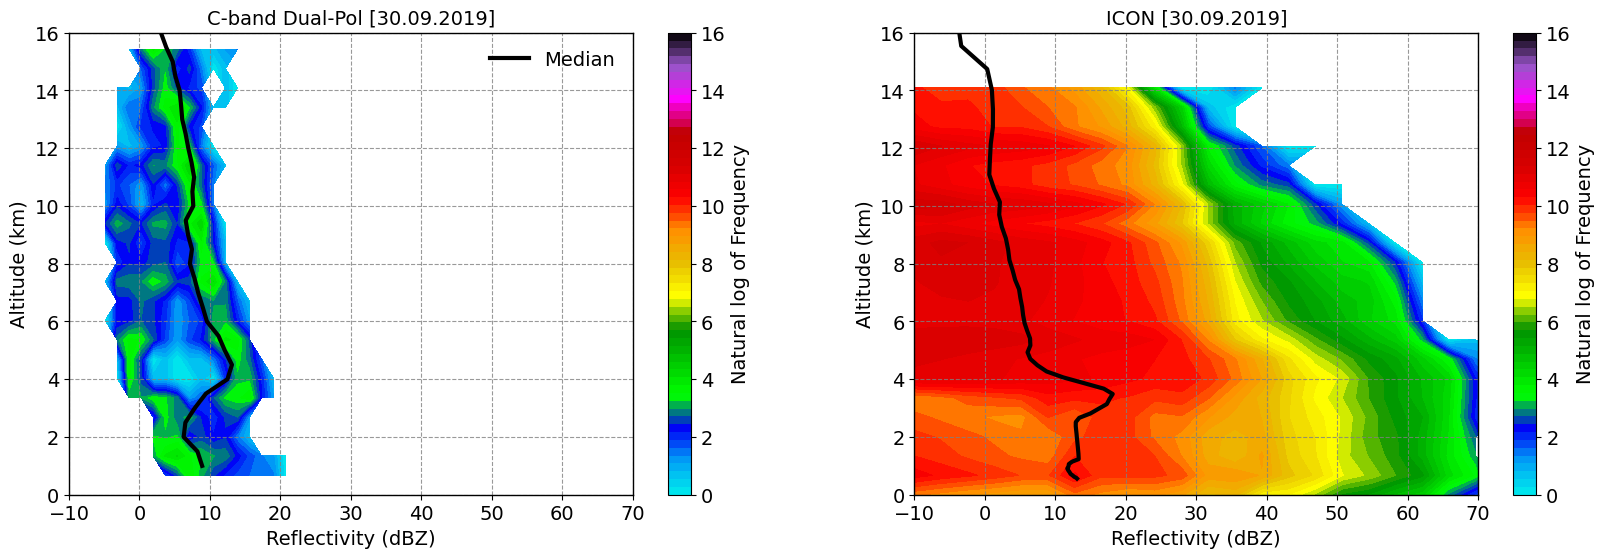

In [23]:
ln=3
fnt=14
lev=np.linspace(0,16,60)
# 7. Plot CFAD

plt.figure(figsize=(20, 6))
plt.style.use('default')
plt.subplot(1,2,1)
#X, Y = np.meshgrid(dbz_bins, alt_bins)
#pcm = plt.pcolormesh(X, Y, np.log(cfad.T), cmap='pyart_NWSRef', shading='auto')


pcm = plt.contourf(dbz_bins[:-1], alt_bins[:-1], np.log(cfad.T), cmap='pyart_NWSRef', levels=lev)  # altitude is adjusted to match the actual  
                                                                                                      # station (34.022°N, 106.89°W) altitude (~1.1 km) 
#pcm = plt.contourf(dbz_bins[:-1], alt_bins[:-1], np.log(cfad.T), cmap='HomeyerRainbow', levels=lev)

plt.plot(med_refl_obs, mean_alt_km_obs, 'k-', linewidth=ln, label='Median')
plt.xlabel('Reflectivity (dBZ)', fontsize=fnt)
plt.ylabel('Altitude (km)', fontsize=fnt)
plt.title('C-band Dual-Pol [30.09.2019]', fontsize=fnt)
cbar = plt.colorbar(pcm, ticks=[0, 2, 4, 6, 8, 10, 12, 14, 16])#, label='Natural log of Frequency')
cbar.ax.tick_params(labelsize=fnt)
cbar.set_label(label='Natural log of Frequency', size=fnt)

plt.ylim(0, 16)
plt.xlim(-10, 70)
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)
plt.grid(True, linestyle='--', color='grey', alpha=0.8)
plt.legend(frameon=False, loc='best', fontsize=fnt)

for spine in ['top', 'bottom', 'left', 'right']:
    plt.gca().spines[spine].set_visible(True)
    plt.gca().spines[spine].set_linewidth(1)
    plt.gca().spines[spine].set_color('black')
    
plt.subplot(1,2,2)
X, Y = np.meshgrid(dbz_bins, alt_bins)
#pcm = plt.pcolormesh(X, Y, np.log(cfad.T), cmap='pyart_NWSRef', shading='auto')


pcm = plt.contourf(refl_4sip_bins[:-1], alt_4sip_bins[:-1], np.log(cfad_4sip.T), cmap='pyart_NWSRef', levels=lev)
#pcm = plt.contourf(dbz_bins[:-1], alt_bins[:-1], np.log(cfad.T), cmap='HomeyerRainbow', levels=lev)

plt.plot(med_refl_4sip, mean_alt_4sip, 'k-', linewidth=ln)
#plt.text(40,14,'11.05.2011 17:00 UTC - 12.05.2011 00:00 UTC', fontsize=fnt)

plt.xlabel('Reflectivity (dBZ)', fontsize=fnt)
plt.ylabel('Altitude (km)', fontsize=fnt)
plt.title('ICON [30.09.2019]', fontsize=fnt)
cbar = plt.colorbar(pcm, ticks=[0, 2, 4, 6, 8, 10, 12, 14, 16])#, label='Natural log of Frequency')
cbar.ax.tick_params(labelsize=fnt)
cbar.set_label(label='Natural log of Frequency', size=fnt)

plt.ylim(0, 16)
plt.xlim(-10, 70)
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)
plt.grid(True, linestyle='--', color='grey', alpha=0.8)

for spine in ['top', 'bottom', 'left', 'right']:
    plt.gca().spines[spine].set_visible(True)
    plt.gca().spines[spine].set_linewidth(1)
    plt.gca().spines[spine].set_color('black')
    
plt.show()

### Normalized CFAD 

In [ ]:
ds_refl_obs = xr.open_dataset('/work/bk1415/b382718/output/caipeex/observations/radar_data/Case20190930_RADAR_DBZc_4D.nc')

# the region corresponding to the B200 aircraft
lon_min, lon_max = 75, 76
lat_min, lat_max = 17, 18

# Apply the condition to select data within the desired region
ds_refl_obs = ds_refl_obs.where(
    (ds_refl_obs.lon >= lon_min) & (ds_refl_obs.lon <= lon_max) &
    (ds_refl_obs.lat >= lat_min) & (ds_refl_obs.lat <= lat_max), 
    drop=True  # Drop values outside the region
)

#ds_refl_obs = ds_refl_obs.sel(lon=slice(75.25,76),lat=slice(16.5,17.75))

ds_refl_obs['lon'] = xr.where(ds_refl_obs.lon > 0., ds_refl_obs.lon, np.nan)
ds_refl_obs['lat'] = xr.where(ds_refl_obs.lat > 0., ds_refl_obs.lat, np.nan)

ht_obs = 1.e-3*ds_refl_obs.alt;
time_obs = ds_refl_obs.time;
zrefl_obs = ds_refl_obs.dbzc;

lon = ds_refl_obs.lon.mean(axis=1)
lat = ds_refl_obs.lat.mean(axis=0)

refl_obs = xr.where(ds_refl_obs.dbzc > -10., ds_refl_obs.dbzc, np.nan)

############
filt_refl_obs = refl_obs.mean(dim=('lon','lat'))
alt_km = ht_obs


In [19]:

nbin=25;
################## C-band Dual-Pol radar in CAIPEEX  #################

# Altitude and refl_obs are not the same dimension, so,
alt_2d = np.broadcast_to(alt_km.values, filt_refl_obs.shape)

# 3. Flatten both arrays to 1D for histogramming
refl_obs_flat = filt_refl_obs.values.flatten()
alt_obs_flat = alt_2d.flatten()

# 4. Filter out NaNs and physically unrealistic values
mask = (~np.isnan(refl_obs_flat)) & (~np.isnan(alt_obs_flat)) & (refl_obs_flat > -10) & (alt_obs_flat >= 0)
refl_obs_flat = refl_obs_flat[mask]
alt_obs_flat = alt_obs_flat[mask]

# 5. Define bins
#dbz_bins = np.arange(-10, 81, 3)   # dBZ bins from -10 to 80 in 1 dBZ steps
#alt_bins = np.arange(0., 20.1, 1.0) # Altitude bins from 0 to 15 km in 0.1 km steps

dbz_obs_bins = np.linspace(-10, 31, nbin)   # dBZ bins from -10 to 80 in 1 dBZ steps
alt_obs_bins = np.linspace(0, 16.1, nbin)   # Altitude bins from 0 to 15 km in 0.1 km steps

#dbz_obs_bins = np.linspace(-10, 31, nbin)   # dBZ bins from -10 to 80 in 1 dBZ steps
#alt_obs_bins = np.linspace(0, 16.1, nbin)   # Altitude bins from 0 to 15 km in 0.1 km steps

dbz_sr1_bins = np.linspace(np.nanmin(refl_obs_flat), np.nanmax(refl_obs_flat), nbin)   # dBZ bins from -10 to 80 in 1 dBZ steps
alt_sr1_bins = np.linspace(np.nanmin(alt_obs_flat), np.nanmax(alt_obs_flat), nbin)     # Altitude bins from 0 to 15 km in 0.1 km steps

#dbz_bins = np.linspace(-10, 81, 25)   # dBZ bins from -10 to 80 in 1 dBZ steps
#alt_bins = np.linspace(0, 20.1, 25) # Altitude bins from 0 to 15 km in 0.1 km steps

# 2D Histogram (CFAD)
cfad_refl_obs, xedges, yedges = np.histogram2d(refl_obs_flat, alt_obs_flat, bins=[dbz_obs_bins, alt_obs_bins])

cfad_refl_obs_norm = cfad_refl_obs / np.sum(cfad_refl_obs, axis=0, keepdims=True) # normalized by height


# 6. 2D Histogram (CFAD)
cfad_obs, xedges, yedges = np.histogram2d(refl_obs_flat, alt_obs_flat, bins=[dbz_obs_bins, alt_obs_bins])

med_refl_obs = filt_refl_obs.median('time')
median_refl_obs = filt_refl_obs.median('time')
mean_refl_obs = filt_refl_obs.mean('time')
med_refl_obs = filt_refl_obs.median('time')
mean_alt_km_obs = alt_km.values

################## End C-band Dual-Pol radar CFAD #############

################## ICON #######################

ds_filt = ds_4sip.sel(ncells=mask_ncells_caipeex)#, time=slice('2022-08-02T19:00:00.000000000','2022-08-02T20:00:00.000000000'))
filt_refl_4sip = xr.where(ds_filt.dbz > -10., ds_filt.dbz, np.nan);
alt_4sip_km = 1.e-3*ds_filt.z_mc

# 3. Flatten both arrays to 1D for histogram
refl_4sip_flat = filt_refl_4sip.values.flatten()
alt_4sip_flat = alt_4sip_km.values.flatten()

# 4. Filter out NaNs and physically unrealistic values
mask_4sip = (~np.isnan(refl_4sip_flat)) & (~np.isnan(alt_4sip_flat)) & (refl_4sip_flat > -10) & (alt_4sip_flat >= 0)
refl_4sip_flat = refl_4sip_flat[mask_4sip]
alt_4sip_flat = alt_4sip_flat[mask_4sip]


dbz_4sip_bins = np.linspace(np.nanmin(refl_4sip_flat), np.nanmax(refl_4sip_flat), nbin)   # dBZ bins from -10 to 80 in 1 dBZ steps
alt_4sip_bins = np.linspace(np.nanmin(alt_4sip_flat), np.nanmax(alt_4sip_flat), nbin) # Altitude bins from 0 to 15 km in 0.1 km steps

# 2D Histogram (CFAD)
cfad_4sip, xedges_4sip, yedges_4sip = np.histogram2d(refl_4sip_flat, alt_4sip_flat, bins=[dbz_4sip_bins, alt_4sip_bins])

#cfad_4sip_norm = cfad_4sip / np.sum(cfad_4sip, axis=0, keepdims=True) # normalized by height
col_sum = np.sum(cfad_4sip, axis=0, keepdims=True)
cfad_4sip_norm = np.where(col_sum != 0, cfad_4sip / col_sum, np.nan)

med_refl_4sip = filt_refl_4sip.median(dim=('time','ncells'))
median_refl_4sip = filt_refl_4sip.median(dim=('time','ncells'))
mean_alt_4sip = alt_4sip_km.mean(dim=('time','ncells'))

med_refl_4sip = xr.where(mean_alt_4sip < 13.35, med_refl_4sip, np.nan)

median_refl_4sip = median_refl_4sip.values
mean_alt_4sip = mean_alt_4sip.values

################## End ICON #################


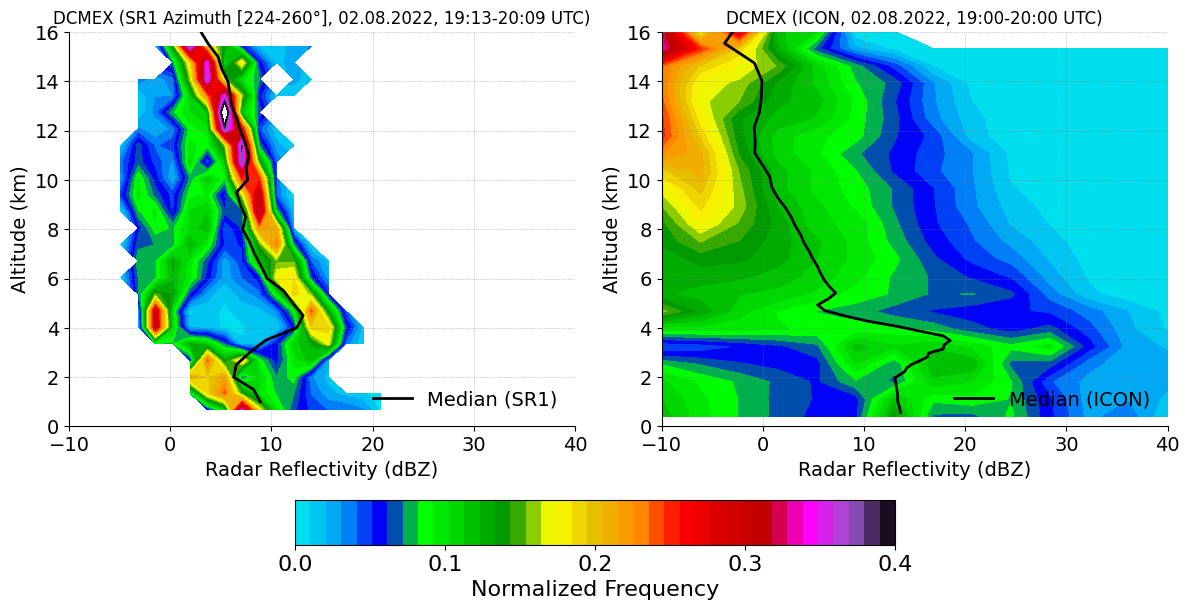

In [22]:


mean_refl_obs = mean_refl_obs[:median_refl_obs.shape[0]]
median_refl_obs1 = median_refl_obs
#median_refl_obs1[mean_alt_km_obs < 1.8] = np.nan


height_bin_centers = 0.5 * (alt_obs_bins[:-1] + alt_obs_bins[1:])
#cfad_refl_obs_norm[:, alt_obs_bins[:-1] < 1.2] = np.nan

cfad_refl_obs_norm[cfad_refl_obs_norm <= 0.] = np.nan

cfad_4sip_norm[cfad_4sip_norm <= 0.] = np.nan
#cfad_4sip_norm[:, alt_4sip_bins[:-1] < 1.45] = np.nan
#cfad_4sip_norm[:, alt_4sip_bins[:-1] > 14.25] = np.nan
#median_refl_4sip[mean_alt_4sip < 2.] = np.nan
#median_refl_4sip[mean_alt_4sip > 14.2] = np.nan


fnt = 14
lev1 = np.linspace(0., 0.4, 40)
lev2 = np.linspace(0., 0.4, 40)

plt.figure(figsize=(12, 5))
plt.style.use('default')

plt.subplot(1,2,1)
cnt = plt.contourf(dbz_obs_bins[:-1], alt_obs_bins[:-1], (cfad_refl_obs_norm.T), levels=lev1, cmap='pyart_NWSRef')
plt.plot(median_refl_obs1, mean_alt_km_obs, 'k-', linewidth=2, label='Median (SR1)')

plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fnt, loc='lower right')

plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.xlabel("Radar Reflectivity (dBZ)", fontsize=fnt)
plt.ylabel("Altitude (km)", fontsize=fnt)
plt.title('DCMEX (SR1 Azimuth [224-260°], 02.08.2022, 19:13-20:09 UTC)', fontsize=fnt-2)

plt.xlim(-10, 40)
plt.ylim(0, 16)
#cbar = plt.colorbar(contour, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0], label='Normalized Frequency', orientation='vertical')
#cbar.ax.tick_params(labelsize=fnt)
#cbar.set_label(label='Normalized Frequency', size=fnt)

# Customize tick labels and rotation
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)
plt.xticks(rotation=0)


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.subplot(1,2,2)
#contour = plt.contourf(refl_4sip_bins[:-1], avg_alt_4sip, np.log(cfad_refl_4sip.T), levels=lev, cmap='turbo')
cnt = plt.contourf(dbz_4sip_bins[:-1], alt_4sip_bins[:-1], (cfad_4sip_norm.T), levels=lev2, cmap='pyart_NWSRef')#pyart_NWSRef')
plt.plot(median_refl_4sip, mean_alt_4sip, color='k', linewidth=2, label='Median (ICON)')
#plt.plot(median_refl_ec1, mean_alt_ec_filt1, 'k--', linewidth=2, label='Median (EarthCARE-CPR)')


plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fnt, loc='lower right')

plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.xlabel("Radar Reflectivity (dBZ)", fontsize=fnt)
plt.ylabel("Altitude (km)", fontsize=fnt)
plt.title('DCMEX (ICON, 02.08.2022, 19:00-20:00 UTC)', fontsize=fnt-2)

plt.xlim(-10, 40)
plt.ylim(0, 16)
##cbar = plt.colorbar(contour, ticks=[0, 2, 4, 6, 8, 10], label='Natural log of Frequency', orientation='vertical')
#cbar = plt.colorbar(contour, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0], label='Normalized Frequency', orientation='vertical')
#cbar.ax.tick_params(labelsize=fnt)
#cbar.set_label(label='Normalized Frequency', size=fnt)

# Customize tick labels and rotation
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)
plt.xticks(rotation=0)


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


fig = plt.gcf()
cbar_ax1 = fig.add_axes([0.25, -0.1, 0.5, 0.09])  # [left, bottom, width, height]
cbar1 = fig.colorbar(cnt, cax=cbar_ax1, orientation='horizontal', ticks=[0, 0.1, 0.2, 0.3, 0.4])
cbar1.set_label('Normalized Frequency', fontsize=fnt+2)
cbar1.ax.tick_params(labelsize=fnt+2)

plt.tight_layout()
plt.show()

## Surface precipitation

In [ ]:

#ds_precip_obs = xr.open_mfdataset('/work/bk1415/b382718/output/caipeex/observations/precipitation_imdpune/Rainfall_ind2019_rfp25.grd', engine='netcdf4');
#ds_precip_obs


In [ ]:
#import xarray as xr

#fpath = "/work/bk1415/b382718/output/caipeex/observations/precipitation_imdpune"

#ds = xr.open_dataset(f"{fpath}/Rainfall_ind2019_rfp25.grd", engine="cfgrib")
#print(ds)


In [13]:

acc_precip_4sip = ds_4sip.tot_prec.mean('ncells')

del_prec_4sip = ds_4sip.tot_prec.diff('time')

precip_rate_4sip = del_prec_4sip/0.5


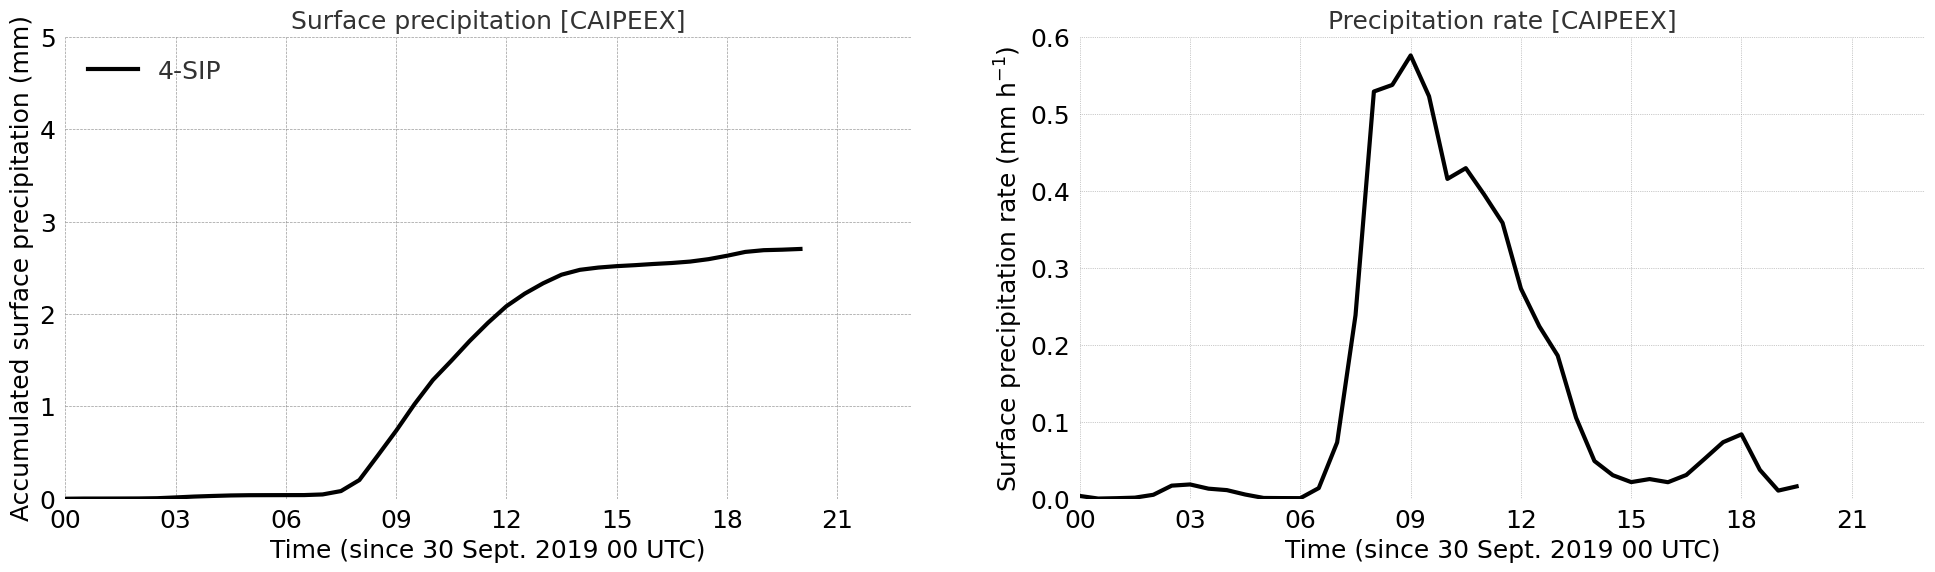

In [14]:


fontsize=18
linwdth = 3
plt.figure(figsize=(24, 6))

plt.subplot(1,2,1)
plt.plot(ds_4sip.time, acc_precip_4sip, "k-", label="4-SIP", linewidth = linwdth)

plt.grid(True, linestyle='--', color='grey', linewidth=0.5, alpha=0.8)
plt.minorticks_on()
plt.ylim(0, 5)
plt.ylabel('Accumulated surface precipitation (mm)', fontsize=fontsize)

plt.xlabel('Time (since 30 Sept. 2019 00 UTC)', fontsize=fontsize)#+4, fontweight='bold')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
start_date = datetime(2019, 9, 30, 0, 0) 
end_date = datetime(2019, 9, 30, 23, 0)

plt.xlim(start_date, end_date)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title('Surface precipitation [CAIPEEX]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.2, fontsize=fontsize, loc='upper left')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)

plt.subplot(1,2,2)
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(ds_4sip.time[:-1], precip_rate_4sip.mean('ncells'), 'k-', linewidth=lnwdth, label='4-SIP')

plt.ylim(0, 0.6)
plt.ylabel('Surface precipitation rate (mm h$^{-1}$)', fontsize=fontsize)

plt.xlabel('Time (since 30 Sept. 2019 00 UTC)', fontsize=fontsize)#+4, fontweight='bold')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
start_date = datetime(2019, 9, 30, 0, 0) 
end_date = datetime(2019, 9, 30, 23, 0)

plt.xlim(start_date, end_date)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title('Precipitation rate [CAIPEEX]', fontsize=fontsize)
#plt.legend()
#plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper left')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.show()


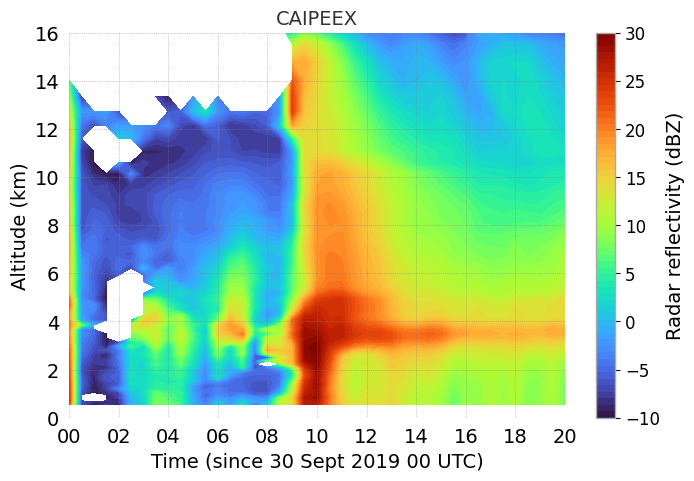

In [182]:

avg_ht = 1.e-3*ds_4sip.z_mc.mean(dim=('time','ncells'))
avg_refl_sip = ds_4sip.dbz.where(ds_4sip.dbz > -10).mean(dim=('ncells'))

colors = ['cyan', 'deepskyblue', 'mediumblue', 'lawngreen', 'limegreen', 'green', 'yellow', 'gold', 'goldenrod', 
          'coral', 'orangered', 'red', 'lightcoral', 'magenta', 'darkorchid', 'pink']
cmap = ListedColormap(colors)

lnwdth = 3
fontsize = 14
lev = np.linspace(-10, 30, 60)

plt.figure(figsize=(8, 5))
contour = plt.contourf(ds_4sip.time, avg_ht, avg_refl_sip.T, cmap='turbo', levels=lev)
colorbar = plt.colorbar(contour, ticks=[-10, -5, 0, 5, 10, 15, 20, 25, 30], label='Radar reflectivity (dBZ)')
colorbar.ax.tick_params(labelsize=12)
colorbar.set_label(label='Radar reflectivity (dBZ)', size=fontsize)

plt.xlabel('Time (since 30 Sept 2019 00 UTC)', fontsize=fontsize)


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
start_date = datetime(2019, 9, 30, 0, 0) 
end_date = datetime(2019, 9, 30, 20, 0)

plt.xlim(start_date, end_date)

plt.xticks(fontsize=fontsize)

plt.ylim([0, 16])
plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16], fontsize=fontsize)
plt.ylabel('Altitude (km)', fontsize=fontsize)

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.title('CAIPEEX', fontsize=fontsize)

plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.show()




In [6]:



w_thres = 2.
###### Without SIP
# lwc gperm3
#filt_lwc_up = xr.where((ds_nosip_new.lwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.lwc_gperm3, np.nan)
#filt_lwc_dn = xr.where((ds_nosip_new.lwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.lwc_gperm3, np.nan)
#filt_lwc_st = xr.where((ds_nosip_new.lwc_gperm3 > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.lwc_gperm3, np.nan)

#lwc_up_nosip = filt_lwc_up.mean(dim=('time','ncells'))
#lwc_dn_nosip = filt_lwc_dn.mean(dim=('time','ncells'))
#lwc_st_nosip = filt_lwc_st.mean(dim=('time','ncells'))

#tempc_nosip = ds_nosip_new.tempc.mean(dim=('time','ncells'))

# iwc gperm3
#filt_tiwc_up = xr.where((ds_nosip_new.tiwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.tiwc_gperm3, np.nan)
#filt_tiwc_dn = xr.where((ds_nosip_new.tiwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.tiwc_gperm3, np.nan)
#filt_tiwc_st = xr.where((ds_nosip_new.tiwc_gperm3 > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.tiwc_gperm3, np.nan)

#tiwc_up_nosip = filt_tiwc_up.mean(dim=('time','ncells'))
#tiwc_dn_nosip = filt_tiwc_dn.mean(dim=('time','ncells'))
#tiwc_st_nosip = filt_tiwc_st.mean(dim=('time','ncells'))

# CDNC percm3
#filt_cdnc_up = xr.where((ds_nosip_new.cdnc_percm3 > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.cdnc_percm3, np.nan)
#filt_cdnc_dn = xr.where((ds_nosip_new.cdnc_percm3 > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.cdnc_percm3, np.nan)
#filt_cdnc_st = xr.where((ds_nosip_new.cdnc_percm3 > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.cdnc_percm3, np.nan)

#cdnc_up_nosip = filt_cdnc_up.mean(dim=('time','ncells'))
#cdnc_dn_nosip = filt_cdnc_dn.mean(dim=('time','ncells'))
#cdnc_st_nosip = filt_cdnc_st.mean(dim=('time','ncells'))

# inc gperm3
#filt_inc_up = xr.where((ds_nosip_new.inc_perl > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.inc_perl, np.nan)
#filt_inc_dn = xr.where((ds_nosip_new.inc_perl > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.inc_perl, np.nan)
#filt_inc_st = xr.where((ds_nosip_new.inc_perl > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.inc_perl, np.nan)

#inc_up_nosip = filt_inc_up.mean(dim=('time','ncells'))
#inc_dn_nosip = filt_inc_dn.mean(dim=('time','ncells'))
#inc_st_nosip = filt_inc_st.mean(dim=('time','ncells'))


###### With SIP
# lwc gperm3
filt_lwc_up = xr.where((ds_4sip_new.lwc_gperm3 > 1.e-9) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.lwc_gperm3, np.nan)
filt_lwc_dn = xr.where((ds_4sip_new.lwc_gperm3 > 1.e-9) & (ds_4sip_new.w_vel < -1.*w_thres), ds_4sip_new.lwc_gperm3, np.nan)
filt_lwc_st = xr.where((ds_4sip_new.lwc_gperm3 > 1.e-9) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.lwc_gperm3, np.nan)

lwc_up_sip = filt_lwc_up.mean(dim=('time','ncells'))
lwc_dn_sip = filt_lwc_dn.mean(dim=('time','ncells'))
lwc_st_sip = filt_lwc_st.mean(dim=('time','ncells'))

tempc_sip = ds_4sip_new.tempc.mean(dim=('time','ncells'))

# iwc gperm3
filt_tiwc_up = xr.where((ds_4sip_new.tiwc_gperm3 > 1.e-6) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
filt_tiwc_dn = xr.where((ds_4sip_new.tiwc_gperm3 > 1.e-6) & (ds_4sip_new.w_vel < -1.*w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
filt_tiwc_st = xr.where((ds_4sip_new.tiwc_gperm3 > 1.e-6) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.tiwc_gperm3, np.nan)

tiwc_up_sip = filt_tiwc_up.mean(dim=('time','ncells'))
tiwc_dn_sip = filt_tiwc_dn.mean(dim=('time','ncells'))
tiwc_st_sip = filt_tiwc_st.mean(dim=('time','ncells'))

# CDNC percm3
filt_cdnc_up = xr.where((ds_4sip_new.cdnc_percm3 > 1.e-6) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.cdnc_percm3, np.nan)
filt_cdnc_dn = xr.where((ds_4sip_new.cdnc_percm3 > 1.e-6) & (ds_4sip_new.w_vel < -1.*w_thres), ds_4sip_new.cdnc_percm3, np.nan)
filt_cdnc_st = xr.where((ds_4sip_new.cdnc_percm3 > 1.e-6) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.cdnc_percm3, np.nan)

cdnc_up_sip = filt_cdnc_up.mean(dim=('time','ncells'))
cdnc_dn_sip = filt_cdnc_dn.mean(dim=('time','ncells'))
cdnc_st_sip = filt_cdnc_st.mean(dim=('time','ncells'))


# inc gperm3
filt_inc_up = xr.where((ds_4sip_new.inc_perl > 1.e-6) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.inc_perl, np.nan)
filt_inc_dn = xr.where((ds_4sip_new.inc_perl > 1.e-6) & (ds_4sip_new.w_vel < -1.*w_thres), ds_4sip_new.inc_perl, np.nan)
filt_inc_st = xr.where((ds_4sip_new.inc_perl > 1.e-6) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.inc_perl, np.nan)

inc_up_sip = filt_inc_up.mean(dim=('time','ncells'))
inc_dn_sip = filt_inc_dn.mean(dim=('time','ncells'))
inc_st_sip = filt_inc_st.mean(dim=('time','ncells'))


In [7]:

####================== Boxplot of ICON-LWC [4-SIP]
w_thres = 2.
thres_q = 1.e-6
###### Without SIP
# lwc gperm3
lwc_sip_up_gperm3 = xr.where((ds_4sip_new.qc > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.lwc_gperm3, np.nan)
lwc_sip_dn_gperm3 = xr.where((ds_4sip_new.qc > thres_q) & (ds_4sip_new.w_vel > -1.*w_thres), ds_4sip_new.lwc_gperm3, np.nan)
lwc_sip_st_gperm3 = xr.where((ds_4sip_new.qc > thres_q) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.lwc_gperm3, np.nan)
tempc_sip = ds_4sip_new.tempc

lwc_sip_up_gperm3 = lwc_sip_up_gperm3.values.flatten()
lwc_sip_dn_gperm3 = lwc_sip_dn_gperm3.values.flatten()
lwc_sip_st_gperm3 = lwc_sip_st_gperm3.values.flatten()
tempc_sip = tempc_sip.values.flatten()

df_lwc_sip = pd.DataFrame({
    'lwc_up': lwc_sip_up_gperm3,
    'lwc_dn': lwc_sip_dn_gperm3,
    'lwc_st': lwc_sip_st_gperm3,
    'tempc': tempc_sip,
})

tempc_bin = np.arange(-50., 20., 5.)  # Temperature bins 
tempc_bin = np.sort(tempc_bin)

df_lwc_sip['temp_bin'] = np.digitize(df_lwc_sip['tempc'], bins=tempc_bin, right=False)

bin_edges = np.concatenate([tempc_bin - 2, [tempc_bin[-1] + 2]])  
df_lwc_sip['temp_bin'] = bin_edges[df_lwc_sip['temp_bin']]

df_lwc_up_sip = df_lwc_sip[['lwc_up', 'temp_bin']].dropna()
df_lwc_dn_sip = df_lwc_sip[['lwc_dn', 'temp_bin']].dropna()
df_lwc_st_sip = df_lwc_sip[['lwc_st', 'temp_bin']].dropna()

df_lwc_up_sip = df_lwc_up_sip.dropna(subset=['temp_bin'])
df_lwc_dn_sip = df_lwc_dn_sip.dropna(subset=['temp_bin'])
df_lwc_st_sip = df_lwc_st_sip.dropna(subset=['temp_bin'])

lwc_sip_up_by_bin = [df_lwc_up_sip[df_lwc_up_sip['temp_bin'] == temp]['lwc_up'].values for temp in bin_edges]
lwc_sip_dn_by_bin = [df_lwc_dn_sip[df_lwc_dn_sip['temp_bin'] == temp]['lwc_dn'].values for temp in bin_edges]
lwc_sip_st_by_bin = [df_lwc_st_sip[df_lwc_st_sip['temp_bin'] == temp]['lwc_st'].values for temp in bin_edges]


In [8]:

####================== Boxplot of ICON-CDNC [3-SIP]
w_thres = 2.
thres_q = 1.e-2
###### Without SIP
# lwc gperm3
cdnc_sip_up_percm3 = xr.where((ds_4sip_new.cdnc_percm3 > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.cdnc_percm3, np.nan)
cdnc_sip_dn_percm3 = xr.where((ds_4sip_new.cdnc_percm3 > thres_q) & (ds_4sip_new.w_vel > -1.*w_thres), ds_4sip_new.cdnc_percm3, np.nan)
cdnc_sip_st_percm3 = xr.where((ds_4sip_new.cdnc_percm3 > thres_q) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.cdnc_percm3, np.nan)
tempc_sip = ds_4sip_new.tempc

cdnc_sip_up_percm3 = cdnc_sip_up_percm3.values.flatten()
cdnc_sip_dn_percm3 = cdnc_sip_dn_percm3.values.flatten()
cdnc_sip_st_percm3 = cdnc_sip_st_percm3.values.flatten()
tempc_sip = tempc_sip.values.flatten()

df_cdnc_sip = pd.DataFrame({
    'cdnc_up': cdnc_sip_up_percm3,
    'cdnc_dn': cdnc_sip_dn_percm3,
    'cdnc_st': cdnc_sip_st_percm3,
    'tempc': tempc_sip,
})

tempc_bin = np.arange(-50., 20., 5.)  # Temperature bins 
tempc_bin = np.sort(tempc_bin)

df_cdnc_sip['temp_bin'] = np.digitize(df_cdnc_sip['tempc'], bins=tempc_bin, right=False)

bin_edges = np.concatenate([tempc_bin - 2, [tempc_bin[-1] + 2]])  
df_cdnc_sip['temp_bin'] = bin_edges[df_cdnc_sip['temp_bin']]

df_cdnc_up_sip = df_cdnc_sip[['cdnc_up', 'temp_bin']].dropna()
df_cdnc_dn_sip = df_cdnc_sip[['cdnc_dn', 'temp_bin']].dropna()
df_cdnc_st_sip = df_cdnc_sip[['cdnc_st', 'temp_bin']].dropna()

df_cdnc_up_sip = df_cdnc_up_sip.dropna(subset=['temp_bin'])
df_cdnc_dn_sip = df_cdnc_dn_sip.dropna(subset=['temp_bin'])
df_cdnc_st_sip = df_cdnc_st_sip.dropna(subset=['temp_bin'])

cdnc_sip_up_by_bin = [df_cdnc_up_sip[df_cdnc_up_sip['temp_bin'] == temp]['cdnc_up'].values for temp in bin_edges]
cdnc_sip_dn_by_bin = [df_cdnc_dn_sip[df_cdnc_dn_sip['temp_bin'] == temp]['cdnc_dn'].values for temp in bin_edges]
cdnc_sip_st_by_bin = [df_cdnc_st_sip[df_cdnc_st_sip['temp_bin'] == temp]['cdnc_st'].values for temp in bin_edges]


In [9]:

####================== Boxplot of ICON-IWC [3-SIP]
w_thres = 2.
thres_q = 1.e-6
###### Without SIP
# lwc gperm3
iwc_sip_up_gperm3 = xr.where((ds_4sip_new.tqi > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
iwc_sip_dn_gperm3 = xr.where((ds_4sip_new.tqi > thres_q) & (ds_4sip_new.w_vel > -1.*w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
iwc_sip_st_gperm3 = xr.where((ds_4sip_new.tqi > thres_q) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
tempc_sip = ds_4sip_new.tempc

iwc_sip_up_gperm3 = iwc_sip_up_gperm3.values.flatten()
iwc_sip_dn_gperm3 = iwc_sip_dn_gperm3.values.flatten()
iwc_sip_st_gperm3 = iwc_sip_st_gperm3.values.flatten()
tempc_sip = tempc_sip.values.flatten()

df_iwc_sip = pd.DataFrame({
    'iwc_up': iwc_sip_up_gperm3,
    'iwc_dn': iwc_sip_dn_gperm3,
    'iwc_st': iwc_sip_st_gperm3,
    'tempc': tempc_sip,
})

tempc_bin = np.arange(-50., 20., 5.)  # Temperature bins 
tempc_bin = np.sort(tempc_bin)

df_iwc_sip['temp_bin'] = np.digitize(df_iwc_sip['tempc'], bins=tempc_bin, right=False)

bin_edges = np.concatenate([tempc_bin - 2, [tempc_bin[-1] + 2]])  
df_iwc_sip['temp_bin'] = bin_edges[df_iwc_sip['temp_bin']]

df_iwc_up_sip = df_iwc_sip[['iwc_up', 'temp_bin']].dropna()
df_iwc_dn_sip = df_iwc_sip[['iwc_dn', 'temp_bin']].dropna()
df_iwc_st_sip = df_iwc_sip[['iwc_st', 'temp_bin']].dropna()

df_iwc_up_sip = df_iwc_up_sip.dropna(subset=['temp_bin'])
df_iwc_dn_sip = df_iwc_dn_sip.dropna(subset=['temp_bin'])
df_iwc_st_sip = df_iwc_st_sip.dropna(subset=['temp_bin'])

iwc_sip_up_by_bin = [df_iwc_up_sip[df_iwc_up_sip['temp_bin'] == temp]['iwc_up'].values for temp in bin_edges]
iwc_sip_dn_by_bin = [df_iwc_dn_sip[df_iwc_dn_sip['temp_bin'] == temp]['iwc_dn'].values for temp in bin_edges]
iwc_sip_st_by_bin = [df_iwc_st_sip[df_iwc_st_sip['temp_bin'] == temp]['iwc_st'].values for temp in bin_edges]


In [10]:

####================== Boxplot of ICON-INC [3-SIP]
w_thres = 2.
thres_q = 1.e-4
###### Without SIP
# lwc gperm3
#inc_sip_up_perl = xr.where((ds_4sip_new.inc_perl > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.inc_perl, np.nan)
#inc_sip_dn_perl = xr.where((ds_4sip_new.inc_perl > thres_q) & (ds_4sip_new.w_vel > -1.*w_thres), ds_4sip_new.inc_perl, np.nan)
#inc_sip_st_perl = xr.where((ds_4sip_new.inc_perl > thres_q) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.inc_perl, np.nan)


thres_q = 1.e-6
inc_sip_up_perl = xr.where((ds_4sip_new.tqi > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.inc_perl, np.nan)
inc_sip_dn_perl = xr.where((ds_4sip_new.tqi > thres_q) & (ds_4sip_new.w_vel > -1.*w_thres), ds_4sip_new.inc_perl, np.nan)
inc_sip_st_perl = xr.where((ds_4sip_new.tqi > thres_q) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.inc_perl, np.nan)
tempc_sip = ds_4sip_new.tempc

inc_sip_up_perl = inc_sip_up_perl.values.flatten()
inc_sip_dn_perl = inc_sip_dn_perl.values.flatten()
inc_sip_st_perl = inc_sip_st_perl.values.flatten()
tempc_sip = tempc_sip.values.flatten()

df_inc_sip = pd.DataFrame({
    'inc_up': inc_sip_up_perl,
    'inc_dn': inc_sip_dn_perl,
    'inc_st': inc_sip_st_perl,
    'tempc': tempc_sip,
})

tempc_bin = np.arange(-50., 20., 5.)  # Temperature bins 
tempc_bin = np.sort(tempc_bin)

df_inc_sip['temp_bin'] = np.digitize(df_inc_sip['tempc'], bins=tempc_bin, right=False)

bin_edges = np.concatenate([tempc_bin - 2, [tempc_bin[-1] + 2]])  
df_inc_sip['temp_bin'] = bin_edges[df_inc_sip['temp_bin']]

df_inc_up_sip = df_inc_sip[['inc_up', 'temp_bin']].dropna()
df_inc_dn_sip = df_inc_sip[['inc_dn', 'temp_bin']].dropna()
df_inc_st_sip = df_inc_sip[['inc_st', 'temp_bin']].dropna()

df_inc_up_sip = df_inc_up_sip.dropna(subset=['temp_bin'])
df_inc_dn_sip = df_inc_dn_sip.dropna(subset=['temp_bin'])
df_inc_st_sip = df_inc_st_sip.dropna(subset=['temp_bin'])

inc_sip_up_by_bin = [df_inc_up_sip[df_inc_up_sip['temp_bin'] == temp]['inc_up'].values for temp in bin_edges]
inc_sip_dn_by_bin = [df_inc_dn_sip[df_inc_dn_sip['temp_bin'] == temp]['inc_dn'].values for temp in bin_edges]
inc_sip_st_by_bin = [df_inc_st_sip[df_inc_st_sip['temp_bin'] == temp]['inc_st'].values for temp in bin_edges]


In [ ]:

tm_range = slice(2743, 2744)
print(data_pip.time[tm_range])
#print(data_pip.Nt_percm3perum[1979:1980].values)
print('value in each bin [percm3] > 400µm :: ',data_pip.iloc[tm_range, 5:61].values)
print()
print('SUM  > 400µm  :: ',np.sum(100.*data_pip.iloc[tm_range, 5:61].values))

In [11]:

## PIP
file_path = '/work/bk1415/b382718/output/caipeex/observations/aircraft_Data_AR_SIP_case/CIP/correctedPbPCIPSizeSpectraCAIPEX20190930.txt'
data_cip = pd.read_csv(file_path, sep='\s+', header=None, skiprows=1)

data_cip.columns = ['time'] + ['Nt_percm3perum']*62 + ['mass_gpercm']* (data_cip.shape[1]-63) # cols 2-63: n_conc, & remaining 62 columns: mass
##

## PIP
file_path = '/work/bk1415/b382718/output/caipeex/observations/aircraft_Data_AR_SIP_case/PIP/correctedPIPSizeSpectraCAIPEX20190930.txt'
data_pip = pd.read_csv(file_path, sep='\s+', header=None, skiprows=1)

data_pip.columns = ['time'] + ['Nt_percm3perum']*62 + ['mass_gpercm']* (data_pip.shape[1]-63) # cols 2-63: n_conc, & remaining 62 columns: mass
##

## CIP
diam_cip_end_bin = [15., 30., 45., 60., 75., 90., 105., 120., 135., 150.,
                    165., 180., 195., 210., 225., 240., 255., 270., 285., 300.,
                    315., 330., 345., 360., 375., 390., 405., 420., 435., 450., 
                    465., 480., 495., 510., 525., 540., 555., 570., 585., 600.,
                    615., 630., 645., 660., 675., 690., 705., 720., 735., 750.,
                    765., 780., 795., 810., 825., 840., 855., 870., 885., 900.,
                    915., 930.]
##

## PIP
diam_pip_end_bin = [100., 200., 300., 400., 500., 600., 700., 800., 900., 1000.,
                    1100., 1200., 1300., 1400., 1500., 1600., 1700., 1800., 1900., 2000.,
                    2100., 2200., 2300., 2400., 2500., 2600., 2700., 2800., 2900., 3000.,
                    3100., 3200., 3300., 3400., 3500., 3600., 3700., 3800., 3900., 4000.,
                    4100., 4200., 4300., 4400., 4500., 4600., 4700., 4800., 4900., 5000.,
                    5100., 5200., 5300., 5400., 5500., 5600., 5700., 5800., 5900., 6000.,
                    6100., 6200.]
## 

#diam_cip_width_um = np.diff(diam_cip_bin_um)
#diam_cip_width_cm = np.diff(diam_cip_bin_cm)

## CIP
diam_cip_bin_um = np.array(diam_cip_end_bin)
diam_cip_bin_cm = 1.e-4*np.array(diam_cip_end_bin)

nt_cip_percm3perum = data_cip.iloc[:,1:63].values
mt_cip_gpercm = data_cip.iloc[:,63:].values
##

## PIP
diam_pip_bin_um = np.array(diam_pip_end_bin)
diam_pip_bin_m = 1.e-6*diam_pip_bin_um
diam_pip_bin_cm = 1.e-4*np.array(diam_pip_end_bin)

nt_pip_percm3percm = data_pip.iloc[:,1:63].values
nt_pip_perm3perm = 1.e5*data_pip.iloc[:,1:63].values  # only for check (From Dr. Sachin Patade, netcdf file screenshot)
mt_pip_gpercm = data_pip.iloc[:,63:].values
##

##============================================ CIP
cip_nt_mask = (nt_cip_percm3perum > 0.)
mask_cip_diam_um = (np.array(diam_cip_end_bin) > 400.)
cip_mt_mask = (mt_cip_gpercm > 0.) 

diam_cip_bin_width_um = 15.    # µm
diam_cip_bin_width_cm = 15.e-4 # cm

nice_cip_percm3 = np.where(cip_nt_mask & mask_cip_diam_um, nt_cip_percm3perum* diam_cip_bin_width_um, np.nan)
#mice_cip_gperm3 = np.where(cip_mt_mask & mask_cip_diam_um, mt_cip_gpercm/(diam_cip_bin_width_cm**2.), np.nan)

nice_cip_percm3 = np.nansum(nice_cip_percm3, axis=1)
#mice_cip_percm3 = np.nansum(mice_cip_gperm3, axis=1)

nice400um_cip_perl = 1.e3*nice_cip_percm3

# Store required variables in as a new dataset  
ds_cip = pd.DataFrame()
ds_cip['time'] = data_cip['time']
ds_cip['ni400um_cip_perl'] = pd.Series(nice400um_cip_perl)
##============================================

##============================================ PIP
pip_nt_mask = (nt_pip_percm3percm > 0.) #& (nt_pip_percm3perum < 1.0) 
mask_pip_diam_um = (np.array(diam_pip_end_bin) > 400.)
mask_pip_diam_m = (diam_pip_bin_m > 400.e-6)
mask_pip_diam_cm = (diam_pip_bin_m > 400.e-4)
pip_mt_mask = (mt_pip_gpercm > 0.) 

diam_pip_bin_width_m = 100*1.e-6 # m
diam_pip_bin_width_um = 100. # µm
diam_pip_bin_width_cm = 100*1.e-4 # cm

nice_pip_percm3 = np.where(pip_nt_mask & mask_pip_diam_m, nt_pip_percm3percm * diam_pip_bin_width_cm, np.nan)
nice_pip_perm3 = np.where(pip_nt_mask & mask_pip_diam_m, nt_pip_perm3perm * diam_pip_bin_width_m, np.nan)  # only for check
#mice_pip_gperm3 = np.where(pip_mt_mask & mask_pip_diam_um, mt_pip_gpercm/(diam_pip_bin_width_cm**2.), np.nan)

nice_pip_percm3 = np.nansum(nice_pip_percm3, axis=1)
nice_pip_perm3 = np.nansum(nice_pip_perm3, axis=1)
#mice_cip_percm3 = np.nansum(mice_cip_gperm3, axis=1)

nice400um_pip_perl = 1.e3*nice_pip_percm3

# Store required variables in as a new dataset  
ds_pip = pd.DataFrame()
ds_pip['time'] = data_pip['time']
ds_pip['ni400um_pip_perl'] = pd.Series(nice400um_pip_perl)
##============================================

#plt.plot(ds_cip.time,ds_cip.nice400um_cip_perl)

In [ ]:

plt.plot()

In [12]:

file_path = '/work/bk1415/b382718/output/caipeex/observations/aircraft_Data_AR_SIP_case/CIPcorrectedprocessed1HzdataCAIPEX20190930.txt'

#ds_b200 = pd.read_csv(file_path, sep='\s+', header=None, skiprows=1)
ds_b200 = pd.read_csv(file_path, sep='\s+', header=0, skiprows=0, on_bad_lines='skip', usecols=[0, 1, 2, 3, 4, 5])

ds_b200.Longitude[ds_b200.Longitude < 0.] = np.nan
ds_b200.Latitude[ds_b200.Latitude < 0.] = np.nan

ds_b200
#plt.plot(ds_b200.Latitude)

Seconds  Altitude  Latitude  Longitude  Air_Speed  Temperature
0        25954       407    17.626     75.934    -999.00        32.89
1        25955       407    17.626     75.934    -999.00        32.91
2        25956       407    17.626     75.934    -999.00        32.96
3        25957       407    17.626     75.934    -999.00        32.94
4        25958       407    17.626     75.934    -999.00        32.92
...        ...       ...       ...        ...        ...          ...
11728    37682       412    17.627     75.935      14.15        32.32
11729    37683       412    17.627     75.935      14.45        32.46
11730    37684       412    17.627     75.935      16.23        32.37
11731    37685       412    17.627     75.935      15.93        32.31
11732    37686       412    17.627     75.935      16.61        32.26

[11733 rows x 6 columns]

In [23]:
ds_b200.Seconds

0        25954
1        25955
2        25956
3        25957
4        25958
         ...  
11728    37682
11729    37683
11730    37684
11731    37685
11732    37686
Name: Seconds, Length: 11733, dtype: int64

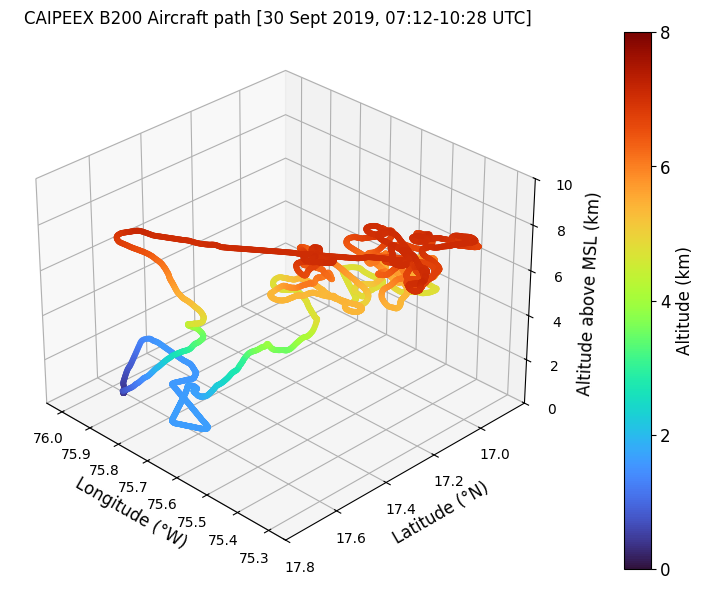

In [25]:

import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

file_path = '/work/bk1415/b382718/output/caipeex/observations/aircraft_Data_AR_SIP_case/CIPcorrectedprocessed1HzdataCAIPEX20190930.txt'

#ds_b200 = pd.read_csv(file_path, sep='\s+', header=None, skiprows=1)
ds_b200 = pd.read_csv(file_path, sep='\s+', header=0, skiprows=0, on_bad_lines='skip', usecols=[0, 1, 2, 3, 4, 5])

ds_b200.Longitude[ds_b200.Longitude < 0.] = np.nan
ds_b200.Latitude[ds_b200.Latitude < 0.] = np.nan
ds_b200.Altitude[ds_b200.Altitude < 0.] = np.nan
#ds_b200.Temperature[ds_b200.Temperature < 0.] = np.nan

mean_lon = ds_b200.Longitude
mean_lat = ds_b200.Latitude
mean_alt = 1.e-3*ds_b200.Altitude
mean_temp = ds_b200.Temperature
#lon = data_faam_core_cld_phy_latlon['longitude'].values
#lat = data_faam_core_cld_phy_latlon['latitude'].values
#alt = data_faam_core_cld_phy_latlon['altitude'].values / 1000.0  # Convert to km


fnt = 12
lnw = 3
lev=np.linspace(0,8,10)
# 3D scatter plot

plt.style.use('default')
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with altitude as color
sc = ax.scatter(mean_lon, mean_lat, mean_alt, c=mean_alt, cmap='turbo', s=10, vmin=0, vmax=8)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, ticks=[0, 2, 4, 6, 8], pad=0.1)
cbar.set_label('Altitude (km)', fontsize=fnt)
cbar.ax.tick_params(labelsize=fnt)

# Axis labels
#ax.set_ylim(33,35)
#ax.set_xlim(-105,-107)
ax.set_zlim(0,10)
ax.set_xlabel('Longitude (°W)', fontsize=fnt)
ax.set_ylabel('Latitude (°N)', fontsize=fnt)
ax.set_zlabel('Altitude above MSL (km)', fontsize=fnt)
ax.tick_params(axis='x', labelsize=fnt-2)
ax.tick_params(axis='y', labelsize=fnt-2)
ax.tick_params(axis='z', labelsize=fnt-2)

ax.set_title('CAIPEEX B200 Aircraft path [30 Sept 2019, 07:12-10:28 UTC]', fontsize=fnt)

# Optional: rotate view
ax.view_init(elev=30, azim=135)

plt.tight_layout()
plt.show()


## Radar and flight track combined

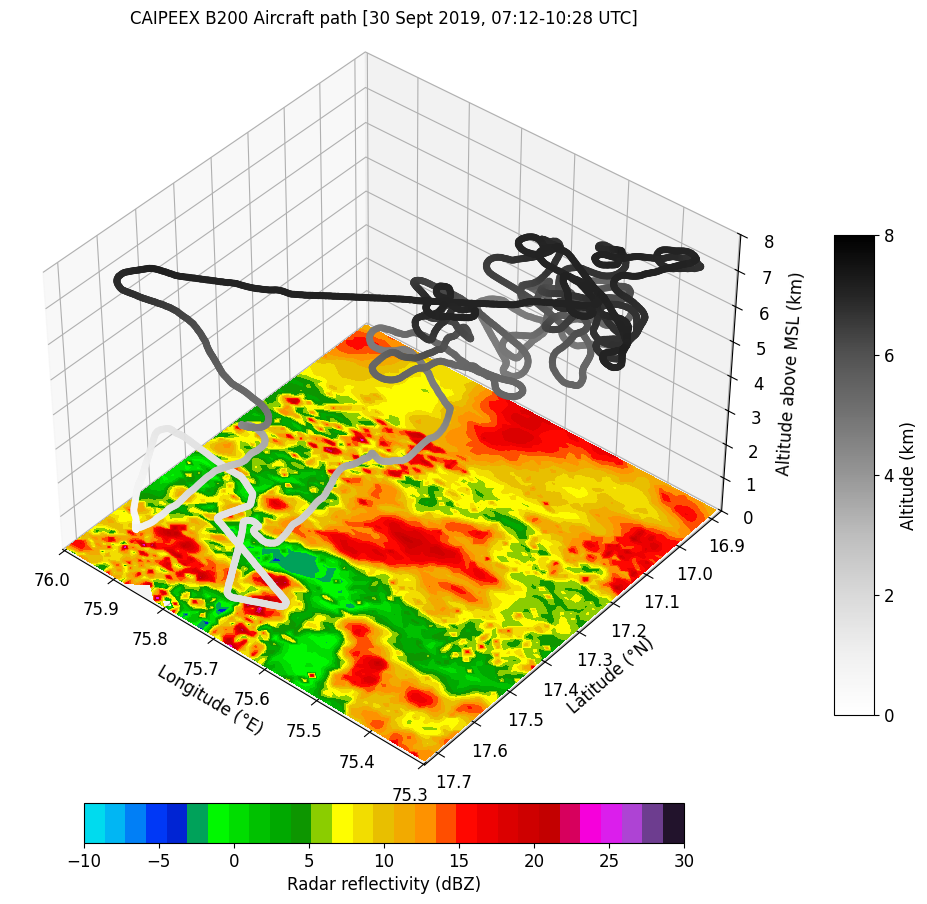

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap

plt.style.use('default')

# Load aircraft data
file_path = '/work/bk1415/b382718/output/caipeex/observations/aircraft_Data_AR_SIP_case/CIPcorrectedprocessed1HzdataCAIPEX20190930.txt'
ds_b200 = pd.read_csv(file_path, sep='\s+', header=0, skiprows=0, on_bad_lines='skip', usecols=[0, 1, 2, 3, 4, 5])
ds_b200.Longitude[ds_b200.Longitude < 0.] = np.nan
ds_b200.Latitude[ds_b200.Latitude < 0.] = np.nan
ds_b200.Altitude[ds_b200.Altitude < 0.] = np.nan

mean_lon = ds_b200.Longitude
mean_lat = ds_b200.Latitude
mean_alt = 1.e-3*ds_b200.Altitude

# Load radar data
ds_refl_obs = xr.open_dataset('/work/bk1415/b382718/output/caipeex/observations/radar_data/Case20190930_RADAR_DBZc_4D.nc')
#lon_min, lon_max = 75, 76
#lat_min, lat_max = 17, 18

lon_min, lon_max = np.nanmin(mean_lon), np.nanmax(mean_lon)
lat_min, lat_max = np.nanmin(mean_lat), np.nanmax(mean_lat)

ds_refl_obs = ds_refl_obs.where(
    (ds_refl_obs.lon >= lon_min) & (ds_refl_obs.lon <= lon_max) &
    (ds_refl_obs.lat >= lat_min) & (ds_refl_obs.lat <= lat_max), 
    drop=True
)

avg_refl_obs = xr.where(ds_refl_obs.dbzc > -10., ds_refl_obs.dbzc, np.nan)
refl_2d = avg_refl_obs.mean(dim=('time','alt'))

# Create custom radar-like colormap
colors = ['cyan', 'deepskyblue', 'mediumblue', 'lawngreen', 'limegreen', 'green', 
          'yellow', 'gold', 'goldenrod', 'coral', 'orangered', 'red', 
          'lightcoral', 'magenta', 'darkorchid', 'pink']
radar_cmap = ListedColormap(colors)

# Get the coordinate arrays and data
lon_coords = refl_2d.lon.values
lat_coords = refl_2d.lat.values
refl_values = refl_2d.values

# Create meshgrid
LON, LAT = np.meshgrid(lon_coords, lat_coords)

# Create 3D plot
fnt = 12
plt.style.use('default')
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot radar reflectivity using contourf at z=0
# This is much simpler and more reliable
altitude_base = 0  # Ground level
levels = np.linspace(-10, 30, 30)
lev = np.linspace(-10, 30, 30)

# Plot using contourf which handles dimensions correctly
contour = ax.contourf(ds_refl_obs.lon, ds_refl_obs.lat, avg_refl_obs.mean(dim=('time','alt')).values, 
                      cmap='pyart_NWSRef', levels=lev,
                     zdir='z', offset=0., alpha=1)

#contour = ax.contourf(ds_refl_obs.lon, ds_refl_obs.lat, refl_values, 
#                      levels=levels,
#                      cmap=radar_cmap,
#                      zdir='z', 
#                      offset=altitude_base,
#                      alpha=0.8)

# Plot aircraft track
sc = ax.scatter(mean_lon, mean_lat, mean_alt, c=mean_alt, cmap='Greys', s=15, vmin=0, vmax=8)
#sc = ax.scatter(mean_lon, mean_lat, mean_alt, c=mean_alt, cmap='turbo', s=20, 
#                vmin=0, vmax=8, edgecolors='black', linewidth=0.5)

# Add colorbars
cbar_ax1 = fig.add_axes([0.95, 0.1, 0.04, 0.6])
cbar1 = plt.colorbar(sc, cax=cbar_ax1, ticks=[0, 2, 4, 6, 8], pad=0.1, shrink=0.6, aspect=15)
cbar1.set_label('Altitude (km)', fontsize=fnt)
cbar1.ax.tick_params(labelsize=fnt)

# Create a second colorbar for reflectivity
cbar_ax2 = fig.add_axes([0.2, -0.06, 0.6, 0.05])  # [left, bottom, width, height]
cbar2 = plt.colorbar(contour, cax=cbar_ax2, ticks=[-10, -5, 0, 5, 10, 15, 20, 25, 30], 
                     orientation='horizontal',
                     label='Radar reflectivity (dBZ)', pad=0.15, shrink=0.6)

cbar2.ax.tick_params(labelsize=12)
cbar2.set_label(label='Radar reflectivity (dBZ)', size=fnt)

#cbar2 = plt.colorbar(contour, ax=ax, ticks=[-10, -5, 0, 5, 10, 15, 20, 25, 30], 
#                     pad=0.15, shrink=0.6, aspect=15)
#cbar2.set_label('Radar Reflectivity (dBZ)', fontsize=fnt)
#cbar2.ax.tick_params(labelsize=fnt)


# Set axis properties
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
ax.set_zlim(0, 8)
ax.set_xlabel('Longitude (°E)', fontsize=fnt)
ax.set_ylabel('Latitude (°N)', fontsize=fnt)
ax.set_zlabel('Altitude above MSL (km)', fontsize=fnt)
ax.tick_params(axis='x', labelsize=fnt)
ax.tick_params(axis='y', labelsize=fnt)
ax.tick_params(axis='z', labelsize=fnt)

ax.set_title('CAIPEEX B200 Aircraft path [30 Sept 2019, 07:12-10:28 UTC]', fontsize=fnt)

# Set view angle
#ax.view_init(elev=30, azim=140)
ax.view_init(elev=40, azim=130)

plt.grid(True, linestyle='-', linewidth=3, color='k', alpha=1)
cbar_ax1.grid(False)
cbar_ax2.grid(False)


plt.tight_layout()
plt.show()

In [9]:
pip install xarray cfgrib eccodes



[notice] A new release of pip is available: 25.1 -> 25.3
[notice] To update, run: /home/b/b382718/own_env/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import xarray as xr

fpath="/work/bk1415/b382718/output/caipeex/observations/ncep_fnl_sounding";
ds = xr.open_dataset(
    f"{fpath}/gdas1.fnl0p25.2019093000.f03.grib2",
    engine="netcdf4"
)





[np.float64(63.70064552173174), np.float64(88.28351431337873)] [np.float64(5.733353743178144), np.float64(30.275130001758356)]
[np.float64(67.84920373315597), np.float64(84.14549852538491)] [np.float64(9.868682359112812), np.float64(26.13486821920761)]
[np.float64(71.93210098125823), np.float64(80.0745760952009)] [np.float64(13.934746107194115), np.float64(22.066432425854472)]
[np.float64(73.96231963252478), np.float64(78.03731006305424)] [np.float64(15.966591958598846), np.float64(20.032770298239175)]


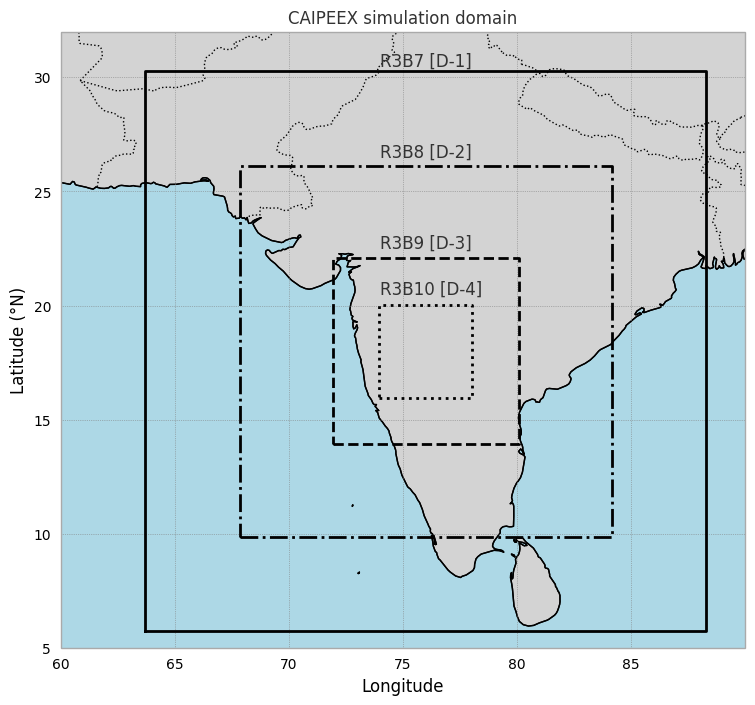

In [9]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# Define bounding boxes (in degrees)
lon1 = [np.rad2deg(1.111786), np.rad2deg(1.540838)];
lat1 = [np.rad2deg(0.1000659), np.rad2deg(0.5284007)];

lon2 = [np.rad2deg(1.184192), np.rad2deg(1.468616)];
lat2 = [np.rad2deg(0.172241), np.rad2deg(0.4561395)];

lon3 = [np.rad2deg(1.255452), np.rad2deg(1.397565)];
lat3 = [np.rad2deg(0.2432072), np.rad2deg(0.3851319)];

lon4 = [np.rad2deg(1.290886), np.rad2deg(1.362008)];
lat4 = [np.rad2deg(0.2786696), np.rad2deg(0.3496378)];

print(lon1, lat1)
print(lon2, lat2)
print(lon3, lat3)
print(lon4, lat4)

fontsize = 12
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Plot base map
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')

# Plot bounding boxes
for lon, lat, style in zip(
    [lon1, lon2, lon3, lon4],
    [lat1, lat2, lat3, lat4],
    ['-', '-.', '--', ':']
):
    ax.plot([lon[0], lon[1], lon[1], lon[0], lon[0]],
            [lat[0], lat[0], lat[1], lat[1], lat[0]],
            color='black', linewidth=2, linestyle=style, transform=proj)


# Labels
ax.text(74, 30.5, "R3B7 [D-1]", transform=proj, fontsize=fontsize)
ax.text(74, 26.5, "R3B8 [D-2]", transform=proj, fontsize=fontsize)
ax.text(74, 22.5, "R3B9 [D-3]", transform=proj, fontsize=fontsize)
ax.text(74, 20.5, "R3B10 [D-4]", transform=proj, fontsize=fontsize)

# Map limits
ax.set_xlim(60., 90.)
ax.set_ylim(5., 32.)
ax.set_xticks(range(60, 90, 5))  
ax.set_yticks(range(5, 32, 5))
ax.set_xlabel("Longitude", fontsize=fontsize)
ax.set_ylabel("Latitude (°N)", fontsize=fontsize)
ax.set_title('CAIPEEX simulation domain', fontsize=fontsize)
ax.grid(True, linestyle=':', linewidth=0.5, color='grey')

# === Create inset axes === #
#inset_position = [0.68, 0.35, 0.30, 0.25]  # [left, bottom, width, height] in figure coordinates
#inset_ax = fig.add_axes(inset_position, projection=proj)
#inset_ax.set_extent([75, 77, 16, 18], crs=proj)
#inset_ax.coastlines(resolution='50m')
#inset_ax.add_feature(cfeature.LAND, facecolor='lightgray')
#inset_ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
#inset_ax.gridlines(draw_labels=False, linestyle=':')


# Aircraft track in inset
#inset_ax.plot(ds_b200.Longitude, ds_b200.Latitude, 'r-', transform=proj)

#inset_ax.plot([75, 77, 77, 75, 75],
#              [16, 16, 18, 18, 16],
#              color='black', linewidth=1, linestyle=':', alpha=0.1, transform=proj)

#inset_ax.text(76, 16.2, 'R3B10 [D-4]', transform=proj, 
#              fontsize=fontsize, ha='center', va='center', 
#              bbox=dict(facecolor='none', edgecolor='none', alpha=0.7))

#gl = inset_ax.gridlines(draw_labels=False, linestyle=':', color='grey', alpha=0.5)
#gl.top_labels = False
#gl.right_labels = False
##gl.xlabel_style = {'size': 10}
##gl.ylabel_style = {'size': 10}
#inset_ax.set_xticks(np.linspace(75, 77, 5), crs=proj)
#inset_ax.set_yticks(np.linspace(16, 18, 5), crs=proj)
#inset_ax.tick_params(axis='both', which='major', labelsize=8)

# --- Radar marker in zoomed inset ---
#inset_ax.text(76, 16.7, 'B200 aircraft', transform=proj, fontsize=fontsize, ha='center', color='red')

plt.show()


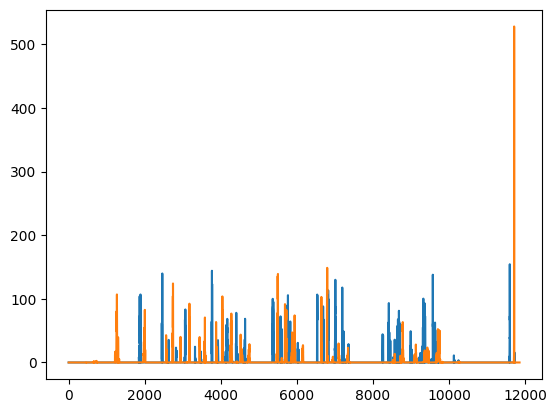

In [15]:
#plt.plot(nice400um_cip_perl)
#plt.plot(1.e-3*nice_pip_perm3)
#plt.plot(nt_pip_percm3percm)
plt.plot(ds_cip.ni400um_cip_perl)
plt.plot(ds_pip.ni400um_pip_perl)
#plt.ylim(1.e0,2.e6)
#plt.plot(nt_cip_percm3perum)
#plt.plot(nice_cip_percm3)

In [103]:

# Flight data
file_path = '/work/bk1415/b382718/output/caipeex/observations/aircraft_Data_AR_SIP_case/aa_CIPcorrectedprocessed1HzdataCAIPEX20190930.txt'
data_v2 = pd.read_csv(file_path, sep='\s+', header=None, skiprows=1)

data_v2.columns = ['time', 'alt', 'lon', 'lat', 'air_speed', 
                   'air_temp', 'pres', 'rel_hum', 'wind_spped', 'wind_dir',
                   'vert_vel', 'num_conc_ccp_cdp', 'lwc_conc_ccp_cdp', 'mean_vol_diam_ccp_cdp', 'ccn200ass',
                   'ccn200anumconc', 'ccn200bss', 'ccn200bnumconc', 'num_conc_cdp', 'lwc_conc_cdp',
                   'mean_vol_diam_cdp', 'num_conc_cip', 'lwc_conc_cip', 'mean_vol_diam_cip', 'num_conc_pcasp',
                   'mass_conc_pcasp', 'mean_vol_diam_pcasp', 'num_conc_pip', 'lwc_conc_pip', 'mean_vol_diam_pip', 
                   'num_conc_sp2', 'mass_conc_sp2', 'mean_vol_diam_sp2', 'num_conc_sp2rbc', 'mass_conc_sp2rbc',  
                   'mean_vol_diam_sp2rbc', 'num_conc_uhsas', 'mass_conc_uhsas', 'mean_vol_diam_uhsas', 'lwc_300']

#df_v2 = pd.DataFrame(data_v2)
#df_v2['num_conc_cip'] = pd.to_numeric(df_v2['num_conc_cip'], errors='coerce')
data_v2['tempc'] = data_v2['air_temp']
ds_v2 = data_v2
ds_v2['nice_cip_up'] = np.where(ds_v2.num_conc_cip > 0., ds_v2.num_conc_cip, np.nan)

w_thres=1.;
# CDNC
ds_v2['cdnc_cdp_up_percm3'] = np.where((ds_v2.num_conc_cdp > 5.) & (ds_v2.vert_vel > w_thres), ds_v2.num_conc_cdp, np.nan)
ds_v2['cdnc_cdp_dn_percm3'] = np.where((ds_v2.num_conc_cdp > 5.) & (ds_v2.vert_vel < -1*w_thres), ds_v2.num_conc_cdp, np.nan)
ds_v2['cdnc_cdp_st_percm3'] = np.where((ds_v2.num_conc_cdp > 5.) & (np.abs(ds_v2.vert_vel) < w_thres), ds_v2.num_conc_cdp, np.nan)

# LWC
ds_v2['lwc_cdp_up_gperm3'] = np.where((ds_v2.lwc_conc_cdp > 1.e-6) & (ds_v2.vert_vel > w_thres) & (ds_v2.num_conc_cdp > 5.), ds_v2.lwc_conc_cdp, np.nan)
ds_v2['lwc_cdp_dn_gperm3'] = np.where((ds_v2.lwc_conc_cdp > 1.e-6) & (ds_v2.vert_vel < -1*w_thres) & (ds_v2.num_conc_cdp > 5.), ds_v2.lwc_conc_cdp, np.nan)
ds_v2['lwc_cdp_st_gperm3'] = np.where((ds_v2.lwc_conc_cdp > 1.e-6) & (np.abs(ds_v2.vert_vel) < w_thres) & (ds_v2.num_conc_cdp > 5.), ds_v2.lwc_conc_cdp, np.nan)

temp_bin = np.arange(-30, 30, 5)
temp_bin = np.sort(temp_bin)

ds_v2['temp_bin'] = pd.cut(ds_v2['air_temp'], bins=np.append(temp_bin, np.inf), labels=temp_bin)
ds_v2['temp_bin'] = pd.cut(ds_v2['air_temp'], bins=np.append(temp_bin, np.inf), labels=temp_bin)
ds_v2['temp_bin'] = pd.cut(ds_v2['air_temp'], bins=np.append(temp_bin, np.inf), labels=temp_bin)
ds_v2['temp_bin'] = pd.cut(ds_v2['air_temp'], bins=np.append(temp_bin, np.inf), labels=temp_bin)


ds_v2 = ds_v2.dropna(subset=['temp_bin'])

ds_v2['temp_bin'] = ds_v2['temp_bin'].astype(float)

## Combine ds_v2 and ds_cip data for ds_v2.time=ds_cip.time
##=========== PIP
ds_v2_cip_comb = pd.merge(ds_v2, ds_cip, on='time', how='inner')

##=========== PIP
ds_v2_pip_comb = pd.merge(ds_v2, ds_pip, on='time', how='inner')

# TINC

w_thres = 1.;
##=========== CIP
ds_v2_cip_comb['ni400um_cip_up_perl'] = np.where((ds_v2_cip_comb.ni400um_cip_perl > 1.e-4) & (ds_v2_cip_comb.vert_vel > w_thres), 
                                        ds_v2_cip_comb.ni400um_cip_perl, np.nan)
ds_v2_cip_comb['ni400um_cip_dn_perl'] = np.where((ds_v2_cip_comb.ni400um_cip_perl > 1.e-4) & (ds_v2_cip_comb.vert_vel < -1*w_thres), 
                                        ds_v2_cip_comb.ni400um_cip_perl, np.nan)
ds_v2_cip_comb['ni400um_cip_st_perl'] = np.where((ds_v2_cip_comb.ni400um_cip_perl > 1.e-4) & (np.abs(ds_v2_cip_comb.vert_vel) < w_thres), 
                                        ds_v2_cip_comb.ni400um_cip_perl, np.nan)

##=========== PIP
ds_v2_pip_comb['ni400um_pip_up_perl'] = np.where((ds_v2_pip_comb.ni400um_pip_perl > 1.e-4) & (ds_v2_pip_comb.vert_vel > w_thres), 
                                        ds_v2_pip_comb.ni400um_pip_perl, np.nan)
ds_v2_pip_comb['ni400um_pip_dn_perl'] = np.where((ds_v2_pip_comb.ni400um_pip_perl > 1.e-4) & (ds_v2_pip_comb.vert_vel < -1*w_thres), 
                                        ds_v2_pip_comb.ni400um_pip_perl, np.nan)
ds_v2_pip_comb['ni400um_pip_st_perl'] = np.where((ds_v2_pip_comb.ni400um_pip_perl > 1.e-4) & (np.abs(ds_v2_pip_comb.vert_vel) < w_thres), 
                                        ds_v2_pip_comb.ni400um_pip_perl, np.nan)


In [ ]:
from datetime import datetime, timedelta

# Condition: tempc between -6 and -5
condition = (ds_v2_cip_comb['air_temp'] > -2) & (ds_v2_cip_comb['air_temp'] < 2)
filtered_df = ds_v2_cip_comb[condition]

# Print results
#for t, temp in zip(filtered_df['time'], filtered_df['air_temp']):
#    print(f"Time: {t}, TempC: {temp}")

for seconds, temp in zip(filtered_df['time'], filtered_df['air_temp']):
    # Convert seconds to time of day
    time_obj = (datetime(1970, 1, 1) + timedelta(seconds=seconds)).time()
    hhmmss = time_obj.strftime("%H:%M:%S")
    print(f"Time(sec) ({seconds}), Time ({hhmmss}), TempC: {temp}")

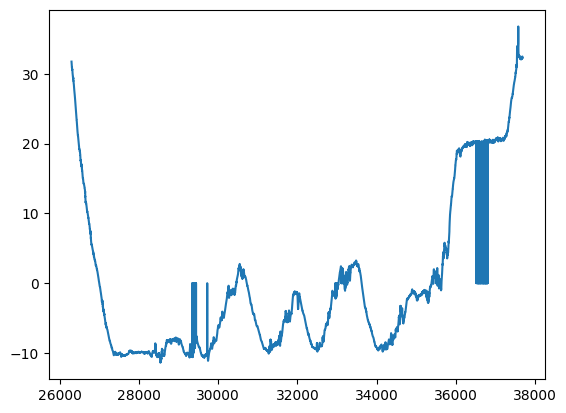

In [5]:

plt.plot(ds_v2_cip_comb.time, ds_v2_cip_comb.air_temp)

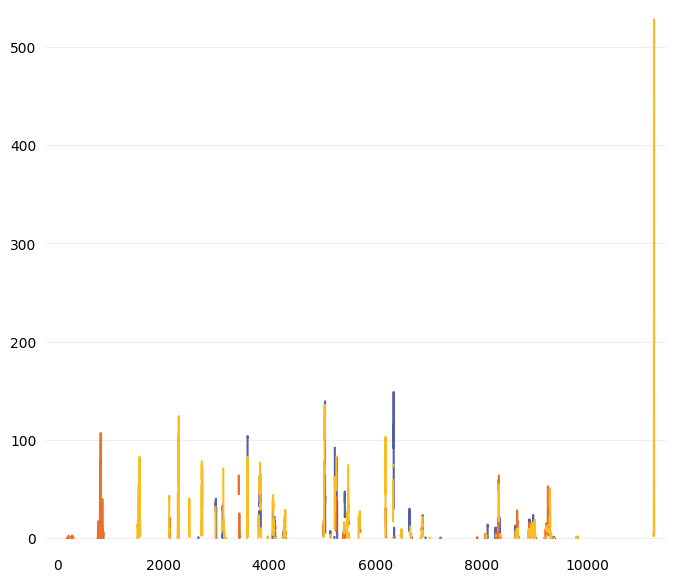

In [27]:
plt.plot(ds_v2_pip_comb.ni400um_pip_up_perl)
plt.plot(ds_v2_pip_comb.ni400um_pip_dn_perl)
plt.plot(ds_v2_pip_comb.ni400um_pip_st_perl)


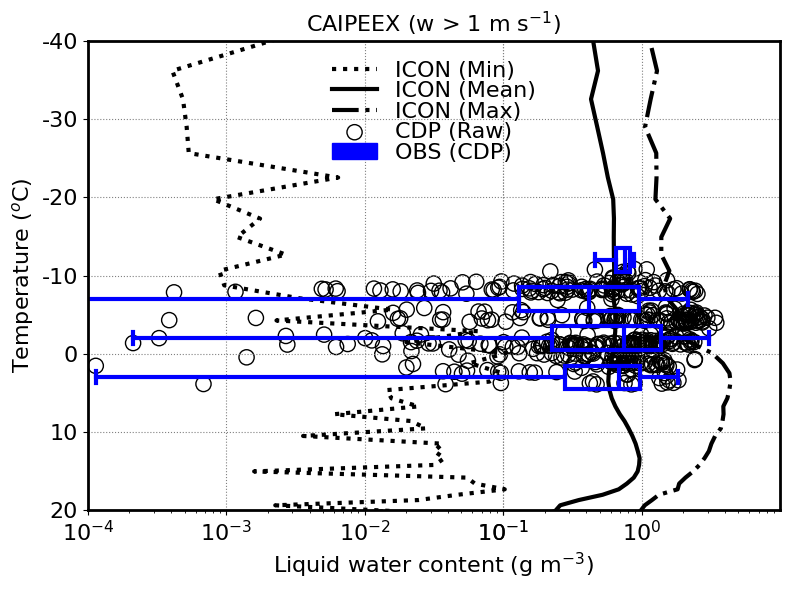

In [152]:




## ============== ICON
w_thres = 1.
thres_q = 1.e-6
###### Without SIP
# lwc gperm3
lwc_4sip_up_gperm3 = xr.where((ds_4sip_new.qc > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.lwc_gperm3, np.nan)
median_lwc_4sip_up_gperm3 = lwc_sip_up_gperm3.median(dim=('time','ncells'))
mean_lwc_4sip_up_gperm3 = lwc_sip_up_gperm3.mean(dim=('time','ncells'))
min_lwc_4sip_up_gperm3 = lwc_sip_up_gperm3.min(dim=('time','ncells'))
max_lwc_4sip_up_gperm3 = lwc_sip_up_gperm3.max(dim=('time','ncells'))
avg_4sip_tempc = ds_4sip_new.tempc.mean(dim=('time','ncells')) 

std_lwc_4sip_up_gperm3 = lwc_4sip_up_gperm3.std(dim=('time', 'ncells'), skipna=True)
count_lwc_4sip_up_gperm3 = lwc_4sip_up_gperm3.count(dim=('time', 'ncells'))

se_lwc_4sip_up_gperm3 = std_lwc_4sip_up_gperm3 / np.sqrt(count_lwc_4sip_up_gperm3)

## ================

#temp_cdp_bin = np.arange(-30, 30, 5)
#temp_cdp_bin = np.sort(temp_cdp_bin)
#df_v2_hvps_comb['temp_cdp_bin'] = np.digitize(df_v2_hvps_comb['tempc'], bins=temp_cdp_bin, right=False)

#bin_edges = np.concatenate([temp_cdp_bin - 2, [temp_cdp_bin[-1] + 2]])  
#df_v2_hvps_comb['temp_bin'] = bin_edges[df_v2_hvps_comb['temp_cdp_bin']]


# LWC-CDP
df_v2 = pd.DataFrame(ds_v2)

temp_cdp_bin = np.arange(-30, 30, 5)
temp_cdp_bin = np.sort(temp_cdp_bin)

df_v2['temp_cdp_bin'] = np.digitize(df_v2['tempc'], bins=temp_cdp_bin, right=False)

bin_edges = np.concatenate([temp_cdp_bin - 2, [temp_cdp_bin[-1] + 2]])  
df_v2['temp_bin'] = bin_edges[df_v2['temp_cdp_bin']]

# LWC
df_lwc_up_cdp = df_v2[['lwc_cdp_up_gperm3', 'temp_bin']].dropna()
df_lwc_up_cdp = df_lwc_up_cdp.dropna(subset=['temp_bin'])
lwc_cdp_up_by_bin = [df_lwc_up_cdp[df_lwc_up_cdp['temp_bin'] == temp]['lwc_cdp_up_gperm3'].values for temp in bin_edges]



# LWC-CDP
#df_lwc_up_cdp = df_v2[['lwc_cdp_up_gperm3', 'temp_bin']].dropna()
#df_lwc_up_cdp = df_lwc_up_cdp.dropna(subset=['temp_bin'])
#lwc_cdp_up_by_bin = [df_lwc_up_cdp[df_lwc_up_cdp['temp_bin'] == temp]['lwc_cdp_up_gperm3'].values for temp in bin_edges]


fnt=16;
ln=3;
ln1=3;
al1=1.#0.4;
al2=1.#0.6;
al3=0.3
wd=3
fig, ax = plt.subplots(figsize=(8,6))
plt.style.use('default')

#ax.plot(min_lwc_4sip_up_gperm3, avg_4sip_tempc, 'k-.', linewidth=ln, label='ICON (Min)');
#ax.plot(median_lwc_4sip_up_gperm3, avg_4sip_tempc, 'k--', linewidth=ln, label='ICON (Median)');
#ax.plot(mean_lwc_4sip_up_gperm3, avg_4sip_tempc, 'k-', linewidth=ln, label='ICON (Control)');
#ax.plot(max_lwc_4sip_up_gperm3, avg_4sip_tempc, 'k:', linewidth=ln, label='ICON (Max)');


ax.plot(min_lwc_4sip_up_gperm3, avg_4sip_tempc, 'k:', linewidth=ln, label='ICON (Min)');
ax.plot(mean_lwc_4sip_up_gperm3, avg_4sip_tempc, 'k-', linewidth=ln, label='ICON (Mean)');
ax.plot(max_lwc_4sip_up_gperm3, avg_4sip_tempc, 'k-.', linewidth=ln, label='ICON (Max)');

#ax.fill_betweenx(avg_4sip_tempc.values,
#                 (mean_lwc_4sip_up_gperm3 - 1*std_lwc_4sip_up_gperm3).values,
#                 (mean_lwc_4sip_up_gperm3 + 1*std_lwc_4sip_up_gperm3).values,
#                 color='k', alpha=0.2, label='ICON $\pm$ 1 STD DEV')


ax.scatter(df_v2['lwc_cdp_up_gperm3'], df_v2['air_temp'], marker='o', s=120, 
           facecolors='none', edgecolors='k', alpha=al1, label='CDP (Raw)')

#ax.scatter(df_v2_hvps_comb['lwc_nev_up_gperm3'], df_v2_hvps_comb['air_temp'], marker='o', s=120, 
#           facecolors='orange', edgecolors='orange', alpha=al3, label='Nev (Raw)')

#ax.scatter(df_v2_hvps_comb['lwc_king_up_gperm3'], df_v2_hvps_comb['air_temp'], marker='o', s=120, 
#           facecolors='red', edgecolors='red', alpha=al3, label='King (Raw)')

#ax.scatter(df_v2_hvps_comb['lwc_nev_up_gperm3'], df_v2_hvps_comb['air_temp'], marker='o', s=120, 
#           facecolors='orange', edgecolors='orange', alpha=al3, label='Nev (Raw)')

#ax.boxplot(cdnc_sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True, widths=wd,
#            boxprops=dict(facecolor='none', edgecolor='black', linewidth=ln1, alpha=al1),
#            medianprops=dict(color='black', linewidth=ln1),
#            whiskerprops=dict(linewidth=ln1, color='black', alpha=al1),
#            capprops=dict(linewidth=ln1, color='black', alpha=al1), showfliers=False);

ax.boxplot(lwc_cdp_up_by_bin[:], positions=bin_edges[:], vert=False, patch_artist=True, widths=wd,
           boxprops=dict(facecolor='none', edgecolor='blue', linewidth=ln, alpha=al2),
           medianprops=dict(color='blue', linewidth=ln),
           whiskerprops=dict(linewidth=ln, color='blue', alpha=al2),
           capprops=dict(linewidth=ln, color='blue', alpha=al2), showfliers=False)


#ax.boxplot(lwc_king_up_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True, widths=wd,
#           boxprops=dict(facecolor='none', edgecolor='red', linewidth=ln, alpha=al2),
#           medianprops=dict(color='red', linewidth=ln),
#           whiskerprops=dict(linewidth=ln, color='red', alpha=al2),
#           capprops=dict(linewidth=ln, color='red', alpha=al2), showfliers=False)


#ax.boxplot(lwc_nev_up_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True, widths=wd,
#           boxprops=dict(facecolor='none', edgecolor='magenta', linewidth=ln, alpha=al2),
#           medianprops=dict(color='magenta', linewidth=ln),
#           whiskerprops=dict(linewidth=ln, color='magenta', alpha=al2),
#           capprops=dict(linewidth=ln, color='magenta', alpha=al2), showfliers=False)

# Set the scale to log for the x-axis
ax.set_xscale('log')
ax.set_xlim(1.e-4, 1.e1)
ax.set_xticks([1.e-4, 1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e-1])
#ax.set_xticklabels([1.e-4, 1.e-2, 1.e0, 1.e2, 1.e4, 1.e6], fontsize=fontsize)

ax.set_xlabel('Liquid water content (g m$^{-3}$)', fontsize=fnt)
ax.tick_params(axis='x', labelsize=fnt)

# Set y-axis labels
ax.set_ylim(20, -40)
ax.set_ylabel('Temperature ($^{o}$C)', fontsize=fnt)
ax.set_yticks([20, 10, 0, -10, -20, -30, -40])
ax.set_yticklabels(['20', '10', '0', '-10', '-20', '-30', '-40'], fontsize=fnt)


ax.set_title('CAIPEEX (w > 1 m s$^{-1}$)', fontsize=fnt)

# Customize grid
ax.grid(True, linestyle=':', color='grey', alpha=al1)

# Add legends for boxplots and ICON line
handles, labels = ax.get_legend_handles_labels()

obs_icon_patch = mpatches.Patch(color='black', label='ICON')
obs_cip_patch = mpatches.Patch(color='blue', label='OBS (CDP)')

#ax.legend(handles=handles + [obs_icon_patch, obs_cip_patch, obs_hvps_patch], frameon=False, loc='best', fontsize=fnt)
ax.legend(handles=handles + [obs_cip_patch], frameon=False, loc='best', labelspacing=0.02, fontsize=fnt)

# Customize axis spines
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['left'].set_linewidth(2)
#ax.spines['bottom'].set_linewidth(2)

for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(2)
    ax.spines[spine].set_color('black')
    
# Display the plot
plt.tight_layout()
plt.show()


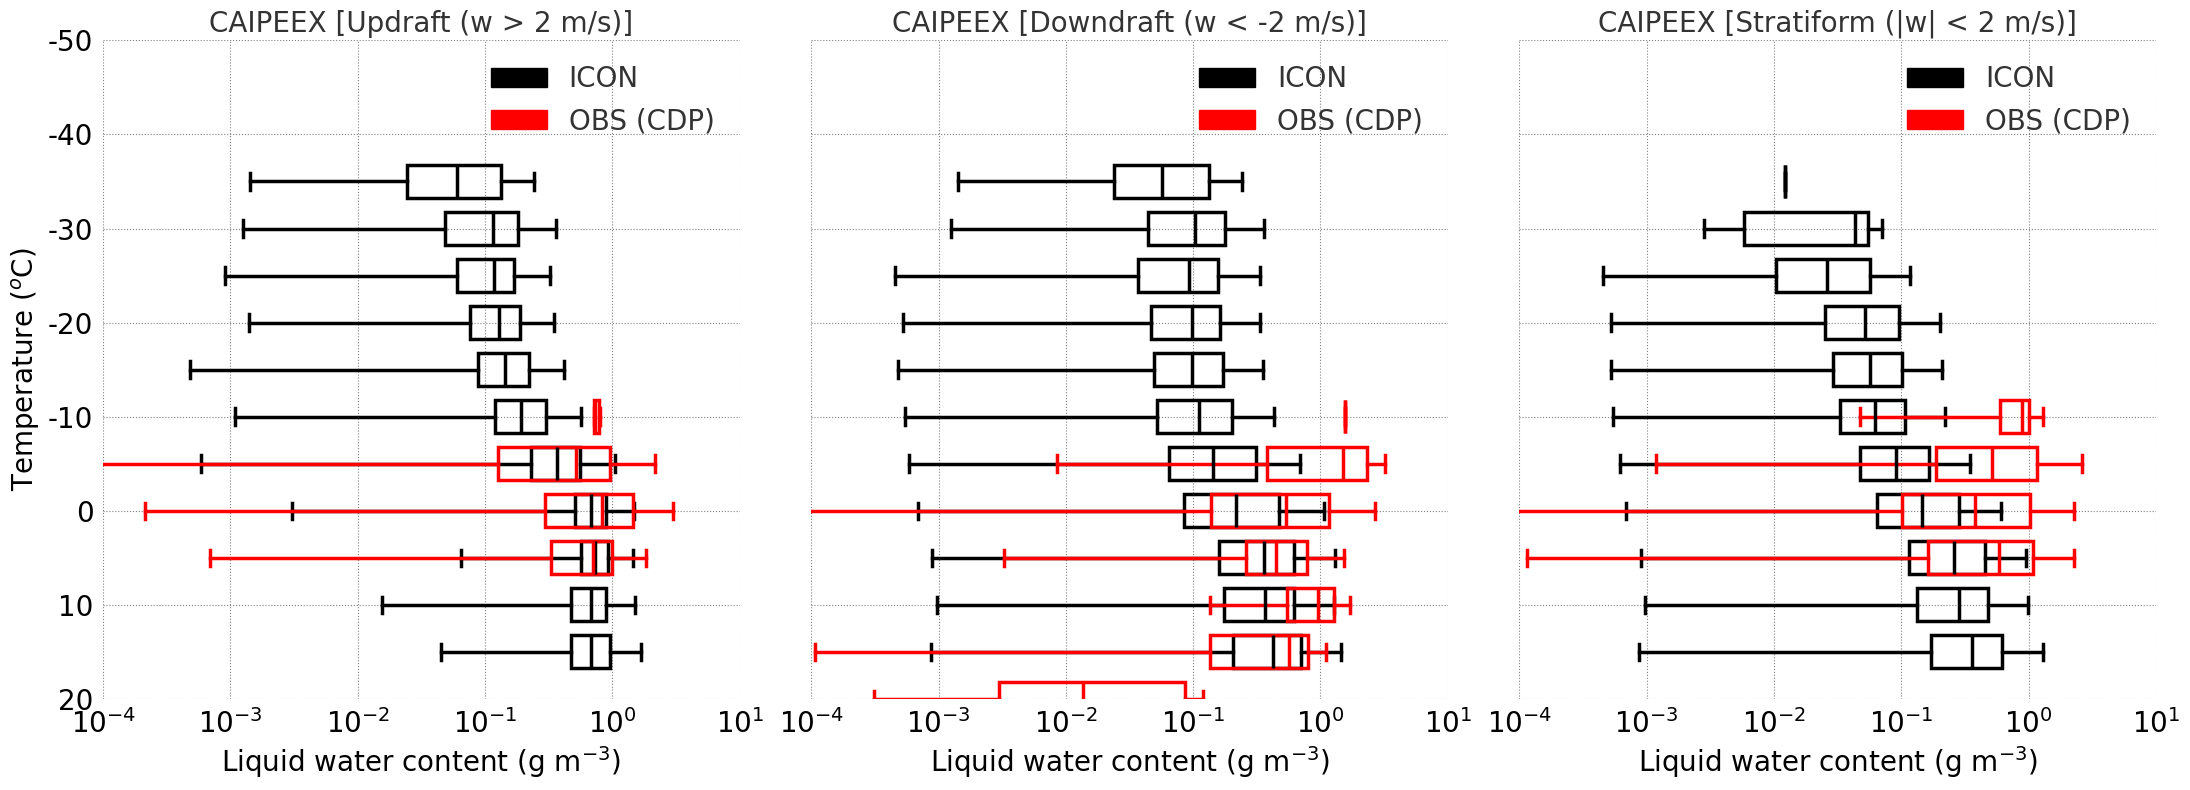

In [30]:


df_v2 = pd.DataFrame(ds_v2)


temp_cdp_bin = np.arange(-30, 30, 5)
temp_cdp_bin = np.sort(temp_cdp_bin)

df_v2['temp_cdp_bin'] = np.digitize(df_v2['tempc'], bins=temp_cdp_bin, right=False)

bin_edges = np.concatenate([temp_cdp_bin - 2, [temp_cdp_bin[-1] + 2]])  
df_v2['temp_bin'] = bin_edges[df_v2['temp_cdp_bin']]

# LWC
df_lwc_up_cdp = df_v2[['lwc_cdp_up_gperm3', 'temp_bin']].dropna()
df_lwc_dn_cdp = df_v2[['lwc_cdp_dn_gperm3', 'temp_bin']].dropna()
df_lwc_st_cdp = df_v2[['lwc_cdp_st_gperm3', 'temp_bin']].dropna()

df_lwc_up_cdp = df_lwc_up_cdp.dropna(subset=['temp_bin'])
df_lwc_dn_cdp = df_lwc_dn_cdp.dropna(subset=['temp_bin'])
df_lwc_st_cdp = df_lwc_st_cdp.dropna(subset=['temp_bin'])

lwc_cdp_up_by_bin = [df_lwc_up_cdp[df_lwc_up_cdp['temp_bin'] == temp]['lwc_cdp_up_gperm3'].values for temp in bin_edges]
lwc_cdp_dn_by_bin = [df_lwc_dn_cdp[df_lwc_dn_cdp['temp_bin'] == temp]['lwc_cdp_dn_gperm3'].values for temp in bin_edges]
lwc_cdp_st_by_bin = [df_lwc_st_cdp[df_lwc_st_cdp['temp_bin'] == temp]['lwc_cdp_st_gperm3'].values for temp in bin_edges]

# CDNC
df_cdnc_up_cdp = df_v2[['cdnc_cdp_up_percm3', 'temp_bin']].dropna()
df_cdnc_dn_cdp = df_v2[['cdnc_cdp_dn_percm3', 'temp_bin']].dropna()
df_cdnc_st_cdp = df_v2[['cdnc_cdp_st_percm3', 'temp_bin']].dropna()

df_cdnc_up_cdp = df_cdnc_up_cdp.dropna(subset=['temp_bin'])
df_cdnc_dn_cdp = df_cdnc_dn_cdp.dropna(subset=['temp_bin'])
df_cdnc_st_cdp = df_cdnc_st_cdp.dropna(subset=['temp_bin'])

cdnc_cdp_up_by_bin = [df_cdnc_up_cdp[df_cdnc_up_cdp['temp_bin'] == temp]['cdnc_cdp_up_percm3'].values for temp in bin_edges]
cdnc_cdp_dn_by_bin = [df_cdnc_dn_cdp[df_cdnc_dn_cdp['temp_bin'] == temp]['cdnc_cdp_dn_percm3'].values for temp in bin_edges]
cdnc_cdp_st_by_bin = [df_cdnc_st_cdp[df_cdnc_st_cdp['temp_bin'] == temp]['cdnc_cdp_st_percm3'].values for temp in bin_edges]


fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['CAIPEEX [Updraft (w > 2 m/s)]', 'CAIPEEX [Downdraft (w < -2 m/s)]', 'CAIPEEX [Stratiform (|w| < 2 m/s)]']

fontsize = 20;
linewidth = 2.5;
width=3.5;
alpha1=1;
alpha2=1.;
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        #ax.plot(lwc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(lwc_sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(lwc_cdp_up_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
    elif i == 1:
        #ax.plot(lwc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(lwc_sip_dn_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(lwc_cdp_dn_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
    elif i == 2:
        #ax.plot(lwc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        
        ax.boxplot(lwc_sip_st_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(lwc_cdp_st_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)

    ax.set_xscale('log')
    ax.set_xlim(1.e-4, 1.e1)
    ax.set_xticklabels([1.e-4, 1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)
    ax.set_ylim(20, -50)
    #ax.set_yticklabels([20, 10, 0, -10, -20, -30, -40], fontsize=fontsize)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Liquid water content (g m$^{-3}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=1.0)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch1 = mpatches.Patch(color='black', label='ICON')
    obs_patch2 = mpatches.Patch(color='red', label='OBS (CDP)')

    ax.legend(handles=handles + [obs_patch1, obs_patch2], frameon=False, loc='upper right', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([20, 10, 0, -10, -20, -30, -40, -50])
axes[0].set_yticklabels(['20', '10', '0', '-10', '-20', '-30', '-40', '-50'], fontsize=fontsize)
#axes[0].set_yticks([20, 10, 0, -10, -20, -30, -40])
#axes[0].set_yticklabels(['20', '10', '0', '-10', '-20', '-30', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()

In [39]:

count_per_bin = df_cdnc_up_cdp.groupby('temp_bin')['cdnc_cdp_up_percm3'].count()

# Print the result
print(count_per_bin)

temp_bin
-12      5
-7     107
-2     185
 3      89
Name: cdnc_cdp_up_percm3, dtype: int64


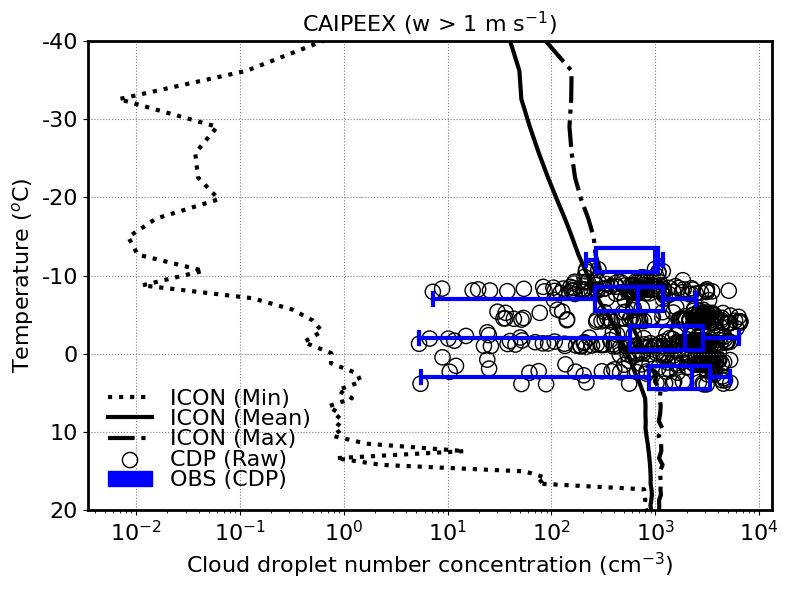

In [153]:





## ============== ICON
w_thres = 1.
thres_q = 1.e-3
###### Without SIP
# lwc gperm3
cdnc_4sip_up_percm3 = xr.where((ds_4sip_new.qc > thres_q) & (ds_4sip_new.w_vel > w_thres), 
                               ds_4sip_new.cdnc_percm3, np.nan)
median_cdnc_4sip_up_percm3 = cdnc_sip_up_percm3.median(dim=('time','ncells'))
mean_cdnc_4sip_up_percm3 = cdnc_sip_up_percm3.mean(dim=('time','ncells'))
min_cdnc_4sip_up_percm3 = cdnc_sip_up_percm3.min(dim=('time','ncells'))
max_cdnc_4sip_up_percm3 = cdnc_sip_up_percm3.max(dim=('time','ncells'))
avg_4sip_tempc = ds_4sip_new.tempc.mean(dim=('time','ncells')) 

std_cdnc_4sip_up_percm3 = cdnc_4sip_up_percm3.std(dim=('time', 'ncells'), skipna=True)
count_cdnc_4sip_up_percm3 = cdnc_4sip_up_percm3.count(dim=('time', 'ncells'))
se_cdnc_4sip_up_percm3 = std_cdnc_4sip_up_percm3 / np.sqrt(count_cdnc_4sip_up_percm3)

## ================

#temp_cdp_bin = np.arange(-30, 30, 5)
#temp_cdp_bin = np.sort(temp_cdp_bin)
#df_v2_hvps_comb['temp_cdp_bin'] = np.digitize(df_v2_hvps_comb['tempc'], bins=temp_cdp_bin, right=False)

#bin_edges = np.concatenate([temp_cdp_bin - 2, [temp_cdp_bin[-1] + 2]])  
#df_v2_hvps_comb['temp_bin'] = bin_edges[df_v2_hvps_comb['temp_cdp_bin']]


# LWC-CDP
df_v2 = pd.DataFrame(ds_v2)

temp_cdp_bin = np.arange(-30, 30, 5)
temp_cdp_bin = np.sort(temp_cdp_bin)

df_v2['temp_cdp_bin'] = np.digitize(df_v2['tempc'], bins=temp_cdp_bin, right=False)

bin_edges = np.concatenate([temp_cdp_bin - 2, [temp_cdp_bin[-1] + 2]])  
df_v2['temp_bin'] = bin_edges[df_v2['temp_cdp_bin']]

# LWC
df_cdnc_up_cdp = df_v2[['cdnc_cdp_up_percm3', 'temp_bin']].dropna()
df_cdnc_up_cdp = df_cdnc_up_cdp.dropna(subset=['temp_bin'])
cdnc_cdp_up_by_bin = [df_cdnc_up_cdp[df_cdnc_up_cdp['temp_bin'] == temp]['cdnc_cdp_up_percm3'].values for temp in bin_edges]


fnt=16;
ln=3;
ln1=3;
al1=1.#0.4;
al2=1.#0.6;
al3=0.3
wd=3
fig, ax = plt.subplots(figsize=(8,6))

#ax.plot(min_inc_4sip_up_perl, avg_tempc, 'k-.', linewidth=ln, label='ICON (Min)');
#ax.plot(median_cdnc_4sip_up_percm3, avg_tempc, 'k--', linewidth=ln, label='ICON (Median)');
#ax.plot(mean_cdnc_4sip_up_percm3, avg_4sip_tempc, 'k-', linewidth=ln, label='ICON (Control)');
#ax.plot(max_cdnc_4sip_up_percm3, avg_tempc, 'k:', linewidth=ln, label='ICON (Max)');



ax.plot(min_cdnc_4sip_up_percm3, avg_4sip_tempc, 'k:', linewidth=ln, label='ICON (Min)');
ax.plot(mean_cdnc_4sip_up_percm3, avg_4sip_tempc, 'k-', linewidth=ln, label='ICON (Mean)');
ax.plot(max_cdnc_4sip_up_percm3, avg_4sip_tempc, 'k-.', linewidth=ln, label='ICON (Max)');

#ax.fill_betweenx(avg_4sip_tempc.values,
#                 (mean_cdnc_4sip_up_percm3 - std_cdnc_4sip_up_percm3).values,
#                 (mean_cdnc_4sip_up_percm3 + std_cdnc_4sip_up_percm3).values,
#                 color='k', alpha=0.2, label='ICON $\pm$ 1 STD DEV')

ax.scatter(df_v2['cdnc_cdp_up_percm3'], df_v2['air_temp'], marker='o', s=120, 
           facecolors='none', edgecolors='k', alpha=al1, label='CDP (Raw)')

#ax.scatter(df_v2_hvps_comb['lwc_nev_up_gperm3'], df_v2_hvps_comb['air_temp'], marker='o', s=120, 
#           facecolors='orange', edgecolors='orange', alpha=al3, label='Nev (Raw)')

#ax.scatter(df_v2_hvps_comb['lwc_king_up_gperm3'], df_v2_hvps_comb['air_temp'], marker='o', s=120, 
#           facecolors='red', edgecolors='red', alpha=al3, label='King (Raw)')

#ax.scatter(df_v2_hvps_comb['lwc_nev_up_gperm3'], df_v2_hvps_comb['air_temp'], marker='o', s=120, 
#           facecolors='orange', edgecolors='orange', alpha=al3, label='Nev (Raw)')

#ax.boxplot(cdnc_sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True, widths=wd,
#            boxprops=dict(facecolor='none', edgecolor='black', linewidth=ln1, alpha=al1),
#            medianprops=dict(color='black', linewidth=ln1),
#            whiskerprops=dict(linewidth=ln1, color='black', alpha=al1),
#            capprops=dict(linewidth=ln1, color='black', alpha=al1), showfliers=False);

ax.boxplot(cdnc_cdp_up_by_bin[:], positions=bin_edges[:], vert=False, patch_artist=True, widths=wd,
           boxprops=dict(facecolor='none', edgecolor='blue', linewidth=ln, alpha=al2),
           medianprops=dict(color='blue', linewidth=ln),
           whiskerprops=dict(linewidth=ln, color='blue', alpha=al2),
           capprops=dict(linewidth=ln, color='blue', alpha=al2), showfliers=False)


#ax.boxplot(lwc_king_up_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True, widths=wd,
#           boxprops=dict(facecolor='none', edgecolor='red', linewidth=ln, alpha=al2),
#           medianprops=dict(color='red', linewidth=ln),
#           whiskerprops=dict(linewidth=ln, color='red', alpha=al2),
#           capprops=dict(linewidth=ln, color='red', alpha=al2), showfliers=False)


#ax.boxplot(lwc_nev_up_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True, widths=wd,
#           boxprops=dict(facecolor='none', edgecolor='magenta', linewidth=ln, alpha=al2),
#           medianprops=dict(color='magenta', linewidth=ln),
#           whiskerprops=dict(linewidth=ln, color='magenta', alpha=al2),
#           capprops=dict(linewidth=ln, color='magenta', alpha=al2), showfliers=False)

# Set the scale to log for the x-axis
ax.set_xscale('log')
#ax.set_xlim(1.e0, 1.e4)
#ax.set_xticks([1.e0, 1.e1, 1.e2, 1.e3, 1.e4])
#ax.set_xticklabels([1.e-4, 1.e-2, 1.e0, 1.e2, 1.e4, 1.e6], fontsize=fontsize)

ax.set_xlabel('Cloud droplet number concentration (cm$^{-3}$)', fontsize=fnt)
ax.tick_params(axis='x', labelsize=fnt)

# Set y-axis labels
ax.set_ylim(20, -40)
ax.set_ylabel('Temperature ($^{o}$C)', fontsize=fnt)
ax.set_yticks([20, 10, 0, -10, -20, -30, -40])
ax.set_yticklabels(['20', '10', '0', '-10', '-20', '-30', '-40'], fontsize=fnt)


ax.set_title('CAIPEEX (w > 1 m s$^{-1}$)', fontsize=fnt)

# Customize grid
ax.grid(True, linestyle=':', color='grey', alpha=al1)

# Add legends for boxplots and ICON line
handles, labels = ax.get_legend_handles_labels()

obs_icon_patch = mpatches.Patch(color='black', label='ICON')
obs_cip_patch = mpatches.Patch(color='blue', label='OBS (CDP)')

#ax.legend(handles=handles + [obs_icon_patch, obs_cip_patch, obs_hvps_patch], frameon=False, loc='best', fontsize=fnt)
ax.legend(handles=handles + [obs_cip_patch], frameon=False, loc='best', labelspacing=0.02, fontsize=fnt)

# Customize axis spines
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['left'].set_linewidth(2)
#ax.spines['bottom'].set_linewidth(2)

for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(2)
    ax.spines[spine].set_color('black')
    
# Display the plot
plt.tight_layout()
plt.show()


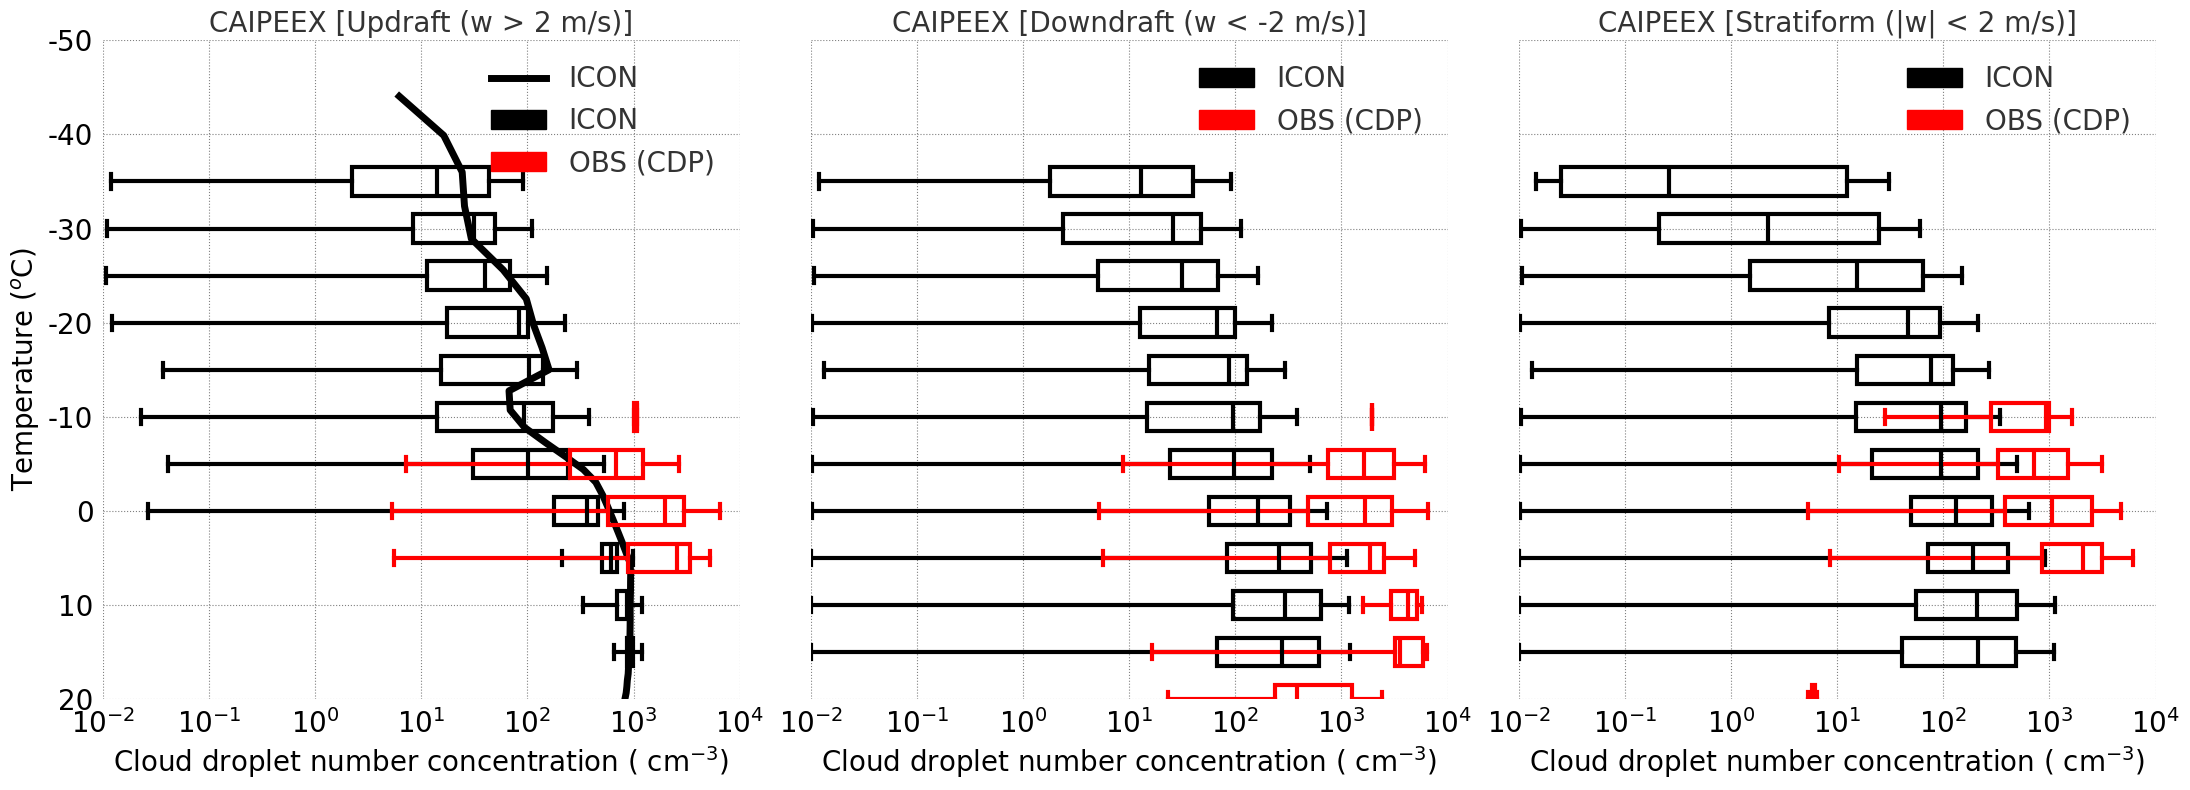

In [40]:


cdnc_sip_up_percm3 = xr.where((ds_4sip_new.cdnc_percm3 > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.cdnc_percm3, np.nan)
avg_cdnc_sip_up_percm3 = cdnc_sip_up_percm3.median(dim=('time','ncells'))
avg_tempc = ds_4sip_new.tempc.mean(dim=('time','ncells')) 


fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['CAIPEEX [Updraft (w > 2 m/s)]', 'CAIPEEX [Downdraft (w < -2 m/s)]', 'CAIPEEX [Stratiform (|w| < 2 m/s)]']

fontsize = 20;
linewidth = 3;
width=3
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        #ax.plot(cdnc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.plot(avg_cdnc_sip_up_percm3, avg_tempc, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(cdnc_sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(cdnc_cdp_up_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
    elif i == 1:
        #ax.plot(cdnc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(cdnc_sip_dn_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(cdnc_cdp_dn_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
    elif i == 2:
        #ax.plot(cdnc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(cdnc_sip_st_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(cdnc_cdp_st_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)

    ax.set_xscale('log')
    ax.set_xlim(1.e-2, 1.e4)
    ax.set_xticklabels([1.e-2, 1.e-1, 1.e0, 1.e1, 1.e2, 1.e3, 1.e4], fontsize=fontsize)
    ax.set_ylim(20, -50)
    #ax.set_yticklabels([20, 10, 0, -10, -20, -30, -40], fontsize=fontsize)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Cloud droplet number concentration ( cm$^{-3}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=1.0)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch1 = mpatches.Patch(color='black', label='ICON')
    obs_patch2 = mpatches.Patch(color='red', label='OBS (CDP)')

    ax.legend(handles=handles + [obs_patch1, obs_patch2], frameon=False, loc='upper right', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([20, 10, 0, -10, -20, -30, -40, -50])
axes[0].set_yticklabels(['20', '10', '0', '-10', '-20', '-30', '-40', '-50'], fontsize=fontsize)
#axes[0].set_yticks([20, 10, 0, -10, -20, -30, -40])
#axes[0].set_yticklabels(['20', '10', '0', '-10', '-20', '-30', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()

In [107]:

####================== Boxplot of ICON-INC [3-SIP]
w_thres = 1.
thres_q = 1.e-3
###### Without SIP
# lwc gperm3
#inc_sip_up_perl = xr.where((ds_4sip_new.inc_perl > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.inc_perl, np.nan)
#inc_sip_dn_perl = xr.where((ds_4sip_new.inc_perl > thres_q) & (ds_4sip_new.w_vel > -1.*w_thres), ds_4sip_new.inc_perl, np.nan)
#inc_sip_st_perl = xr.where((ds_4sip_new.inc_perl > thres_q) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.inc_perl, np.nan)


thres_q = 1.e-4
inc_sip_up_perl = xr.where((ds_4sip_new.tqi > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.inc_perl, np.nan)
inc_sip_dn_perl = xr.where((ds_4sip_new.tqi > thres_q) & (ds_4sip_new.w_vel > -1.*w_thres), ds_4sip_new.inc_perl, np.nan)
inc_sip_st_perl = xr.where((ds_4sip_new.tqi > thres_q) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.inc_perl, np.nan)
tempc_sip = ds_4sip_new.tempc

inc_sip_up_perl = inc_sip_up_perl.values.flatten()
inc_sip_dn_perl = inc_sip_dn_perl.values.flatten()
inc_sip_st_perl = inc_sip_st_perl.values.flatten()
tempc_sip = tempc_sip.values.flatten()

df_inc_sip = pd.DataFrame({
    'inc_up': inc_sip_up_perl,
    'inc_dn': inc_sip_dn_perl,
    'inc_st': inc_sip_st_perl,
    'tempc': tempc_sip,
})

tempc_bin = np.arange(-50., 20., 5.)  # Temperature bins 
tempc_bin = np.sort(tempc_bin)

df_inc_sip['temp_bin'] = np.digitize(df_inc_sip['tempc'], bins=tempc_bin, right=False)

bin_edges = np.concatenate([tempc_bin - 2, [tempc_bin[-1] + 2]])  
df_inc_sip['temp_bin'] = bin_edges[df_inc_sip['temp_bin']]

df_inc_up_sip = df_inc_sip[['inc_up', 'temp_bin']].dropna()
df_inc_dn_sip = df_inc_sip[['inc_dn', 'temp_bin']].dropna()
df_inc_st_sip = df_inc_sip[['inc_st', 'temp_bin']].dropna()

df_inc_up_sip = df_inc_up_sip.dropna(subset=['temp_bin'])
df_inc_dn_sip = df_inc_dn_sip.dropna(subset=['temp_bin'])
df_inc_st_sip = df_inc_st_sip.dropna(subset=['temp_bin'])

inc_sip_up_by_bin = [df_inc_up_sip[df_inc_up_sip['temp_bin'] == temp]['inc_up'].values for temp in bin_edges]
inc_sip_dn_by_bin = [df_inc_dn_sip[df_inc_dn_sip['temp_bin'] == temp]['inc_dn'].values for temp in bin_edges]
inc_sip_st_by_bin = [df_inc_st_sip[df_inc_st_sip['temp_bin'] == temp]['inc_st'].values for temp in bin_edges]


In [217]:
tempc_sip

array([-69.62938 , -69.61676 , -69.65001 , ...,  26.574768,  26.46463 ,
        26.789429], dtype=float32)

In [46]:
df_v2

time  alt     lon     lat  air_speed  air_temp    pres  rel_hum  \
0      26290  402  17.622  75.939      11.00     31.73  957.24     69.7   
1      26291  402  17.622  75.939      10.89     31.63  957.32     69.7   
2      26292  402  17.622  75.939      12.51     31.50  957.36     70.1   
3      26293  402  17.622  75.939      14.16     31.39  957.44     70.3   
4      26294  402  17.622  75.939      16.77     31.40  957.60     70.3   
...      ...  ...     ...     ...        ...       ...     ...      ...   
11373  37682  412  17.627  75.935      14.15     32.32  953.74     64.6   
11374  37683  412  17.627  75.935      14.45     32.46  953.92     64.7   
11375  37684  412  17.627  75.935      16.23     32.37  954.18     64.2   
11376  37685  412  17.627  75.935      15.93     32.31  953.86     64.4   
11377  37686  412  17.627  75.935      16.61     32.26  954.02     64.4   

       wind_spped  wind_dir  ...  tempc  nice_cip_up  cdnc_cdp_up_percm3  \
0          -999.0      90.0  ...  31.73          NaN                 NaN   
1          -999.0      90.0  ...  31.63          NaN                 NaN   
2          -999.0      90.0  ...  31.50          NaN                 NaN   
3          -999.0      90.0  ...  31.39          NaN                 NaN   
4          -999.0      90.0  ...  31.40          NaN                 NaN   
...           ...       ...  ...    ...          ...                 ...   
11373      -999.0      90.0  ...  32.32     0.003835                 NaN   
11374      -999.0      90.0  ...  32.46     0.017418                 NaN   
11375      -999.0      90.0  ...  32.37     0.097484                 NaN   
11376      -999.0      90.0  ...  32.31          NaN                 NaN   
11377      -999.0      90.0  ...  32.26          NaN                 NaN   

       cdnc_cdp_dn_percm3  cdnc_cdp_st_percm3  lwc_cdp_up_gperm3  \
0                     NaN                 NaN                NaN   
1                     NaN                 NaN                NaN   
2                     NaN                 NaN                NaN   
3                     NaN                 NaN                NaN   
4                     NaN                 NaN                NaN   
...                   ...                 ...                ...   
11373                 NaN                 NaN                NaN   
11374                 NaN              6.9203                NaN   
11375                 NaN                 NaN                NaN   
11376                 NaN                 NaN                NaN   
11377                 NaN             10.2450                NaN   

       lwc_cdp_dn_gperm3  lwc_cdp_st_gperm3  temp_bin  temp_cdp_bin  
0                    NaN                NaN        27            12  
1                    NaN                NaN        27            12  
2                    NaN                NaN        27            12  
3                    NaN                NaN        27            12  
4                    NaN                NaN        27            12  
...                  ...                ...       ...           ...  
11373                NaN                NaN        27            12  
11374                NaN                NaN        27            12  
11375                NaN                NaN        27            12  
11376                NaN                NaN        27            12  
11377                NaN                NaN        27            12  

[11378 rows x 50 columns]

/home/b/b382718/own_env/lib/python3.9/site-packages/dask/array/numpy_compat.py:56: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


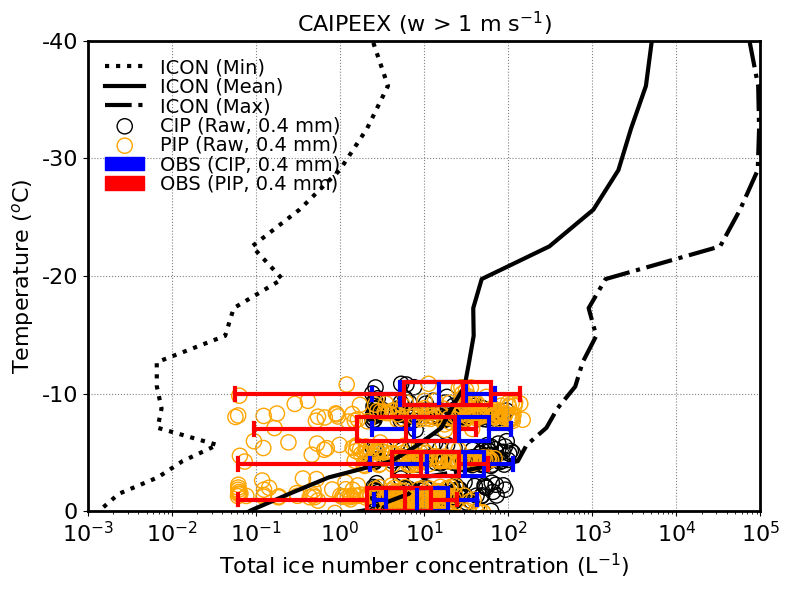

In [155]:





## ============== ICON
w_thres = 1.
thres_q = 1.e-3

###### With SIP
inc_4sip_up_perl = xr.where((ds_4sip_new.tqi > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.inc_perl, np.nan)
median_inc_4sip_up_perl = inc_4sip_up_perl.median(dim=('time','ncells'))
mean_inc_4sip_up_perl = inc_4sip_up_perl.mean(dim=('time','ncells'))
min_inc_4sip_up_perl = inc_4sip_up_perl.min(dim=('time','ncells'))
max_inc_4sip_up_perl = inc_4sip_up_perl.max(dim=('time','ncells'))
avg_4sip_tempc = ds_4sip_new.tempc.mean(dim=('time','ncells')) 

std_inc_4sip_up_perl = inc_4sip_up_perl.std(dim=('time', 'ncells'), skipna=True)
count_inc_4sip_up_perl = inc_4sip_up_perl.count(dim=('time', 'ncells'))
se_inc_4sip_up_perl = std_inc_4sip_up_perl / np.sqrt(count_inc_4sip_up_perl)


###### Without SIP
inc_nosip_up_perl = xr.where((ds_nosip_new.tqi > thres_q) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.inc_perl, np.nan)
median_inc_nosip_up_perl = inc_nosip_up_perl.median(dim=('time','ncells'))
mean_inc_nosip_up_perl = inc_nosip_up_perl.mean(dim=('time','ncells'))
min_inc_nosip_up_perl = inc_nosip_up_perl.min(dim=('time','ncells'))
max_inc_nosip_up_perl = inc_nosip_up_perl.max(dim=('time','ncells'))
avg_nosip_tempc = ds_nosip_new.tempc.mean(dim=('time','ncells')) 

std_inc_nosip_up_perl = inc_nosip_up_perl.std(dim=('time', 'ncells'), skipna=True)
count_inc_nosip_up_perl = inc_nosip_up_perl.count(dim=('time', 'ncells'))
se_inc_nosip_up_perl = std_inc_nosip_up_perl / np.sqrt(count_inc_nosip_up_perl)
## ================



##=============== CIP
df_v2_cip_comb = pd.DataFrame(ds_v2_cip_comb)
temp_cip_bin = np.arange(-20, 20, 3)
temp_cip_bin = np.sort(temp_cip_bin)

df_v2_cip_comb['temp_pip_bin'] = np.digitize(df_v2_cip_comb['tempc'], bins=temp_cip_bin, right=False)

bin_edges = np.concatenate([temp_cip_bin - 2, [temp_cip_bin[-1] + 2]])  
df_v2_cip_comb['temp_bin'] = bin_edges[df_v2_cip_comb['temp_pip_bin']]

# TINC
df_nice_up_cip = df_v2_cip_comb[['ni400um_cip_up_perl', 'temp_bin']].dropna()
df_nice_up_cip = df_nice_up_cip.dropna(subset=['temp_bin'])
inc_cip_up_by_bin = [df_nice_up_cip[df_nice_up_cip['temp_bin'] == temp]['ni400um_cip_up_perl'].values for temp in bin_edges]

##=============== PIP
df_v2_pip_comb = pd.DataFrame(ds_v2_pip_comb)
temp_pip_bin = np.arange(-20, 20, 3)
temp_pip_bin = np.sort(temp_pip_bin)

df_v2_pip_comb['temp_pip_bin'] = np.digitize(df_v2_pip_comb['tempc'], bins=temp_pip_bin, right=False)

bin_edges = np.concatenate([temp_pip_bin - 2, [temp_pip_bin[-1] + 2]])  
df_v2_pip_comb['temp_bin'] = bin_edges[df_v2_pip_comb['temp_pip_bin']]

# TINC
df_nice_up_pip = df_v2_pip_comb[['ni400um_pip_up_perl', 'temp_bin']].dropna()
df_nice_up_pip = df_nice_up_pip.dropna(subset=['temp_bin'])
inc_pip_up_by_bin = [df_nice_up_pip[df_nice_up_pip['temp_bin'] == temp]['ni400um_pip_up_perl'].values for temp in bin_edges]

#===================================
lower_err_inc = np.clip(mean_inc_4sip_up_perl - std_inc_4sip_up_perl, 1e-6, None)#np.maximum(mean_inc_4sip_up_perl - std_inc_4sip_up_perl, 1e-2)
upper_err_inc = mean_inc_4sip_up_perl + std_inc_4sip_up_perl
#===================================

fnt=16;
ln=3;
ln1=3;
al1=1.#0.4;
al2=1.#0.6;
al3=0.3
wd=2
fig, ax = plt.subplots(figsize=(8,6))

#ax.plot(min_inc_sip_up_perl, avg_tempc, 'k-.', linewidth=ln, label='ICON (Min)');
#ax.plot(median_inc_4sip_up_perl, avg_4sip_tempc, 'k--', linewidth=ln, label='ICON (Median)');
#ax.plot(mean_inc_4sip_up_perl, avg_4sip_tempc, 'k-', linewidth=ln, label='ICON (Control)');
#ax.plot(max_inc_4sip_up_perl, avg_4sip_tempc, 'k:', linewidth=ln, label='ICON (Max)');

ax.plot(min_inc_4sip_up_perl, avg_4sip_tempc, 'k:', linewidth=ln, label='ICON (Min)');
ax.plot(mean_inc_4sip_up_perl, avg_4sip_tempc, 'k-', linewidth=ln, label='ICON (Mean)');
ax.plot(max_inc_4sip_up_perl, avg_4sip_tempc, 'k-.', linewidth=ln, label='ICON (Max)');

#ax.fill_betweenx(avg_4sip_tempc.values,
#                 (mean_inc_4sip_up_perl - 0.09*std_inc_4sip_up_perl).values,
#                 (mean_inc_4sip_up_perl + std_inc_4sip_up_perl).values,
#                 color='k', alpha=0.2, label='ICON $\pm$ 1 STD DEV')

#ax.plot(median_inc_nosip_up_perl, avg_nosip_tempc, 'k--', linewidth=ln, label='ICON (Median)');
#ax.plot(mean_inc_nosip_up_perl, avg_nosip_tempc, '--', color='k', linewidth=ln, label='ICON (No SIP)');
#ax.plot(max_inc_nosip_up_perl, avg_nosip_tempc, 'r:', linewidth=ln, label='ICON (Max)');


ax.scatter(df_v2_cip_comb['ni400um_cip_up_perl'], df_v2_cip_comb['air_temp'], marker='o', s=120, 
           facecolors='none', edgecolors='k', alpha=al1, label='CIP (Raw, 0.4 mm)')

ax.scatter(df_v2_pip_comb['ni400um_pip_up_perl'], df_v2_pip_comb['air_temp'], marker='o', s=120, 
           facecolors='none', edgecolors='orange', alpha=al1, label='PIP (Raw, 0.4 mm)')

#ax.scatter(df_v2_hvps_comb['lwc_nev_up_gperm3'], df_v2_hvps_comb['air_temp'], marker='o', s=120, 
#           facecolors='orange', edgecolors='orange', alpha=al3, label='Nev (Raw)')

#ax.scatter(df_v2_hvps_comb['lwc_king_up_gperm3'], df_v2_hvps_comb['air_temp'], marker='o', s=120, 
#           facecolors='red', edgecolors='red', alpha=al3, label='King (Raw)')

#ax.scatter(df_v2_hvps_comb['lwc_nev_up_gperm3'], df_v2_hvps_comb['air_temp'], marker='o', s=120, 
#           facecolors='orange', edgecolors='orange', alpha=al3, label='Nev (Raw)')

#ax.boxplot(cdnc_sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True, widths=wd,
#            boxprops=dict(facecolor='none', edgecolor='black', linewidth=ln1, alpha=al1),
#            medianprops=dict(color='black', linewidth=ln1),
#            whiskerprops=dict(linewidth=ln1, color='black', alpha=al1),
#            capprops=dict(linewidth=ln1, color='black', alpha=al1), showfliers=False);

ax.boxplot(inc_cip_up_by_bin[:], positions=bin_edges[:], vert=False, patch_artist=True, widths=wd,
           boxprops=dict(facecolor='none', edgecolor='blue', linewidth=ln, alpha=al2),
           medianprops=dict(color='blue', linewidth=ln),
           whiskerprops=dict(linewidth=ln, color='blue', alpha=al2),
           capprops=dict(linewidth=ln, color='blue', alpha=al2), showfliers=False)

ax.boxplot(inc_pip_up_by_bin[:], positions=bin_edges[:], vert=False, patch_artist=True, widths=wd,
           boxprops=dict(facecolor='none', edgecolor='red', linewidth=ln, alpha=al2),
           medianprops=dict(color='red', linewidth=ln),
           whiskerprops=dict(linewidth=ln, color='red', alpha=al2),
           capprops=dict(linewidth=ln, color='red', alpha=al2), showfliers=False)


#ax.boxplot(lwc_king_up_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True, widths=wd,
#           boxprops=dict(facecolor='none', edgecolor='red', linewidth=ln, alpha=al2),
#           medianprops=dict(color='red', linewidth=ln),
#           whiskerprops=dict(linewidth=ln, color='red', alpha=al2),
#           capprops=dict(linewidth=ln, color='red', alpha=al2), showfliers=False)


#ax.boxplot(lwc_nev_up_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True, widths=wd,
#           boxprops=dict(facecolor='none', edgecolor='magenta', linewidth=ln, alpha=al2),
#           medianprops=dict(color='magenta', linewidth=ln),
#           whiskerprops=dict(linewidth=ln, color='magenta', alpha=al2),
#           capprops=dict(linewidth=ln, color='magenta', alpha=al2), showfliers=False)

# Set the scale to log for the x-axis
ax.set_xscale('log')
ax.set_xlim(1.e-3, 1.e5)
ax.set_xticks([1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1, 1.e2, 1.e3, 1.e4, 1.e5])#, 1.e5])
#ax.set_xticklabels([1.e-4, 1.e-2, 1.e0, 1.e2, 1.e4, 1.e6], fontsize=fontsize)

ax.set_xlabel('Total ice number concentration (L$^{-1}$)', fontsize=fnt)
ax.tick_params(axis='x', labelsize=fnt)

# Set y-axis labels
ax.set_ylim(0, -40)
ax.set_ylabel('Temperature ($^{o}$C)', fontsize=fnt)
ax.set_yticks([0, -10, -20, -30, -40])
ax.set_yticklabels(['0', '-10', '-20', '-30', '-40'], fontsize=fnt)


ax.set_title('CAIPEEX (w > 1 m s$^{-1}$)', fontsize=fnt)

# Customize grid
ax.grid(True, linestyle=':', color='grey', alpha=al1)

# Add legends for boxplots and ICON line
handles, labels = ax.get_legend_handles_labels()

obs_icon_patch = mpatches.Patch(color='black', label='ICON')
obs_cip_patch = mpatches.Patch(color='blue', label='OBS (CIP, 0.4 mm)')
obs_pip_patch = mpatches.Patch(color='red', label='OBS (PIP, 0.4 mm)')

#ax.legend(handles=handles + [obs_icon_patch, obs_cip_patch, obs_hvps_patch], frameon=False, loc='best', fontsize=fnt)
ax.legend(handles=handles + [obs_cip_patch, obs_pip_patch], frameon=False, loc='best', labelspacing=0.02, fontsize=fnt-2)

# Customize axis spines
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['left'].set_linewidth(2)
#ax.spines['bottom'].set_linewidth(2)

for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(2)
    ax.spines[spine].set_color('black')
    
# Display the plot
plt.tight_layout()
plt.show()


/home/b/b382718/own_env/lib/python3.9/site-packages/dask/array/numpy_compat.py:56: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


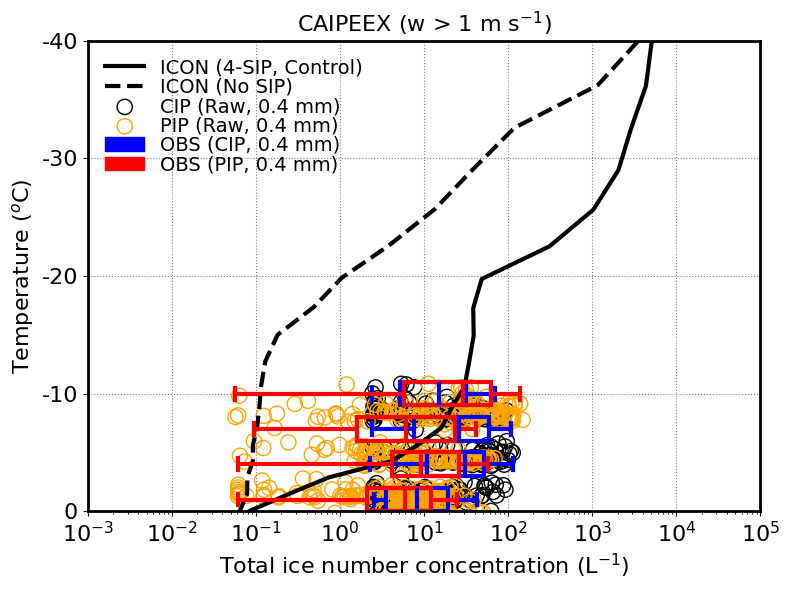

In [157]:





## ============== ICON
w_thres = 1.
thres_q = 1.e-3

###### With SIP
inc_4sip_up_perl = xr.where((ds_4sip_new.tqi > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.inc_perl, np.nan)
median_inc_4sip_up_perl = inc_4sip_up_perl.median(dim=('time','ncells'))
mean_inc_4sip_up_perl = inc_4sip_up_perl.mean(dim=('time','ncells'))
min_inc_4sip_up_perl = inc_4sip_up_perl.min(dim=('time','ncells'))
max_inc_4sip_up_perl = inc_4sip_up_perl.max(dim=('time','ncells'))
avg_4sip_tempc = ds_4sip_new.tempc.mean(dim=('time','ncells')) 

std_inc_4sip_up_perl = inc_4sip_up_perl.std(dim=('time', 'ncells'), skipna=True)
count_inc_4sip_up_perl = inc_4sip_up_perl.count(dim=('time', 'ncells'))
se_inc_4sip_up_perl = std_inc_4sip_up_perl / np.sqrt(count_inc_4sip_up_perl)


###### Without SIP
inc_nosip_up_perl = xr.where((ds_nosip_new.tqi > thres_q) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.inc_perl, np.nan)
median_inc_nosip_up_perl = inc_nosip_up_perl.median(dim=('time','ncells'))
mean_inc_nosip_up_perl = inc_nosip_up_perl.mean(dim=('time','ncells'))
min_inc_nosip_up_perl = inc_nosip_up_perl.min(dim=('time','ncells'))
max_inc_nosip_up_perl = inc_nosip_up_perl.max(dim=('time','ncells'))
avg_nosip_tempc = ds_nosip_new.tempc.mean(dim=('time','ncells')) 

std_inc_nosip_up_perl = inc_nosip_up_perl.std(dim=('time', 'ncells'), skipna=True)
count_inc_nosip_up_perl = inc_nosip_up_perl.count(dim=('time', 'ncells'))
se_inc_nosip_up_perl = std_inc_nosip_up_perl / np.sqrt(count_inc_nosip_up_perl)
## ================



##=============== CIP
df_v2_cip_comb = pd.DataFrame(ds_v2_cip_comb)
temp_cip_bin = np.arange(-20, 20, 3)
temp_cip_bin = np.sort(temp_cip_bin)

df_v2_cip_comb['temp_pip_bin'] = np.digitize(df_v2_cip_comb['tempc'], bins=temp_cip_bin, right=False)

bin_edges = np.concatenate([temp_cip_bin - 2, [temp_cip_bin[-1] + 2]])  
df_v2_cip_comb['temp_bin'] = bin_edges[df_v2_cip_comb['temp_pip_bin']]

# TINC
df_nice_up_cip = df_v2_cip_comb[['ni400um_cip_up_perl', 'temp_bin']].dropna()
df_nice_up_cip = df_nice_up_cip.dropna(subset=['temp_bin'])
inc_cip_up_by_bin = [df_nice_up_cip[df_nice_up_cip['temp_bin'] == temp]['ni400um_cip_up_perl'].values for temp in bin_edges]

##=============== PIP
df_v2_pip_comb = pd.DataFrame(ds_v2_pip_comb)
temp_pip_bin = np.arange(-20, 20, 3)
temp_pip_bin = np.sort(temp_pip_bin)

df_v2_pip_comb['temp_pip_bin'] = np.digitize(df_v2_pip_comb['tempc'], bins=temp_pip_bin, right=False)

bin_edges = np.concatenate([temp_pip_bin - 2, [temp_pip_bin[-1] + 2]])  
df_v2_pip_comb['temp_bin'] = bin_edges[df_v2_pip_comb['temp_pip_bin']]

# TINC
df_nice_up_pip = df_v2_pip_comb[['ni400um_pip_up_perl', 'temp_bin']].dropna()
df_nice_up_pip = df_nice_up_pip.dropna(subset=['temp_bin'])
inc_pip_up_by_bin = [df_nice_up_pip[df_nice_up_pip['temp_bin'] == temp]['ni400um_pip_up_perl'].values for temp in bin_edges]

#===================================
lower_err_inc = np.clip(mean_inc_4sip_up_perl - std_inc_4sip_up_perl, 1e-6, None)#np.maximum(mean_inc_4sip_up_perl - std_inc_4sip_up_perl, 1e-2)
upper_err_inc = mean_inc_4sip_up_perl + std_inc_4sip_up_perl
#===================================

fnt=16;
ln=3;
ln1=3;
al1=1.#0.4;
al2=1.#0.6;
al3=0.3
wd=2
fig, ax = plt.subplots(figsize=(8,6))

#ax.plot(min_inc_sip_up_perl, avg_tempc, 'k-.', linewidth=ln, label='ICON (Min)');
#ax.plot(median_inc_4sip_up_perl, avg_4sip_tempc, 'k--', linewidth=ln, label='ICON (Median)');
#ax.plot(mean_inc_4sip_up_perl, avg_4sip_tempc, 'k-', linewidth=ln, label='ICON (Control)');
#ax.plot(max_inc_4sip_up_perl, avg_4sip_tempc, 'k:', linewidth=ln, label='ICON (Max)');

#ax.plot(min_inc_4sip_up_perl, avg_4sip_tempc, 'k:', linewidth=ln, label='ICON (Min)');
#ax.plot(mean_inc_4sip_up_perl, avg_4sip_tempc, 'k-', linewidth=ln, label='ICON (Mean)');
#ax.plot(max_inc_4sip_up_perl, avg_4sip_tempc, 'k-.', linewidth=ln, label='ICON (Max)');


ax.plot(mean_inc_4sip_up_perl, avg_4sip_tempc, 'k-', linewidth=ln, label='ICON (4-SIP, Control)');
ax.plot(mean_inc_nosip_up_perl, avg_nosip_tempc, 'k--', linewidth=ln, label='ICON (No SIP)');

#ax.fill_betweenx(avg_4sip_tempc.values,
#                 (mean_inc_4sip_up_perl - 0.09*std_inc_4sip_up_perl).values,
#                 (mean_inc_4sip_up_perl + std_inc_4sip_up_perl).values,
#                 color='k', alpha=0.2, label='ICON $\pm$ 1 STD DEV')

#ax.plot(median_inc_nosip_up_perl, avg_nosip_tempc, 'k--', linewidth=ln, label='ICON (Median)');
#ax.plot(mean_inc_nosip_up_perl, avg_nosip_tempc, '--', color='k', linewidth=ln, label='ICON (No SIP)');
#ax.plot(max_inc_nosip_up_perl, avg_nosip_tempc, 'r:', linewidth=ln, label='ICON (Max)');


ax.scatter(df_v2_cip_comb['ni400um_cip_up_perl'], df_v2_cip_comb['air_temp'], marker='o', s=120, 
           facecolors='none', edgecolors='k', alpha=al1, label='CIP (Raw, 0.4 mm)')

ax.scatter(df_v2_pip_comb['ni400um_pip_up_perl'], df_v2_pip_comb['air_temp'], marker='o', s=120, 
           facecolors='none', edgecolors='orange', alpha=al1, label='PIP (Raw, 0.4 mm)')

#ax.scatter(df_v2_hvps_comb['lwc_nev_up_gperm3'], df_v2_hvps_comb['air_temp'], marker='o', s=120, 
#           facecolors='orange', edgecolors='orange', alpha=al3, label='Nev (Raw)')

#ax.scatter(df_v2_hvps_comb['lwc_king_up_gperm3'], df_v2_hvps_comb['air_temp'], marker='o', s=120, 
#           facecolors='red', edgecolors='red', alpha=al3, label='King (Raw)')

#ax.scatter(df_v2_hvps_comb['lwc_nev_up_gperm3'], df_v2_hvps_comb['air_temp'], marker='o', s=120, 
#           facecolors='orange', edgecolors='orange', alpha=al3, label='Nev (Raw)')

#ax.boxplot(cdnc_sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True, widths=wd,
#            boxprops=dict(facecolor='none', edgecolor='black', linewidth=ln1, alpha=al1),
#            medianprops=dict(color='black', linewidth=ln1),
#            whiskerprops=dict(linewidth=ln1, color='black', alpha=al1),
#            capprops=dict(linewidth=ln1, color='black', alpha=al1), showfliers=False);

ax.boxplot(inc_cip_up_by_bin[:], positions=bin_edges[:], vert=False, patch_artist=True, widths=wd,
           boxprops=dict(facecolor='none', edgecolor='blue', linewidth=ln, alpha=al2),
           medianprops=dict(color='blue', linewidth=ln),
           whiskerprops=dict(linewidth=ln, color='blue', alpha=al2),
           capprops=dict(linewidth=ln, color='blue', alpha=al2), showfliers=False)

ax.boxplot(inc_pip_up_by_bin[:], positions=bin_edges[:], vert=False, patch_artist=True, widths=wd,
           boxprops=dict(facecolor='none', edgecolor='red', linewidth=ln, alpha=al2),
           medianprops=dict(color='red', linewidth=ln),
           whiskerprops=dict(linewidth=ln, color='red', alpha=al2),
           capprops=dict(linewidth=ln, color='red', alpha=al2), showfliers=False)


#ax.boxplot(lwc_king_up_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True, widths=wd,
#           boxprops=dict(facecolor='none', edgecolor='red', linewidth=ln, alpha=al2),
#           medianprops=dict(color='red', linewidth=ln),
#           whiskerprops=dict(linewidth=ln, color='red', alpha=al2),
#           capprops=dict(linewidth=ln, color='red', alpha=al2), showfliers=False)


#ax.boxplot(lwc_nev_up_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True, widths=wd,
#           boxprops=dict(facecolor='none', edgecolor='magenta', linewidth=ln, alpha=al2),
#           medianprops=dict(color='magenta', linewidth=ln),
#           whiskerprops=dict(linewidth=ln, color='magenta', alpha=al2),
#           capprops=dict(linewidth=ln, color='magenta', alpha=al2), showfliers=False)

# Set the scale to log for the x-axis
ax.set_xscale('log')
ax.set_xlim(1.e-3, 1.e5)
ax.set_xticks([1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1, 1.e2, 1.e3, 1.e4, 1.e5])#, 1.e5])
#ax.set_xticklabels([1.e-4, 1.e-2, 1.e0, 1.e2, 1.e4, 1.e6], fontsize=fontsize)

ax.set_xlabel('Total ice number concentration (L$^{-1}$)', fontsize=fnt)
ax.tick_params(axis='x', labelsize=fnt)

# Set y-axis labels
ax.set_ylim(0, -40)
ax.set_ylabel('Temperature ($^{o}$C)', fontsize=fnt)
ax.set_yticks([0, -10, -20, -30, -40])
ax.set_yticklabels(['0', '-10', '-20', '-30', '-40'], fontsize=fnt)


ax.set_title('CAIPEEX (w > 1 m s$^{-1}$)', fontsize=fnt)

# Customize grid
ax.grid(True, linestyle=':', color='grey', alpha=al1)

# Add legends for boxplots and ICON line
handles, labels = ax.get_legend_handles_labels()

obs_icon_patch = mpatches.Patch(color='black', label='ICON')
obs_cip_patch = mpatches.Patch(color='blue', label='OBS (CIP, 0.4 mm)')
obs_pip_patch = mpatches.Patch(color='red', label='OBS (PIP, 0.4 mm)')

#ax.legend(handles=handles + [obs_icon_patch, obs_cip_patch, obs_hvps_patch], frameon=False, loc='best', fontsize=fnt)
ax.legend(handles=handles + [obs_cip_patch, obs_pip_patch], frameon=False, loc='best', labelspacing=0.02, fontsize=fnt-2)

# Customize axis spines
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['left'].set_linewidth(2)
#ax.spines['bottom'].set_linewidth(2)

for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(2)
    ax.spines[spine].set_color('black')
    
# Display the plot
plt.tight_layout()
plt.show()


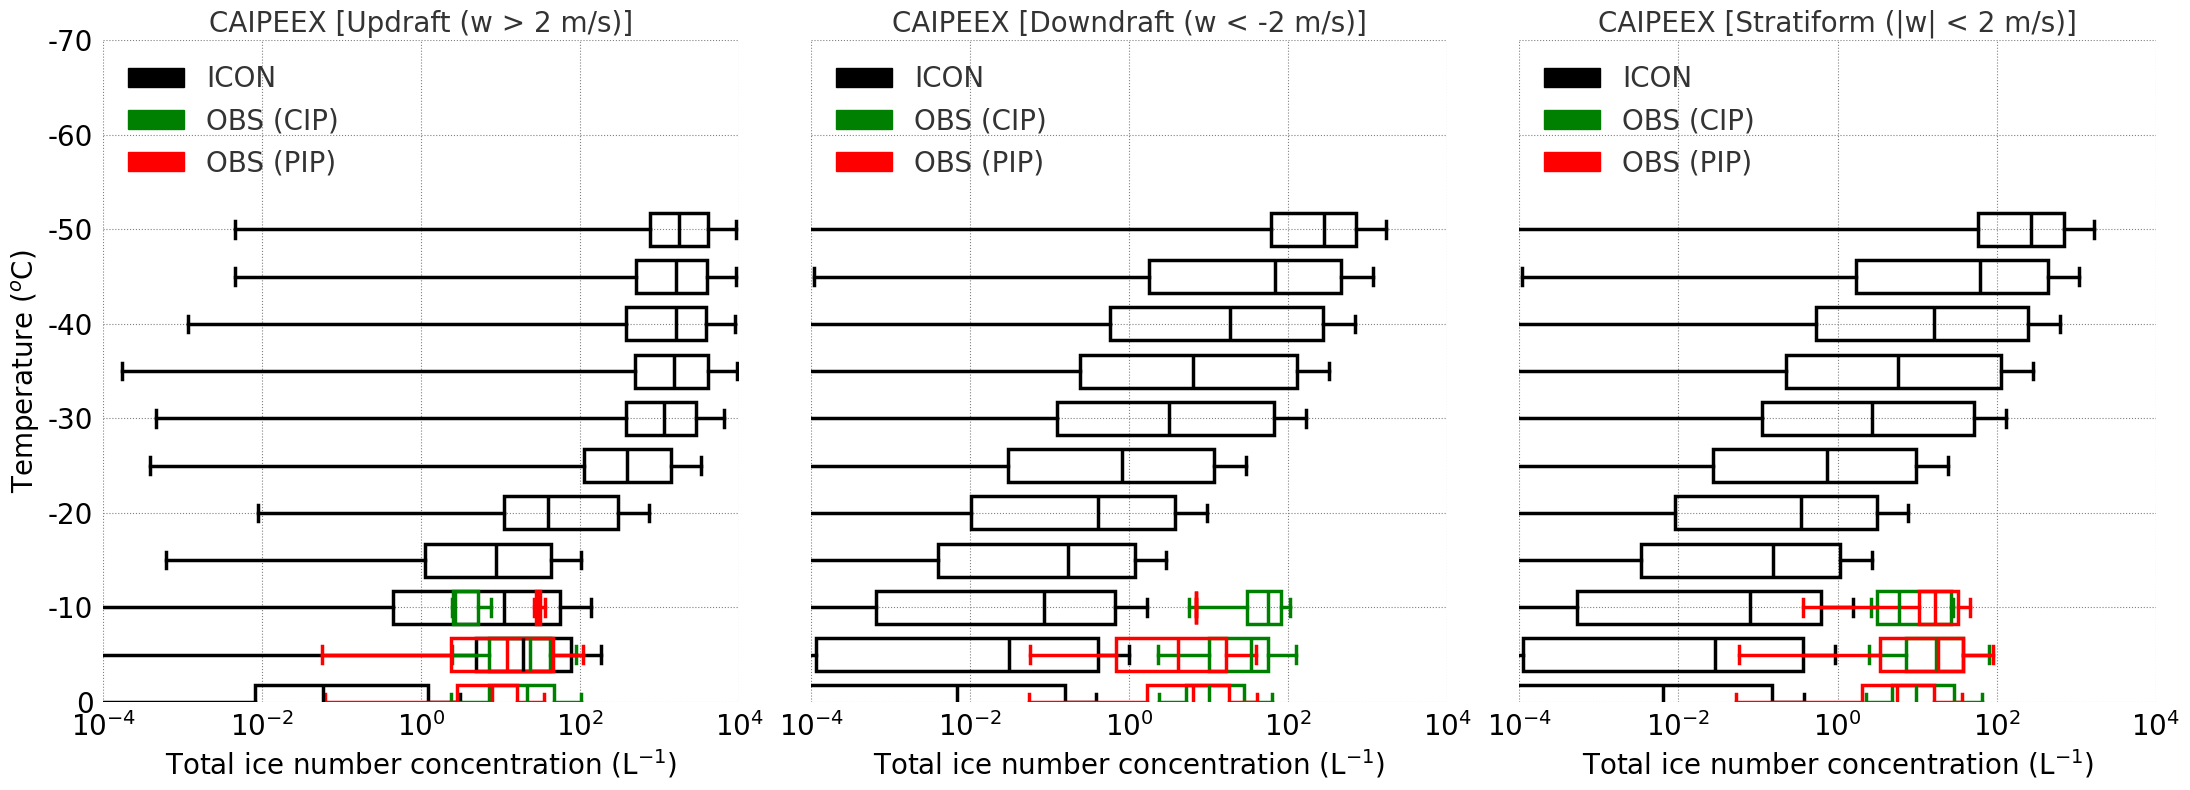

In [54]:

## ============== ICON
w_thres = 2.
thres_q = 1.e-3
###### Without SIP
# lwc gperm3
inc_sip_up_perl = xr.where((ds_4sip_new.inc_perl > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.inc_perl, np.nan)
avg_inc_sip_up_perl = inc_sip_up_perl.median(dim=('time','ncells'))
avg_tempc = ds_4sip_new.tempc.mean(dim=('time','ncells')) 

## Total ice number concentrations (CIP & PIP > 400µm)
##=============== CIP
df_v2_cip_comb = pd.DataFrame(ds_v2_cip_comb)

#temp_cip_bin = np.arange(-20, 0, 3)
temp_cip_bin = np.arange(-20, 20, 5)
temp_cip_bin = np.sort(temp_cip_bin)

df_v2_cip_comb['temp_cip_bin'] = np.digitize(df_v2_cip_comb['tempc'], bins=temp_cip_bin, right=False)

bin_edges = np.concatenate([temp_cip_bin - 2, [temp_cip_bin[-1] + 2]])  
df_v2_cip_comb['temp_bin'] = bin_edges[df_v2_cip_comb['temp_cip_bin']]

# TINC
df_nice_up_cip = df_v2_cip_comb[['ni400um_cip_up_perl', 'temp_bin']].dropna()
df_nice_dn_cip = df_v2_cip_comb[['ni400um_cip_dn_perl', 'temp_bin']].dropna()
df_nice_st_cip = df_v2_cip_comb[['ni400um_cip_st_perl', 'temp_bin']].dropna()

df_nice_up_cip = df_nice_up_cip.dropna(subset=['temp_bin'])
df_nice_dn_cip = df_nice_dn_cip.dropna(subset=['temp_bin'])
df_nice_st_cip = df_nice_st_cip.dropna(subset=['temp_bin'])

inc_cip_up_by_bin = [df_nice_up_cip[df_nice_up_cip['temp_bin'] == temp]['ni400um_cip_up_perl'].values for temp in bin_edges]
inc_cip_dn_by_bin = [df_nice_dn_cip[df_nice_dn_cip['temp_bin'] == temp]['ni400um_cip_dn_perl'].values for temp in bin_edges]
inc_cip_st_by_bin = [df_nice_st_cip[df_nice_st_cip['temp_bin'] == temp]['ni400um_cip_st_perl'].values for temp in bin_edges]


##=============== PIP
df_v2_pip_comb = pd.DataFrame(ds_v2_pip_comb)

#temp_pip_bin = np.arange(-20, 0, 3)
temp_pip_bin = np.arange(-20, 20, 5)
temp_pip_bin = np.sort(temp_pip_bin)

df_v2_pip_comb['temp_pip_bin'] = np.digitize(df_v2_cip_comb['tempc'], bins=temp_pip_bin, right=False)

bin_edges = np.concatenate([temp_pip_bin - 2, [temp_pip_bin[-1] + 2]])  
df_v2_pip_comb['temp_bin'] = bin_edges[df_v2_pip_comb['temp_pip_bin']]

# TINC
df_nice_up_pip = df_v2_pip_comb[['ni400um_pip_up_perl', 'temp_bin']].dropna()
df_nice_dn_pip = df_v2_pip_comb[['ni400um_pip_dn_perl', 'temp_bin']].dropna()
df_nice_st_pip = df_v2_pip_comb[['ni400um_pip_st_perl', 'temp_bin']].dropna()

df_nice_up_pip = df_nice_up_pip.dropna(subset=['temp_bin'])
df_nice_dn_pip = df_nice_dn_pip.dropna(subset=['temp_bin'])
df_nice_st_pip = df_nice_st_pip.dropna(subset=['temp_bin'])

inc_pip_up_by_bin = [df_nice_up_pip[df_nice_up_pip['temp_bin'] == temp]['ni400um_pip_up_perl'].values for temp in bin_edges]
inc_pip_dn_by_bin = [df_nice_dn_pip[df_nice_dn_pip['temp_bin'] == temp]['ni400um_pip_dn_perl'].values for temp in bin_edges]
inc_pip_st_by_bin = [df_nice_st_pip[df_nice_st_pip['temp_bin'] == temp]['ni400um_pip_st_perl'].values for temp in bin_edges]

fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['CAIPEEX [Updraft (w > 2 m/s)]', 'CAIPEEX [Downdraft (w < -2 m/s)]', 'CAIPEEX [Stratiform (|w| < 2 m/s)]']

fontsize = 20;
linewidth = 2.5;
width=3.5;
alpha1=1;
alpha2=1.;
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    if i == 0:
        #ax.plot(avg_inc_sip_up_perl, avg_tempc, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(inc_sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(inc_cip_up_by_bin[:-1], positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='green', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='green', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='green', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='green', alpha=alpha2),
                   showfliers=False)
        
        ax.boxplot(inc_pip_up_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
    elif i == 1:
        #ax.plot(cdnc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(inc_sip_dn_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(inc_cip_dn_by_bin[:-1], positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='green', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='green', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='green', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='green', alpha=alpha2),
                   showfliers=False)
        
        ax.boxplot(inc_pip_dn_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
    elif i == 2:
        #ax.plot(cdnc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(inc_sip_st_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(inc_cip_st_by_bin[:-1], positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='green', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='green', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='green', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='green', alpha=alpha2),
                   showfliers=False)
        
        ax.boxplot(inc_pip_st_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)

    ax.set_xscale('log')
    ax.set_xlim(1.e-4, 1.e4)
    ax.set_xticklabels([1.e-4, 1.e-2, 1.e0, 1.e2, 1.e4], fontsize=fontsize)
    ax.set_ylim(0, -70)
    #ax.set_yticklabels([20, 10, 0, -10, -20, -30, -40], fontsize=fontsize)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Total ice number concentration (L$^{-1 }$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=1.0)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch1 = mpatches.Patch(color='black', label='ICON')
    obs_patch2 = mpatches.Patch(color='green', label='OBS (CIP)')
    obs_patch3 = mpatches.Patch(color='red', label='OBS (PIP)')

    ax.legend(handles=handles + [obs_patch1, obs_patch2, obs_patch3], frameon=False, loc='upper left', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([0, -10, -20, -30, -40, -50, -60, -70])
axes[0].set_yticklabels(['0', '-10', '-20', '-30', '-40', '-50', '-60', '-70'], fontsize=fontsize)
#axes[0].set_yticks([0, -5, -10, -15, -20, -25, -30, -35, -40])
#axes[0].set_yticklabels(['0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()

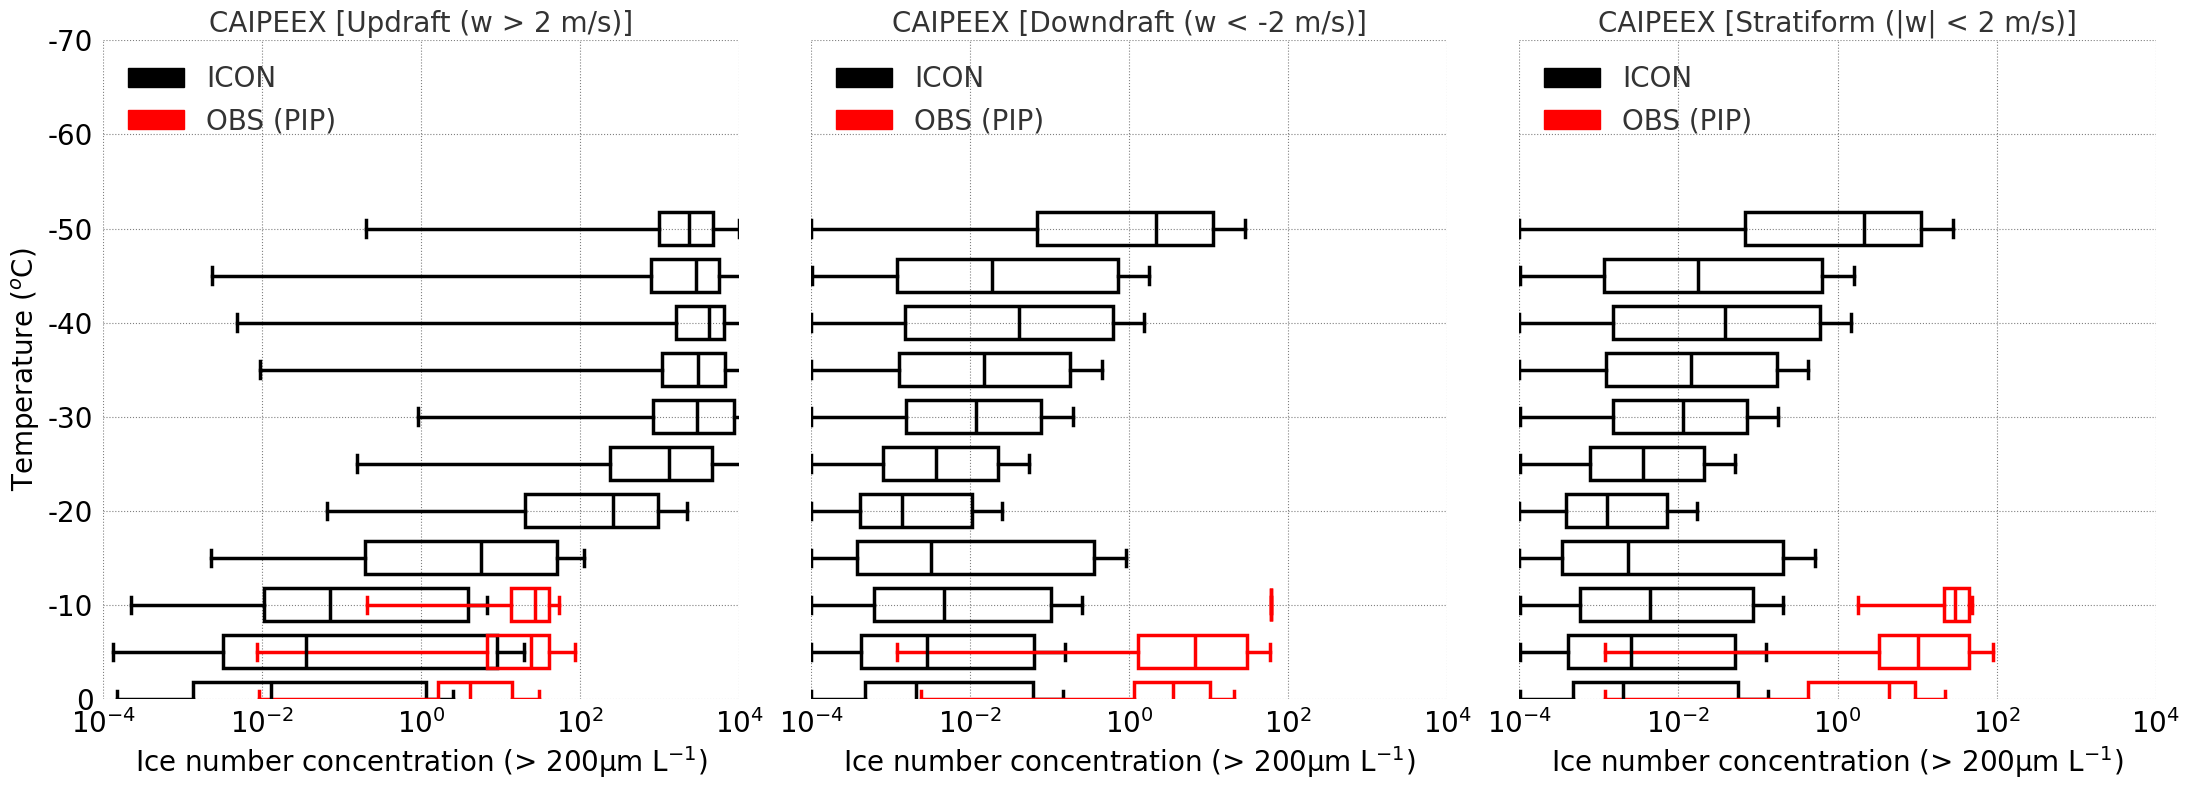

In [199]:

ds_pip_nc = xr.open_mfdataset('/work/bk1415/b382718/output/caipeex/observations/aircraft_Data_AR_SIP_case/PIP/09302019_000000_PIP.nc');

data_pip = pd.DataFrame()
data_pip['time'] = ds_pip_nc['utc_time']
data_pip['NT100'] = ds_pip_nc['NT100']
data_pip['NT200'] = ds_pip_nc['NT200']
data_pip['IWC100'] = ds_pip_nc['IWC100']
data_pip['IWC200'] = ds_pip_nc['IWC200']
data_pip['NT200_perl'] = 1.e-3*ds_pip_nc['NT200']

data_v2_pip_comb = pd.merge(ds_v2, data_pip, on='time', how='inner')

##=========== PIP TINC
data_v2_pip_comb['ni200um_pip_up_perl'] = np.where((data_v2_pip_comb.NT200_perl > 1.e-3) & (data_v2_pip_comb.vert_vel > 2.), 
                                        data_v2_pip_comb.NT200_perl, np.nan)
data_v2_pip_comb['ni200um_pip_dn_perl'] = np.where((data_v2_pip_comb.NT200_perl > 1.e-3) & (data_v2_pip_comb.vert_vel < -2.), 
                                        data_v2_pip_comb.NT200_perl, np.nan)
data_v2_pip_comb['ni200um_pip_st_perl'] = np.where((data_v2_pip_comb.NT200_perl > 1.e-3) & (np.abs(data_v2_pip_comb.vert_vel) < 2.), 
                                        data_v2_pip_comb.NT200_perl, np.nan)
##=========== PIP IWC
data_v2_pip_comb['iwc_pip_up_gperm3'] = np.where((data_v2_pip_comb.IWC200 > 1.e-3) & (data_v2_pip_comb.vert_vel > 2.), 
                                        data_v2_pip_comb.IWC200, np.nan)
data_v2_pip_comb['iwc_pip_dn_gperm3'] = np.where((data_v2_pip_comb.IWC200 > 1.e-3) & (data_v2_pip_comb.vert_vel < -2.), 
                                        data_v2_pip_comb.IWC200, np.nan)
data_v2_pip_comb['iwc_pip_st_gperm3'] = np.where((data_v2_pip_comb.IWC200 > 1.e-3) & (np.abs(data_v2_pip_comb.vert_vel) < 2.), 
                                        data_v2_pip_comb.IWC200, np.nan)

##=============== PIP
data_v2_pip_comb = pd.DataFrame(data_v2_pip_comb)

#temp_pip_bin = np.arange(-20, 0, 3)
temp_pip_bin = np.arange(-20, 20, 5)
temp_pip_bin = np.sort(temp_pip_bin)

data_v2_pip_comb['temp_pip_bin'] = np.digitize(data_v2_pip_comb['tempc'], bins=temp_pip_bin, right=False)

bin_edges = np.concatenate([temp_pip_bin - 2, [temp_pip_bin[-1] + 2]])  
data_v2_pip_comb['temp_bin'] = bin_edges[data_v2_pip_comb['temp_pip_bin']]

# PIP-TINC
df_ni200_up_pip = data_v2_pip_comb[['ni200um_pip_up_perl', 'temp_bin']].dropna()
df_ni200_dn_pip = data_v2_pip_comb[['ni200um_pip_dn_perl', 'temp_bin']].dropna()
df_ni200_st_pip = data_v2_pip_comb[['ni200um_pip_st_perl', 'temp_bin']].dropna()

df_ni200_up_pip = df_ni200_up_pip.dropna(subset=['temp_bin'])
df_ni200_dn_pip = df_ni200_dn_pip.dropna(subset=['temp_bin'])
df_ni200_st_pip = df_ni200_st_pip.dropna(subset=['temp_bin'])

inc200_pip_up_by_bin = [df_ni200_up_pip[df_ni200_up_pip['temp_bin'] == temp]['ni200um_pip_up_perl'].values for temp in bin_edges]
inc200_pip_dn_by_bin = [df_ni200_dn_pip[df_ni200_dn_pip['temp_bin'] == temp]['ni200um_pip_dn_perl'].values for temp in bin_edges]
inc200_pip_st_by_bin = [df_ni200_st_pip[df_ni200_st_pip['temp_bin'] == temp]['ni200um_pip_st_perl'].values for temp in bin_edges]

# PIP-IWC
df_iwc_up_pip = data_v2_pip_comb[['iwc_pip_up_gperm3', 'temp_bin']].dropna()
df_iwc_dn_pip = data_v2_pip_comb[['iwc_pip_dn_gperm3', 'temp_bin']].dropna()
df_iwc_st_pip = data_v2_pip_comb[['iwc_pip_st_gperm3', 'temp_bin']].dropna()

df_iwc_up_pip = df_iwc_up_pip.dropna(subset=['temp_bin'])
df_iwc_dn_pip = df_iwc_dn_pip.dropna(subset=['temp_bin'])
df_iwc_st_pip = df_iwc_st_pip.dropna(subset=['temp_bin'])

iwc_pip_up_by_bin = [df_iwc_up_pip[df_iwc_up_pip['temp_bin'] == temp]['iwc_pip_up_gperm3'].values for temp in bin_edges]
iwc_pip_dn_by_bin = [df_iwc_dn_pip[df_iwc_dn_pip['temp_bin'] == temp]['iwc_pip_dn_gperm3'].values for temp in bin_edges]
iwc_pip_st_by_bin = [df_iwc_st_pip[df_iwc_st_pip['temp_bin'] == temp]['iwc_pip_st_gperm3'].values for temp in bin_edges]

fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['CAIPEEX [Updraft (w > 2 m/s)]', 'CAIPEEX [Downdraft (w < -2 m/s)]', 'CAIPEEX [Stratiform (|w| < 2 m/s)]']

fontsize = 20;
linewidth = 2.5;
width=3.5;
alpha1=1;
alpha2=1.;
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    if i == 0:
        #ax.plot(inc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(inc_sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(inc200_pip_up_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
    elif i == 1:
        #ax.plot(cdnc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(inc_sip_dn_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(inc200_pip_dn_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
    elif i == 2:
        #ax.plot(cdnc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(inc_sip_st_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(inc200_pip_st_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)

    ax.set_xscale('log')
    ax.set_xlim(1.e-4, 1.e4)
    ax.set_xticklabels([1.e-4, 1.e-2, 1.e0, 1.e2, 1.e4], fontsize=fontsize)
    ax.set_ylim(0, -70)
    #ax.set_yticklabels([20, 10, 0, -10, -20, -30, -40], fontsize=fontsize)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Ice number concentration (> 200µm L$^{-1 }$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=1.0)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch1 = mpatches.Patch(color='black', label='ICON')
    obs_patch2 = mpatches.Patch(color='red', label='OBS (PIP)')

    ax.legend(handles=handles + [obs_patch1, obs_patch2], frameon=False, loc='upper left', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([0, -10, -20, -30, -40, -50, -60, -70])
axes[0].set_yticklabels(['0', '-10', '-20', '-30', '-40', '-50', '-60', '-70'], fontsize=fontsize)
#axes[0].set_yticks([0, -5, -10, -15, -20, -25, -30, -35, -40])
#axes[0].set_yticklabels(['0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()

In [80]:
data_v2_pip_comb

time  alt     lon     lat  air_speed  air_temp    pres  rel_hum  \
0     26290  402  17.622  75.939      11.00     31.73  957.24     69.7   
1     26295  402  17.623  75.939      18.10     31.25  957.58     70.4   
2     26300  404  17.624  75.938      28.45     30.84  957.40     72.6   
3     26305  406  17.625  75.936      38.21     30.68  957.78     74.2   
4     26310  406  17.627  75.935      47.13     30.46  957.76     75.5   
...     ...  ...     ...     ...        ...       ...     ...      ...   
2269  37665  412  17.628  75.935      19.22     32.14  954.16     65.5   
2270  37670  412  17.628  75.935      16.83     32.30  954.08     64.7   
2271  37675  412  17.628  75.935      13.60     32.27  954.08     64.3   
2272  37680  412  17.627  75.935      14.04     32.26  953.68     64.1   
2273  37685  412  17.627  75.935      15.93     32.31  953.86     64.4   

      wind_spped  wind_dir  ...  lwc_cdp_st_gperm3  temp_bin     NT100  \
0        -999.00     90.00  ...                NaN      25.0  0.000000   
1        -999.00     90.00  ...                NaN      25.0  0.000000   
2          10.39    156.22  ...                NaN      25.0  6.391427   
3          11.46    159.84  ...                NaN      25.0  4.807692   
4          11.52    159.90  ...                NaN      25.0  1.523148   
...          ...       ...  ...                ...       ...       ...   
2269        3.25    158.33  ...                NaN      25.0  0.000000   
2270     -999.00     90.00  ...                NaN      25.0  0.000000   
2271     -999.00     90.00  ...                NaN      25.0  0.000000   
2272     -999.00     90.00  ...                NaN      25.0  0.000000   
2273     -999.00     90.00  ...                NaN      25.0  0.000000   

         NT200    IWC100    IWC200  NT200_perl  iwc_pip_up_gperm3  \
0     0.000000  0.000000  0.000000    0.000000                NaN   
1     0.000000  0.000000  0.000000    0.000000                NaN   
2     6.391427  0.000065  0.000065    0.006391                NaN   
3     4.807692  0.000048  0.000048    0.004808                NaN   
4     1.523148  0.000006  0.000006    0.001523                NaN   
...        ...       ...       ...         ...                ...   
2269  0.000000  0.000000  0.000000    0.000000                NaN   
2270  0.000000  0.000000  0.000000    0.000000                NaN   
2271  0.000000  0.000000  0.000000    0.000000                NaN   
2272  0.000000  0.000000  0.000000    0.000000                NaN   
2273  0.000000  0.000000  0.000000    0.000000                NaN   

      iwc_pip_dn_gperm3  iwc_pip_st_gperm3  
0                   NaN                NaN  
1                   NaN                NaN  
2                   NaN                NaN  
3                   NaN                NaN  
4                   NaN                NaN  
...                 ...                ...  
2269                NaN                NaN  
2270                NaN                NaN  
2271                NaN                NaN  
2272                NaN                NaN  
2273                NaN                NaN  

[2274 rows x 57 columns]

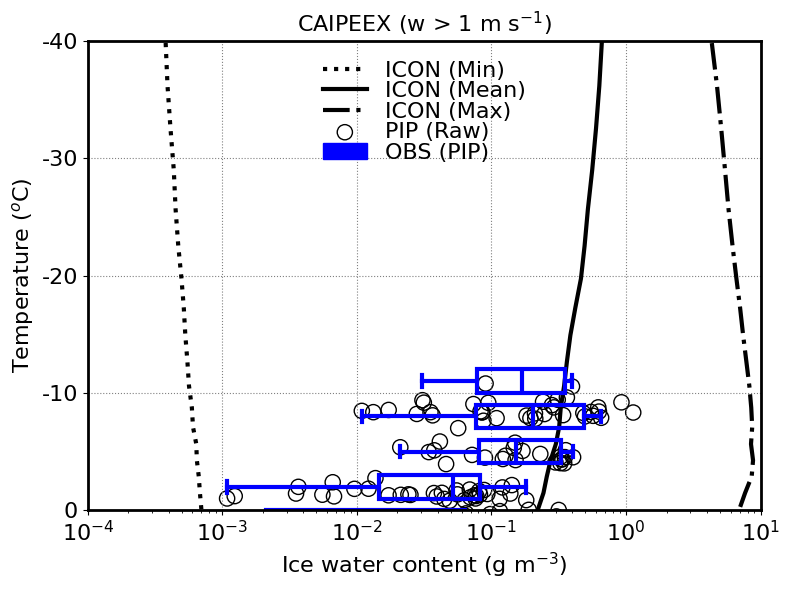

In [156]:

## ============== ICON
w_thres = 1.
thres_q = 1.e-6
###### Without SIP
# lwc gperm3
iwc_4sip_up_gperm3 = xr.where((ds_4sip_new.tqi > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
median_iwc_4sip_up_gperm3 = iwc_4sip_up_gperm3.median(dim=('time','ncells'))
mean_iwc_4sip_up_gperm3 = iwc_4sip_up_gperm3.mean(dim=('time','ncells'))
min_iwc_4sip_up_gperm3 = iwc_4sip_up_gperm3.min(dim=('time','ncells'))
max_iwc_4sip_up_gperm3 = iwc_4sip_up_gperm3.max(dim=('time','ncells'))
avg_4sip_tempc = ds_4sip_new.tempc.mean(dim=('time','ncells')) 

std_iwc_4sip_up_gperm3 = iwc_4sip_up_gperm3.std(dim=('time', 'ncells'), skipna=True)
count_iwc_4sip_up_gperm3 = iwc_4sip_up_gperm3.count(dim=('time', 'ncells'))
se_iwc_4sip_up_gperm3 = std_iwc_4sip_up_gperm3 / np.sqrt(count_iwc_4sip_up_gperm3)

## ================

##=============== PIP
ds_pip_nc = xr.open_mfdataset('/work/bk1415/b382718/output/caipeex/observations/aircraft_Data_AR_SIP_case/PIP/09302019_000000_PIP.nc');

data_pip = pd.DataFrame()
data_pip['time'] = ds_pip_nc['utc_time']
data_pip['NT100'] = ds_pip_nc['NT100']
data_pip['NT200'] = ds_pip_nc['NT200']
data_pip['IWC100'] = ds_pip_nc['IWC100']
data_pip['IWC200'] = ds_pip_nc['IWC200']
data_pip['NT200_perl'] = 1.e-3*ds_pip_nc['NT200']

data_v2_pip_comb = pd.merge(ds_v2, data_pip, on='time', how='inner')

##=========== PIP IWC
data_v2_pip_comb['iwc_pip_up_gperm3'] = np.where((data_v2_pip_comb.IWC200 > 1.e-3) & (data_v2_pip_comb.vert_vel > w_thres), 
                                        data_v2_pip_comb.IWC200, np.nan)
data_v2_pip_comb['iwc_pip_dn_gperm3'] = np.where((data_v2_pip_comb.IWC200 > 1.e-3) & (data_v2_pip_comb.vert_vel < -1*w_thres), 
                                        data_v2_pip_comb.IWC200, np.nan)
data_v2_pip_comb['iwc_pip_st_gperm3'] = np.where((data_v2_pip_comb.IWC200 > 1.e-3) & (np.abs(data_v2_pip_comb.vert_vel) < w_thres), 
                                        data_v2_pip_comb.IWC200, np.nan)

######################
df_v2_pip_comb = pd.DataFrame(data_v2_pip_comb)
df_v2_pip_comb['tempc'] = df_v2_pip_comb['air_temp']

temp_pip_bin = np.arange(-30, 20, 3)

temp_pip_bin = np.sort(temp_pip_bin)

df_v2_pip_comb['temp_pip_bin'] = np.digitize(df_v2_pip_comb['tempc'], bins=temp_pip_bin, right=False)

bin_edges = np.concatenate([temp_pip_bin - 2, [temp_pip_bin[-1] + 2]])  
df_v2_pip_comb['temp_bin'] = bin_edges[df_v2_pip_comb['temp_pip_bin']]
######################

# PIP-IWC
df_iwc_up_pip = df_v2_pip_comb[['iwc_pip_up_gperm3', 'temp_bin']].dropna()
df_iwc_up_pip = df_iwc_up_pip.dropna(subset=['temp_bin'])
iwc_pip_up_by_bin = [df_iwc_up_pip[df_iwc_up_pip['temp_bin'] == temp]['iwc_pip_up_gperm3'].values for temp in bin_edges]
################

fnt=16;
ln=3;
ln1=3;
al1=1.#0.4;
al2=1.#0.6;
al3=0.3
wd=2
fig, ax = plt.subplots(figsize=(8,6))

#ax.plot(min_inc_4sip_up_perl, avg_4sip_tempc, 'k-.', linewidth=ln, label='ICON (Min)');
#ax.plot(median_iwc_4sip_up_perl, avg_4sip_tempc, 'k--', linewidth=ln, label='ICON (Median)');
#ax.plot(mean_iwc_4sip_up_gperm3, avg_4sip_tempc, 'k-', linewidth=ln, label='ICON (Control)');
#ax.plot(max_iwc_4sip_up_perl, avg_4sip_tempc, 'k:', linewidth=ln, label='ICON (Max)');


ax.plot(min_iwc_4sip_up_gperm3, avg_4sip_tempc, 'k:', linewidth=ln, label='ICON (Min)');
ax.plot(mean_iwc_4sip_up_gperm3, avg_4sip_tempc, 'k-', linewidth=ln, label='ICON (Mean)');
ax.plot(max_iwc_4sip_up_gperm3, avg_4sip_tempc, 'k-.', linewidth=ln, label='ICON (Max)');

#ax.fill_betweenx(avg_4sip_tempc.values,
#                 (mean_iwc_4sip_up_gperm3 - 0.32*std_iwc_4sip_up_gperm3).values,
#                 (mean_iwc_4sip_up_gperm3 + std_iwc_4sip_up_gperm3).values,
#                 color='k', alpha=0.2, label='ICON $\pm$ 1 STD DEV')

ax.scatter(data_v2_pip_comb['iwc_pip_up_gperm3'], data_v2_pip_comb['air_temp'], marker='o', s=120, 
           facecolors='none', edgecolors='k', alpha=al1, label='PIP (Raw)')

ax.boxplot(iwc_pip_up_by_bin[:], positions=bin_edges[:], vert=False, patch_artist=True, widths=wd,
           boxprops=dict(facecolor='none', edgecolor='blue', linewidth=ln, alpha=al2),
           medianprops=dict(color='blue', linewidth=ln),
           whiskerprops=dict(linewidth=ln, color='blue', alpha=al2),
           capprops=dict(linewidth=ln, color='blue', alpha=al2), showfliers=False)

# Set the scale to log for the x-axis
ax.set_xscale('log')
ax.set_xlim(1.e-4, 1.e1)
ax.set_xticks([1.e-4, 1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1])
#ax.set_xticklabels([1.e-4, 1.e-2, 1.e0, 1.e2, 1.e4, 1.e6], fontsize=fontsize)

ax.set_xlabel('Ice water content (g m$^{-3}$)', fontsize=fnt)
ax.tick_params(axis='x', labelsize=fnt)

# Set y-axis labels
ax.set_ylim(0, -40)
ax.set_ylabel('Temperature ($^{o}$C)', fontsize=fnt)
ax.set_yticks([0, -10, -20, -30, -40])
ax.set_yticklabels(['0', '-10', '-20', '-30', '-40'], fontsize=fnt)


ax.set_title('CAIPEEX (w > 1 m s$^{-1}$)', fontsize=fnt)

# Customize grid
ax.grid(True, linestyle=':', color='grey', alpha=al1)

# Add legends for boxplots and ICON line
handles, labels = ax.get_legend_handles_labels()

obs_icon_patch = mpatches.Patch(color='black', label='ICON')
obs_pip_patch = mpatches.Patch(color='blue', label='OBS (PIP)')

#ax.legend(handles=handles + [obs_icon_patch, obs_cip_patch, obs_hvps_patch], frameon=False, loc='best', fontsize=fnt)
ax.legend(handles=handles + [obs_pip_patch], frameon=False, loc='best', labelspacing=0.02, fontsize=fnt)

# Customize axis spines
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['left'].set_linewidth(2)
#ax.spines['bottom'].set_linewidth(2)

for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(2)
    ax.spines[spine].set_color('black')


plt.tight_layout()
plt.show()


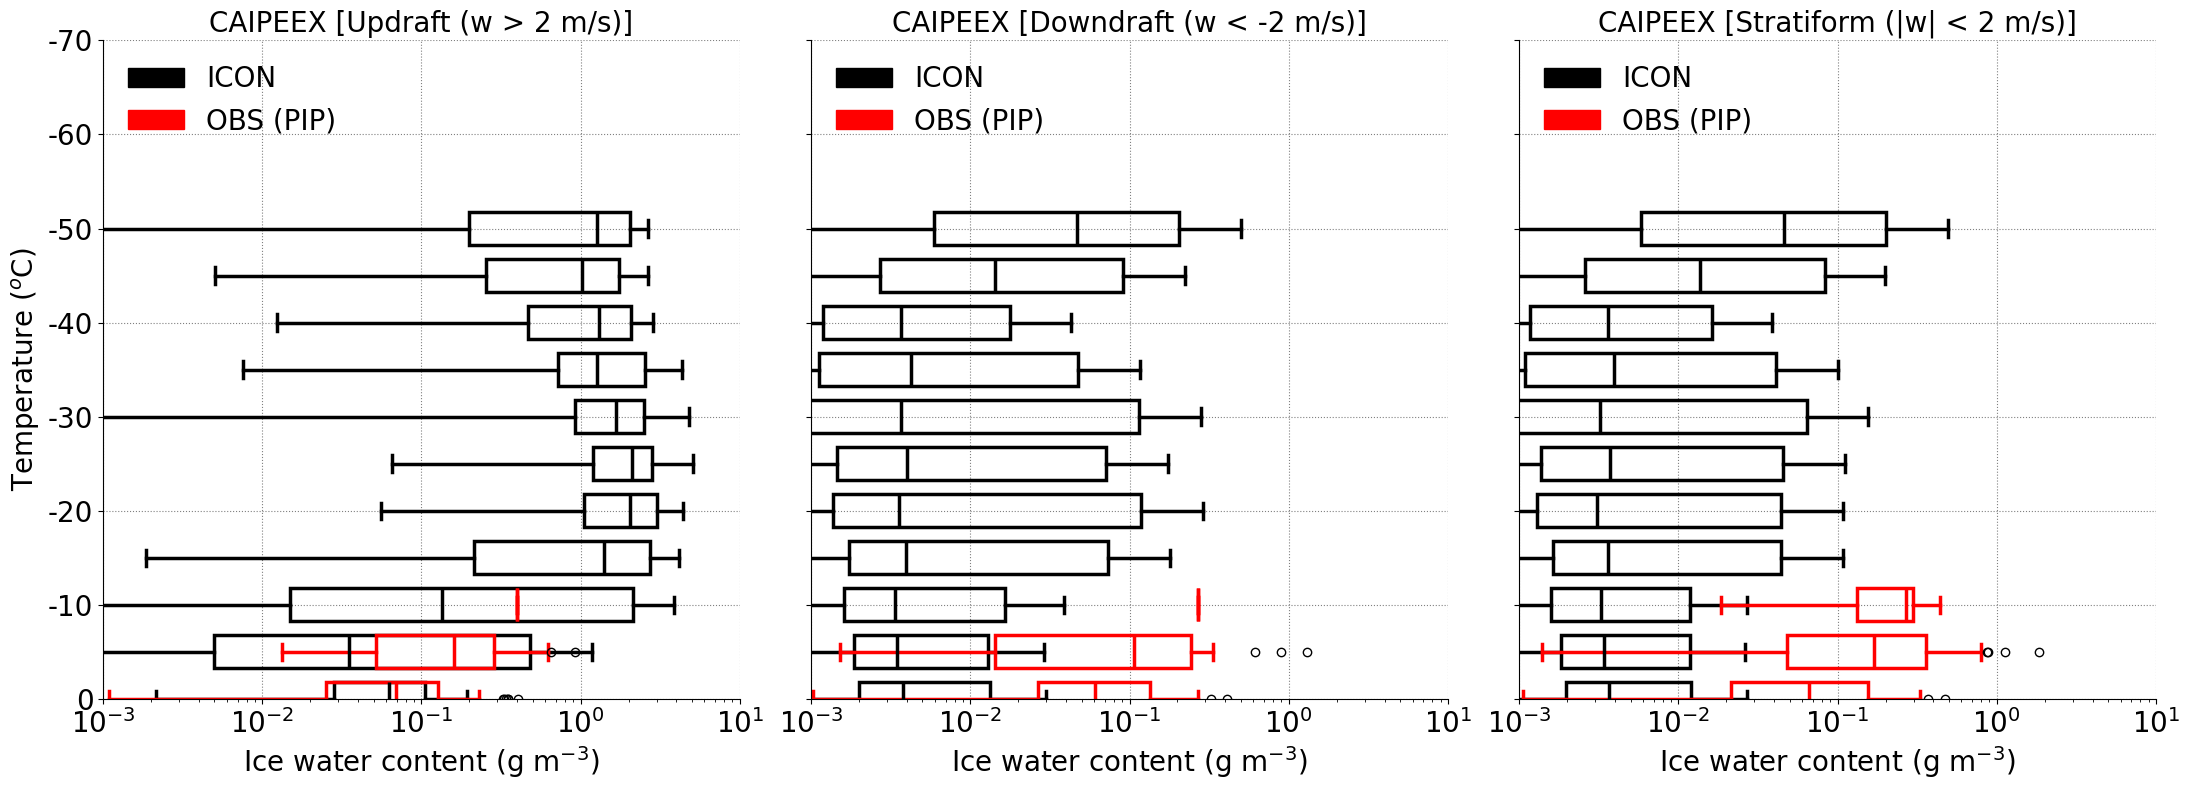

In [22]:

fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['CAIPEEX [Updraft (w > 2 m/s)]', 'CAIPEEX [Downdraft (w < -2 m/s)]', 'CAIPEEX [Stratiform (|w| < 2 m/s)]']

fontsize = 20;
linewidth = 2.5;
width=3.5;
alpha=1;
alpha1=1;
alpha2=1.;
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    if i == 0:
        #ax.plot(tiwc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(iwc_sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha),
                   showfliers=False)
        
        ax.boxplot(iwc_pip_up_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha1),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha1),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha1))
        
    elif i == 1:
        #ax.plot(tiwc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(iwc_sip_dn_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha),
                   showfliers=False)
        
        ax.boxplot(iwc_pip_dn_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha1),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha1),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha1))
    
    elif i == 2:
        #ax.plot(tiwc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(iwc_sip_st_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha),
                   showfliers=False)
        
        ax.boxplot(iwc_pip_st_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha1),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha1),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha1))

    ax.set_xscale('log')
    ax.set_xlim(1.e-3, 1.e1)
    ax.set_xticklabels([1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)
    ax.set_ylim(0, -70)
    #ax.set_yticklabels([20, 10, 0, -10, -20, -30, -40], fontsize=fontsize)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Ice water content (g m$^{-3 }$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=1.0)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch1 = mpatches.Patch(color='black', label='ICON')
    obs_patch2 = mpatches.Patch(color='red', label='OBS (PIP)')

    ax.legend(handles=handles + [obs_patch1, obs_patch2], frameon=False, loc='upper left', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([0, -10, -20, -30, -40, -50, -60, -70])
axes[0].set_yticklabels(['0', '-10', '-20', '-30', '-40', '-50', '-60', '-70'], fontsize=fontsize)
#axes[0].set_yticks([0, -5, -10, -15, -20, -25, -30, -35, -40])
#axes[0].set_yticklabels(['0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()

In [3]:

def calc_dewpoint(tempc, rh):
    dewpoint = tempc - ((100. - rh)/5.)
    return dewpoint

def calc_vir_temp(tc, q):
    #virt_tempk_wk = t/(1. - (ev/p)*(1-0.622))
    temp = tc + (1-0.622*q)
    return temp
    
def calculate_lcl(pressure, temperature, dewpoint):
    l = np.argmin(np.abs(temperature - dewpoint))
    return pressure[l], temperature[l]
    
def e_sat_hpa(tc):
    e_sat_pa = 6.112*np.exp((17.67*tc)/(tc+243.5))
    return e_sat_pa

def calc_parcel_temp(pres, ht, q_sat, tk_lcl):
    grav = 9.8  # acceleration due to gravity [m/s^2]
    eps = 0.622  # ratio of the gas constants for water vapor and dry air
    Rd = 287.  # specific gas constant for dry air [J/(kg*K)]
    cp = 1005.  # specific heat capacity at constant pressure for dry air [J/(kg*K)]
    lv = 2.5e6  # latent heat of vaporization [J/kg]
    Rv = 461.  # specific gas constant for water vapor [J/(kg*K)]

    tk_parcel = np.zeros(len(ht))  
    del_t_par = np.zeros(len(ht))  

    tk_parcel[0] = tk_lcl + 273.15 
    
    for i in range(1, len(ht)):
        dht = ht[i] - ht[i - 1]  
        qs = q_sat[i]  
        term_a = 1. + lv * qs / (Rd * tk_parcel[i - 1])
        term_b = (lv ** 2.) * eps * qs
        term_c = Rd * (tk_parcel[i - 1]) ** 2.
        
        del_t_par[i] = grav * term_a / (cp + (term_b / term_c))

        tk_parcel[i] = tk_parcel[i - 1] - del_t_par[i] * dht
        
    tempc = tk_parcel - 273.15
    return tempc

import numpy as np



def calc_cape(pres, t_env, t_par, tv_env, tv_par):
    """
    Calculate Convective Available Potential Energy (CAPE).
    
    Parameters:
        pres (array): Pressure levels (hPa or Pa).
        t_env (array): Environmental temperature (°C).
        t_par (array): Parcel temperature (°C).
        tv_env (array): Environmental virtual temperature (°C).
        tv_par (array): Parcel virtual temperature (°C).
    
    Returns:
        cape (float): CAPE value (J/kg).
    """
    Rd = 287.0  # gas constant for dry air (J/kg/K)
    
    # Convert temperatures to Kelvin
    tk_env = t_env + 273.15
    tk_v_env = tv_env + 273.15
    tk_par = t_par + 273.15
    tk_v_par = tv_par + 273.15
    
    cape = 0.0
    
    # Loop through pressure levels
    for i in range(1, len(pres)):
        # Check if parcel is warmer than the environment
        if tk_v_par[i] > tk_v_env[i]:
            # Calculate logarithmic pressure difference
            dlnp = np.log(pres[i-1] / pres[i])
            cape = cape + Rd * (tk_v_par[i] - tk_v_env[i]) * dlnp
    return cape
        

In [10]:
ds_4sip.time[9]

<xarray.DataArray 'time' ()>
array('2019-09-30T04:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2019-09-30T04:30:00
Attributes:
    standard_name:  time
    axis:           T

CAPE ::  508.00205125577486


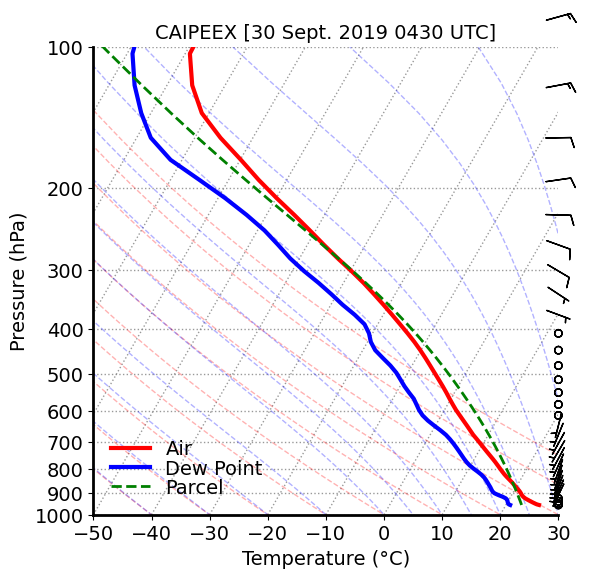

In [101]:

ds_skewt = ds_4sip.sel(time=ds_4sip.time[9])

tempc = ds_skewt.temp-273.15 #.values
pres_pa = ds_skewt.pres #.values
ht_m = ds_skewt.z_mc
rel_hum = ds_skewt.rh #.values
u_wind = ds_skewt.u
v_wind = ds_skewt.v
q_vap = ds_skewt.qv

   
temp_dew = calc_dewpoint(tempc, rel_hum)

avg_tempc = tempc.mean(dim=('ncells')).values
avg_dewtempc = temp_dew.mean(dim=('ncells')).values
avg_pres = 0.01*pres_pa.mean(dim=('ncells')).values
avg_ht = ht_m.mean(dim=('ncells')).values
avg_rh = rel_hum.mean(dim=('ncells')).values
avg_qv = q_vap.mean(dim=('ncells')).values

avg_u = u_wind.mean(dim=('ncells')).values
avg_v = v_wind.mean(dim=('ncells')).values

avg_tempc = avg_tempc[::-1]
avg_dewtempc = avg_dewtempc[::-1]
avg_pres = avg_pres[::-1]
avg_ht = avg_ht[::-1]
avg_rh = avg_rh[::-1]
avg_u = avg_u[::-1]
avg_v = avg_v[::-1]
avg_qv = avg_qv[::-1]

#----- Calculate parcel properties
e_sat = e_sat_hpa(avg_tempc)
q_sat = 0.622*e_sat/(avg_pres-e_sat)

lcl_pressure, lcl_temp = calculate_lcl(avg_pres, avg_tempc, avg_dewtempc)
parcel_temp = calc_parcel_temp(avg_pres, avg_ht, q_sat, lcl_temp)
Tv_env = calc_vir_temp(avg_tempc, avg_qv)
Tv_parcel = calc_vir_temp(parcel_temp, q_sat)
parcel_cape = calc_cape(avg_pres, avg_tempc, parcel_temp, Tv_env, Tv_parcel)
print('CAPE :: ', parcel_cape)
#------

# Create the Skew-T plot
fontsize=14;
lnwdth=3;
alpha=0.3;

fig = plt.figure(figsize=(6, 8))
skew = SkewT(fig)

# Plot temperature and dew point on the Skew-T
skew.plot(avg_pres, avg_tempc, 'r-', label='Air', linewidth=lnwdth)
skew.plot(avg_pres, avg_dewtempc, 'b-', label='Dew Point', linewidth=lnwdth)
skew.plot(avg_pres, parcel_temp, 'g--', label='Parcel', linewidth=lnwdth-1)
# Add wind barbs 
if 'u' in ds_skewt and 'v' in ds_skewt:
    u_wind = avg_u  # Zonal wind component
    v_wind = avg_v  # Meridional wind component
    skew.plot_barbs(avg_pres[::2], u_wind[::2], v_wind[::2], length=6, color='black', pivot='middle')

# Add the dry and moist adiabats to the plot
skew.plot_dry_adiabats(linewidth=1, alpha=alpha)
skew.plot_moist_adiabats(linewidth=1, alpha=alpha)

ax = skew.ax
ax.set_xlabel('Temperature (°C)', fontsize=fontsize)
ax.set_ylabel('Pressure (hPa)', fontsize=fontsize)
ax.set_xlim(-50, 30)
ax.set_ylim(1000., 100)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
plt.title('CAIPEEX [30 Sept. 2019 0430 UTC]', fontsize=fontsize)

plt.legend(frameon=False, handlelength=2, labelspacing=0.01, fontsize=fontsize, loc='lower left')
plt.grid(True, linestyle=':', linewidth=1., color='grey', alpha=0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()

In [4]:
# Flight data
file_path = '/work/bk1415/b382718/output/caipeex/observations/aircraft_Data_AR_SIP_case/aa_CIPcorrectedprocessed1HzdataCAIPEX20190930.txt'
data_v2 = pd.read_csv(file_path, sep='\s+', header=None, skiprows=1)

data_v2.columns = ['time', 'alt', 'lon', 'lat', 'air_speed', 
                   'air_temp', 'pres', 'rel_hum', 'wind_speed', 'wind_dir',
                   'vert_vel', 'num_conc_ccp_cdp', 'lwc_conc_ccp_cdp', 'mean_vol_diam_ccp_cdp', 'ccn200ass',
                   'ccn200anumconc', 'ccn200bss', 'ccn200bnumconc', 'num_conc_cdp', 'lwc_conc_cdp',
                   'mean_vol_diam_cdp', 'num_conc_cip', 'lwc_conc_cip', 'mean_vol_diam_cip', 'num_conc_pcasp',
                   'mass_conc_pcasp', 'mean_vol_diam_pcasp', 'num_conc_pip', 'lwc_conc_pip', 'mean_vol_diam_pip', 
                   'num_conc_sp2', 'mass_conc_sp2', 'mean_vol_diam_sp2', 'num_conc_sp2rbc', 'mass_conc_sp2rbc',  
                   'mean_vol_diam_sp2rbc', 'num_conc_uhsas', 'mass_conc_uhsas', 'mean_vol_diam_uhsas', 'lwc_300']

#df_v2 = pd.DataFrame(data_v2)
#df_v2['num_conc_cip'] = pd.to_numeric(df_v2['num_conc_cip'], errors='coerce')
data_v2['tempc'] = data_v2['air_temp']
ds_v2 = data_v2

ds_v2.pres[ds_v2.pres < 0.] = np.nan

<xarray.DataArray 'time' ()> Size: 8B
array('2019-09-30T09:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2019-09-30T09:00:00
Attributes:
    standard_name:  time
    axis:           T
LCL  ::  20.15791
CAPE ::  1498.3995921237888 joule / kilogram
CIN ::  -7.219343016755635 joule / kilogram


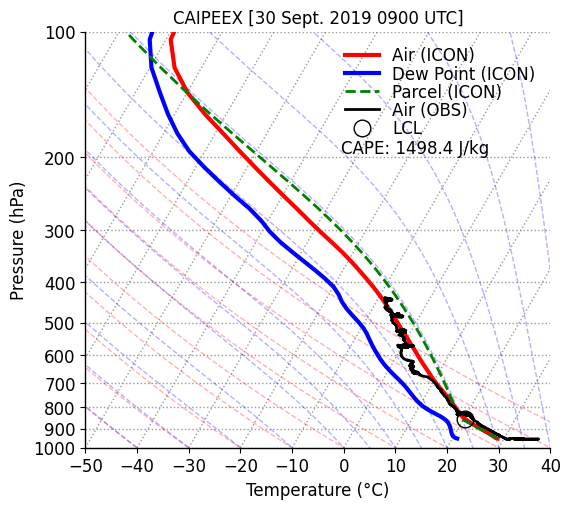

In [8]:
from metpy.calc import dewpoint_from_relative_humidity
from metpy.units import units
from metpy.calc import parcel_profile
from metpy.calc import cape_cin

ds_skewt = ds_4sip.sel(time=ds_4sip.time[18])

print(ds_4sip.time[18])

tempc = ds_skewt.temp-273.15 #.values
pres_pa = ds_skewt.pres #.values
ht_m = ds_skewt.z_mc
rel_hum = ds_skewt.rh #.values
u_wind = ds_skewt.u
v_wind = ds_skewt.v
q_vap = ds_skewt.qv

   
temp_dew = calc_dewpoint(tempc, rel_hum)

avg_tempc = tempc.mean(dim=('ncells')).values
avg_dewtempc = temp_dew.mean(dim=('ncells')).values
avg_pres = 0.01*pres_pa.mean(dim=('ncells')).values
avg_ht = ht_m.mean(dim=('ncells')).values
avg_rh = rel_hum.mean(dim=('ncells')).values
avg_qv = q_vap.mean(dim=('ncells')).values

avg_u = u_wind.mean(dim=('ncells')).values
avg_v = v_wind.mean(dim=('ncells')).values

avg_tempc = avg_tempc[::-1]
avg_dewtempc = avg_dewtempc[::-1]
avg_pres = avg_pres[::-1]
avg_ht = avg_ht[::-1]
avg_rh = avg_rh[::-1]
avg_u = avg_u[::-1]
avg_v = avg_v[::-1]
avg_qv = avg_qv[::-1]

e_sat = e_sat_hpa(avg_tempc)
q_sat = 0.622*e_sat/(avg_pres-e_sat)

lcl_pressure, lcl_temp = calculate_lcl(avg_pres, avg_tempc, avg_dewtempc)
#lcl_temp = calc_lcl(avg_tempc[0], avg_dewtempc)
print('LCL  :: ', lcl_temp)

### Parcel properties from ICON
temperature_K = (avg_tempc + 273.15) * units.K
relative_humidity = avg_rh / 100.0  # Convert to fraction

dewpoint = dewpoint_from_relative_humidity(temperature_K, relative_humidity)
avg_dewtempc = dewpoint.magnitude #- 273.15

pressure = avg_pres * units.hPa
temperature = avg_tempc * units.degC
dewpoint = avg_dewtempc * units.degC

parcel_tempk = parcel_profile(pressure, temperature[0], dewpoint[0])  # First level
parcel_tempc = parcel_tempk.magnitude-273.15

parcel_tempc = parcel_tempc * units.degC
cape, cin = cape_cin(pressure, temperature, dewpoint, parcel_tempc)

print('CAPE :: ', cape)
print('CIN :: ', cin)
### End parcel properties


# Create the Skew-T plot
fontsize=12;
lnwdth=3;
alpha=0.3;

fig = plt.figure(figsize=(6, 8))

plt.style.use('default')
skew = SkewT(fig)

# Plot temperature and dew point on the Skew-T
skew.plot(avg_pres, avg_tempc, 'r-', label='Air (ICON)', linewidth=lnwdth)
skew.plot(avg_pres, avg_dewtempc, 'b-', label='Dew Point (ICON)', linewidth=lnwdth)
skew.plot(avg_pres, parcel_tempc, 'g--', label='Parcel (ICON)', linewidth=lnwdth-1)
skew.plot(ds_v2.pres[8000:], ds_v2.tempc[8000:], 'k-', label='Air (OBS)', linewidth=lnwdth-1)

skew.plot(lcl_pressure, lcl_temp, 'ko', markerfacecolor='none', markersize=12, label='LCL')

# Add wind barbs 
#if 'u' in ds_skewt and 'v' in ds_skewt:
#    u_wind = avg_u  # Zonal wind component
#    v_wind = avg_v  # Meridional wind component
#    skew.plot_barbs(avg_pres[::2], u_wind[::2], v_wind[::2], length=6, color='black', pivot='middle')

# Add the dry and moist adiabats to the plot
skew.plot_dry_adiabats(linewidth=1, alpha=alpha)
skew.plot_moist_adiabats(linewidth=1, alpha=alpha)

ax = skew.ax
ax.set_xlabel('Temperature (°C)', fontsize=fontsize)
ax.set_ylabel('Pressure (hPa)', fontsize=fontsize)
ax.set_xlim(-50, 40)
ax.set_ylim(1000., 100)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
plt.title('CAIPEEX [30 Sept. 2019 0900 UTC]', fontsize=fontsize)

#ax.text(0.02, 0.95, f'CAPE: {cape.m:.1f} J/kg\nCIN: {cin.m:.1f} J/kg', transform=ax.transAxes, fontsize=fontsize, verticalalignment='top')
ax.text(0.55, 0.74, f'CAPE: {cape.m:.1f} J/kg', transform=ax.transAxes, fontsize=fontsize, verticalalignment='top')

plt.legend(frameon=False, handlelength=2, labelspacing=0.01, fontsize=fontsize, loc='upper right')
plt.grid(True, linestyle=':', linewidth=1., color='grey', alpha=0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1)
plt.gca().spines['bottom'].set_linewidth(1)
plt.show()

In [113]:


ds_skewt = ds_4sip.sel(time=ds_4sip.time[16])

print(ds_4sip.time[16])

tempc = ds_skewt.temp-273.15 #.values
pres_pa = ds_skewt.pres #.values
ht_m = ds_skewt.z_mc
rel_hum = ds_skewt.rh #.values
u_wind = ds_skewt.u
v_wind = ds_skewt.v
q_vap = ds_skewt.qv

   
temp_dew = calc_dewpoint(tempc, rel_hum)

avg_tempc = tempc.mean(dim=('ncells')).values
avg_dewtempc = temp_dew.mean(dim=('ncells')).values
avg_pres = 0.01*pres_pa.mean(dim=('ncells')).values
avg_ht = ht_m.mean(dim=('ncells')).values
avg_rh = rel_hum.mean(dim=('ncells')).values
avg_qv = q_vap.mean(dim=('ncells')).values

avg_u = u_wind.mean(dim=('ncells')).values
avg_v = v_wind.mean(dim=('ncells')).values

avg_tempc = avg_tempc[::-1]
avg_dewtempc = avg_dewtempc[::-1]
avg_pres = avg_pres[::-1]
avg_ht = avg_ht[::-1]
avg_rh = avg_rh[::-1]
avg_u = avg_u[::-1]
avg_v = avg_v[::-1]
avg_qv = avg_qv[::-1]

#----- Calculate parcel properties
e_sat = e_sat_hpa(avg_tempc)
q_sat = 0.622*e_sat/(avg_pres-e_sat)

lcl_pressure, lcl_temp = calculate_lcl(avg_pres, avg_tempc, avg_dewtempc)
parcel_temp = calc_parcel_temp(avg_pres, avg_ht, q_sat, lcl_temp)
Tv_env = calc_vir_temp(avg_tempc, avg_qv)
Tv_parcel = calc_vir_temp(parcel_temp, q_sat)
parcel_cape = calc_cape(avg_pres, avg_tempc, parcel_temp, Tv_env, Tv_parcel)
print('CAPE :: ', parcel_cape)
#------

<xarray.DataArray 'time' ()>
array('2019-09-30T08:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2019-09-30T08:00:00
Attributes:
    standard_name:  time
    axis:           T
CAPE ::  0.0


/tmp/ipykernel_274504/3554861184.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_v2.pres[ds_v2.pres < 0.] = np.nan


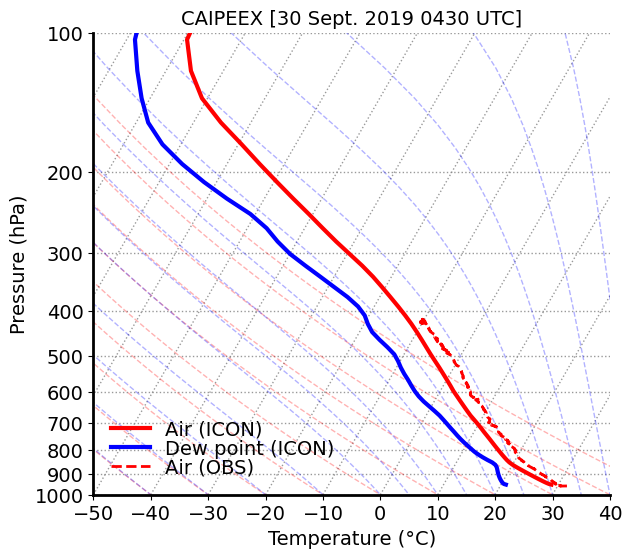

In [114]:
# Flight data
file_path = '/work/bk1415/b382718/output/caipeex/observations/aircraft_Data_AR_SIP_case/aa_CIPcorrectedprocessed1HzdataCAIPEX20190930.txt'
data_v2 = pd.read_csv(file_path, sep='\s+', header=None, skiprows=1)

data_v2.columns = ['time', 'alt', 'lon', 'lat', 'air_speed', 
                   'air_temp', 'pres', 'rel_hum', 'wind_speed', 'wind_dir',
                   'vert_vel', 'num_conc_ccp_cdp', 'lwc_conc_ccp_cdp', 'mean_vol_diam_ccp_cdp', 'ccn200ass',
                   'ccn200anumconc', 'ccn200bss', 'ccn200bnumconc', 'num_conc_cdp', 'lwc_conc_cdp',
                   'mean_vol_diam_cdp', 'num_conc_cip', 'lwc_conc_cip', 'mean_vol_diam_cip', 'num_conc_pcasp',
                   'mass_conc_pcasp', 'mean_vol_diam_pcasp', 'num_conc_pip', 'lwc_conc_pip', 'mean_vol_diam_pip', 
                   'num_conc_sp2', 'mass_conc_sp2', 'mean_vol_diam_sp2', 'num_conc_sp2rbc', 'mass_conc_sp2rbc',  
                   'mean_vol_diam_sp2rbc', 'num_conc_uhsas', 'mass_conc_uhsas', 'mean_vol_diam_uhsas', 'lwc_300']

#df_v2 = pd.DataFrame(data_v2)
#df_v2['num_conc_cip'] = pd.to_numeric(df_v2['num_conc_cip'], errors='coerce')
data_v2['tempc'] = data_v2['air_temp']
ds_v2 = data_v2

ds_v2.pres[ds_v2.pres < 0.] = np.nan



# Create the Skew-T plot
fontsize=14;
lnwdth=3;
alpha=0.3;

fig = plt.figure(figsize=(8, 6))
skew = SkewT(fig)

# Plot temperature and dew point on the Skew-T
skew.plot(avg_pres, avg_tempc, 'r-', label='Air (ICON)', linewidth=lnwdth)
skew.plot(avg_pres, avg_dewtempc, 'b-', label='Dew point (ICON)', linewidth=lnwdth)

skew.plot(ds_v2.pres[1:2000], ds_v2.tempc[1:2000], 'r--', label='Air (OBS)', linewidth=lnwdth-1)
#skew.plot(ds_v2.pres[1:3000], calc_dewpoint(ds_v2.tempc[1:3000], ds_v2.rel_hum[1:3000]), 'b--', label='Dew point (OBS)', linewidth=lnwdth)

#skew.plot(ds_v2.pres, parcel_temp, 'g--', label='Parcel', linewidth=lnwdth-1)
# Add wind barbs 
#if 'u' in ds_skewt and 'v' in ds_skewt:
#    u_wind = avg_u  # Zonal wind component
#    v_wind = avg_v  # Meridional wind component
#    skew.plot_barbs(avg_pres[::2], u_wind[::2], v_wind[::2], length=6, color='black', pivot='middle')

# Add the dry and moist adiabats to the plot
skew.plot_dry_adiabats(linewidth=1, alpha=alpha)
skew.plot_moist_adiabats(linewidth=1, alpha=alpha)

ax = skew.ax
ax.set_xlabel('Temperature (°C)', fontsize=fontsize)
ax.set_ylabel('Pressure (hPa)', fontsize=fontsize)
ax.set_xlim(-50, 40)
ax.set_ylim(1000., 100)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
plt.title('CAIPEEX [30 Sept. 2019 0430 UTC]', fontsize=fontsize)

plt.legend(frameon=False, handlelength=2, labelspacing=0.01, fontsize=fontsize, loc='lower left')
plt.grid(True, linestyle=':', linewidth=1., color='grey', alpha=0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()